# A Rigorous Machine Learning Pipeline (Supervised Binary Classification):
* Author: Ryan Urbanowicz, PhD 
*  Affiliation: University of Pennsylvania - Department of Biostatistics, Epidemiology, and Informatics & Institute for Biomedical Informatics (IBI) 
* Date: 1/25/20
* Requirements: Anaconda (with Python 3), skrebate
    - Install most recent version of anaconda
    - [pip install skrebate]
    - [pip install xgboost]
    - [pip install lightgbm]
    - [pip install optuna]
    - [pip install -U plotly>=4.0.0]
    - [conda install -c plotly plotly-orca]

***
## Introduction
This notebook presents an example of a 'rigorous' machine learning (ML) analysis pipeline that could be reasonablly applied to various supervised learning classification tasks. This pipeline was developed with biomedical data mining/modeling in mind. The notebook is set up with the following assumptions:
- The user is starting from a single binary class dataset with a column for class labels (0 for major class, 1 for minor class), some number of potentially predictive feature/variables as columns, and (optionaly) a column providing instance id's and potentially other columns that should be excluded from analysis
- The user realizes that any unique dataset may require its own unique data cleaning, feature transformation, or feature engineering in order to maximize ML performance
- This pipeline is not necesarily ideal for all datasets, however it offers a rigorous starting point for analysis.
- Target dataset is saved in the working directory contiaining this notebook
- Target dataset is a .txt file (however notebook code may be modified to work with other file types)
- User knows the column names corresponding to all features to include in analysis as well as the column name corresponding to the outcome/endpoint/class to be included 
- All variables in the dataset have been numerically encoded (otherwise additional data preprocessing may be needed)

## Notebook Organization
#### Part 1: Exploratory analysis, data cleaning, and creating n-fold CV partitioned datasets 
- Instances missing a class value are excluded
- The user can indicate other columns that should be excluded from the analysis
- The user can turn on/off the option to apply standard scaling to the data prior to CV partitioning or imputation
    - We use no scaling by default. This is because most methods should work properly without it, and in applying the model downstream, it is difficult to properly scale new data so that models may be re-applied later.
    - ANN modeling is sensitive to feature scaling, thus without it, performance not be as good. However this is only one of many challenges in getting ANN to perform well. 
- The user can turn on/off the option to impute missing values following CV partitioning
- The user can turn on/off the option for the code to automatically attempt to discriminate nominal from ordinal features
- The user can choose the number of CV partitions as well as the strategy for CV partitioning (i.e.  random (R), stratified (S), and matched (M) 
- CV training and testing datasets are saved as .txt files so that the same partitions may be analyzed external to this code
    
#### Part 2: Feature selection
- The user can turn on/off the option to filter out the lowest scoring features in the data (i.e. to conduct not just feature importance evaluation but feature selection)
- Feature importance evaluation and feature selection are conducted within each respective CV training partition
- The pipeline reports feature importance estimates via two feature selection algorithms:
    - Mutual Information: Proficient at detecting univariate associations
    - MultiSURF: Proficient at detecting univariate associations, 2-way epistatic interactions, and heterogeneous associations
    
- When selected by the user, feature selection conservatively keeps any feature identified as 'potentially relevant' (i.e. score > 0) by either algorithm
- Since MultiSURF scales quadratically with the number of training instances, there is an option to utilize a random subset of instances when running this algorithm to save computational time
    
#### Part 3: Machine learning modeling
- Seven ML modeling algorithms have been implemented in this pipeline:
    - Logistic Regression (scikit learn)
    - Decision Tree (scikit learn)
    - Random Forest (scikit learn)
    - Naïve Bayes (scikit learn)
    - XGBoost (separate python package)
    - LightGBM (separate python package)
    - SVM (scikit learn)
    - ANN (scikit learn)
    - ExSTraCS (v2.0.2.1) - a Learning Classifier System (LCS) algorithm manually configured to run in this notebook
- User can select any subset of these methods to run
- ML modeling is conducted within each respective CV training partition on the respective feature subset selected within the given CV partition
- ML modeling begins with a hyperparameter sweep conducted with a grid search of hard coded run parameter options (user can edit as needed)
- Balanced accuracy is applied as the evaluation metric for the hyperparameter sweep

#### Part 4: ML feature importance vizualization

***
## Schematic of ML Analysis Pipeline

<img src="ML pipeline schematic.png" />

---
# Import Necessary Python Packages 

In [1]:
import pandas as pd
import numpy as np
import os
import random
import copy
import sys
import pickle
import time

from data_processing_methods import cv_partitioner
from data_processing_methods import identifyCategoricalFeatures
from data_processing_methods import imputeCVData
from data_processing_methods import dataScaling

from feature_selection_methods import reportAllFS
from feature_selection_methods import reportTopFS
from feature_selection_methods import sort_save_fi_scores
from feature_selection_methods import sort_save_fs_fi_scores
from feature_selection_methods import run_mi
from feature_selection_methods import run_multisurf
from feature_selection_methods import selectFeatures
from feature_selection_methods import genFilteredDatasets

from modeling_methods import classEval
from modeling_methods import roc_plot_single
from modeling_methods import save_performance
from modeling_methods import save_FI
from modeling_methods import eval_Algorithm_FI
from modeling_methods import eval_LCS
from modeling_methods import eval_LCS_QRF

#LCS package
#sys.path.append('C:/home/work/research_urbslab/Core_ML_Pipeline/ml_pipeline_lcs/exstracs_2.0.2.1_noclassmutate_lynch')
#import exstracs_main

#Statistics packages
from scipy import stats

#Visualization Packages:
#This code ensures that the output of plotting commands is displayed inline directly below the code cell that produced it.
%matplotlib inline 
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None) # display all the columns
import scipy.stats as scs
from scipy.stats import randint
from matplotlib import rc
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Jupyter Notebook Hack: This code ensures that the results of multiple commands within a given cell are all displayed, rather than just the last. 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Import Progress bar:
from tqdm import tnrange, tqdm_notebook

C:\Users\Moore Lab\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


---
# Set Dataset Pipeline Variables (Mandatory)
These variables values will have to be respecified to run this pipeline on a given dataset or computer

In [2]:
#Unique dataset name (include dataset extension) (must be updated for a given dataset analysis)
target_data = 'EpiOnly_20180710.txt' 

#Dataset specific constants (Must be updated for a given dataset)
outcomeLabel = 'panc_type01' #i.e. class outcome column label
categoricalOutcome = True  #Is outcome nominal (i.e. discrete/classification) This script will not function correctly if False!
instLabel = 'plco_id' #If data includes instance labels, given respective column name here, otherwise put None
ignore_columns = ['arm','panscan_in_study','panscan3_in_study','hispanic_f']  #list of column names to exclude from the analysis (only insert column names if needed, otherwise leave empty)
categorical_variables = [] #Leave empty for 'auto-detect' otherwise list feature names to be treated as categorical.

---
# Set Other Pipeline Variables (Optional) 
These variables can be left as is, or modified to update key aspects of how the ML pipeline will be run and what methods will be included

In [3]:
#Descriptive Analysis options ------------------------------------------------------------------------------------
doCorrelation = True #Generate visualization of feature correlations (Not recommended for feature sets > 100)
doUA = True #Perform a univariate analysis of features in the dataset 

#Cross Validation run parameters (change as needed) --------------------------------------------------------------
cv_partitions = 10 #number of CV partitions (3-10 recommended)
partition_method = 'S' #Options: random (R), stratified (S), matched (M)
matchName = None #Name of column used for matched CV partitioning. Put None otherwise.

#Data cleaning options--------------------------------------------------------------------------------------------
scaleData = True  #Prescale original dataset values (important for ML and feature importance interpretation of some algorithms)
imputeData = True  #Impute missing values (separate methods used for categorical vs ordinal variables)
autoDetectCategorical = True #keep in mind that this can incorectly identify some ordinal values as being categorical (e.g. tumor state/grade)
categoricalCutoff = 10 #If the number of unique values is greater than this value, the feature is assumed to be ordinal/continuous-valued

#Feature Selection----------------------------------------------------------------------------------------------
algorithms = ['mutual_information','multisurf']
instanceSubset = 2000 #Sample subset size to use with MultiSURF (since they scale quandratically with n)
maxFeaturesToKeep = 50 #Maximum number of features to keep during feature selection - pute None if no max desired)
filterPoorFeatures = True
topResults = 20 #Top features to illustrate in feature selection results figures

#ML Modeling -----------------------------------------------------------------------------------------------------
#Algorithms available: logistic_regression,decision_tree, random_forest, naive_bayes, xg_boost, lg_boost, SVM, ANN
algorithmsToRun = ['logistic_regression','decision_tree', 'random_forest', 'naive_bayes', 'XGB', 'LGB','SVM','ANN','LCS','LCS_QRF'] 
methodsKey = ('Logistic Regression', 'Decision Tree', 'Random Forest', 'Naïve Bayes','XGB','LGB', 'SVM', 'ANN','LCS','LCS_QRF')
algColors = ['black','yellow','orange','grey','purple', 'aqua', 'red', 'pink', 'green', 'blue']

"""
algorithmsToRun = ['logistic_regression'] 
methodsKey = ('Logistic Regression')
algColors = ['black']

algorithmsToRun = ['decision_tree'] 
methodsKey = ('Decision Tree')
algColors = ['black']

algorithmsToRun = ['random_forest'] 
methodsKey = ('Random Forest')
algColors = ['black']

algorithmsToRun = ['XGB'] 
methodsKey = ('XGB')
algColors = ['black']

algorithmsToRun = ['LGB'] 
methodsKey = ('LGB')
algColors = ['black']

algorithmsToRun = ['SVM'] 
methodsKey = ('SVM')
algColors = ['black']

algorithmsToRun = ['ANN'] 
methodsKey = ('ANN')
algColors = ['black']

"""
#Notebook run parameters (i.e. set random seed for notebook replication consistency)
randomSeed = 42
random.seed(randomSeed)

"\nalgorithmsToRun = ['logistic_regression'] \nmethodsKey = ('Logistic Regression')\nalgColors = ['black']\n\nalgorithmsToRun = ['decision_tree'] \nmethodsKey = ('Decision Tree')\nalgColors = ['black']\n\nalgorithmsToRun = ['random_forest'] \nmethodsKey = ('Random Forest')\nalgColors = ['black']\n\nalgorithmsToRun = ['XGB'] \nmethodsKey = ('XGB')\nalgColors = ['black']\n\nalgorithmsToRun = ['LGB'] \nmethodsKey = ('LGB')\nalgColors = ['black']\n\nalgorithmsToRun = ['SVM'] \nmethodsKey = ('SVM')\nalgColors = ['black']\n\nalgorithmsToRun = ['ANN'] \nmethodsKey = ('ANN')\nalgColors = ['black']\n\n"

## ML Modeling Hyperparamters

In [4]:
#Optima Hyperparameter sweep run parameters
n_trials = 100 #number of bayesian hyperparameter optimization trials (using optuna)
scoring_metric = 'balanced_accuracy' #metric used to pick best hyperparamters
hype_cv = 3 #Internal cv partitions for hyperparamter sweep evaluations
timeout = 300 #Seconds until hyperparameter sweep stopped - 3600 sec = 1 hour, 300 sec = 5 min

#Logistic Regression
param_grid_LR = {'penalty' : ['l2','l1'],
                'C' : [1e-5, 1e5], 
                'dual' : [True, False],
                'solver' : ['newton-cg','lbfgs', 'liblinear', 'sag','saga'],
                'class_weight' : [None, 'balanced'],
                'max_iter' : [10, 1000],
                'n_jobs' : [-1]}

#Decision Tree
param_grid_DT = {'criterion' : ['gini', 'entropy'],
                'splitter' : ['best', 'random'],
                'max_depth' : [1, 30],
                'min_samples_split' : [2, 50], 
                'min_samples_leaf' : [1, 50],
                'max_features' : [None, 'auto','log2'],
                'class_weight' : [None, 'balanced']}

#Random Forest
param_grid_RF = {'n_estimators': [10,1000],
                'criterion' : ['gini', 'entropy'],
                'max_depth' : [1, 30],
                'min_samples_split' : [2, 50], 
                'min_samples_leaf' : [1, 50],
                'max_features' : [None, 'auto','log2'],
                'bootstrap' : [True],
                'oob_score' : [False, True],
                'n_jobs' : [-1],
                'class_weight' : [None, 'balanced']}

#XG Boost - note: class weight balance is included as option internally
param_grid_XGB = {'booster': ['gbtree'],
                'objective' : ['binary:logistic'],
                'verbosity' : [0],
                'reg_lambda' : [1e-8, 1.0],
                'alpha' : [1e-8, 1.0],
                'eta' : [1e-8, 1.0],
                'gamma' : [1e-8, 1.0],
                'max_depth' : [1, 30],
                'grow_policy' : ['depthwise', 'lossguide'],
                'n_estimators': [10,1000],
                'min_samples_split' : [2, 50], 
                'min_samples_leaf' : [1, 50],
                'subsample' : [0.5, 1.0],
                'min_child_weight': [0.1, 10],
                'colsample_bytree': [0.1, 1.0]}

#LG Boost - note: class weight balance is included as option internally
param_grid_LGB = {'objective' : ['binary'],
                'metric': ['binary_logloss'],
                'verbosity' : [-1],
                'boosting_type': ['gbdt'],
                'num_leaves': [2,256],
                'max_depth' : [1, 30],
                'lambda_l1': [1e-8, 10.0],
                'lambda_l2': [1e-8, 10.0],
                'feature_fraction': [0.4, 1.0],
                'bagging_fraction': [0.4, 1.0],
                'bagging_freq': [1,7],
                'min_child_samples': [5,100],
                'n_estimators': [10,1000]}

#SVM
param_grid_SVM = {'kernel' : ['linear','poly','rbf'],
                'C': [0.1, 1000],
                'gamma': ['scale'],
                'degree': [1,6],
                'probability' : [True],
                'class_weight' : [None, 'balanced']}
        
#ANN
param_grid_ANN = {'n_layers' : [1,3],
                'layer_size' : [1,100],
                'activation': ['identity','logistic', 'tanh', 'relu'],
                'learning_rate': ['constant', 'invscaling', 'adaptive'],
                'momentum': [.1,.9],
                'solver': ['sgd', 'adam'],
                'batch_size': ['auto'],
                'alpha': [0.0001, 0.05],
                'max_iter' : [200]}

param_grid = {} #stores all user selected algorithm hyperparameters

for algorithm in algorithmsToRun: #['logistic_regression','decision_tree', 'random_forest', 'naive_bayes', 'xg_boost','SVM','ANN'] 
    if algorithm == 'logistic_regression':
        param_grid['logistic_regression'] = param_grid_LR
    elif algorithm == 'decision_tree':
        param_grid['decision_tree'] = param_grid_DT
    elif algorithm == 'random_forest':
        param_grid['random_forest'] = param_grid_RF
    elif algorithm == 'naive_bayes':
        pass #no hyperparameters
    elif algorithm == 'XGB':
        param_grid['XGB'] = param_grid_XGB
    elif algorithm == 'LGB':
        param_grid['LGB'] = param_grid_LGB
    elif algorithm == 'SVM':
        param_grid['SVM'] = param_grid_SVM
    elif algorithm == 'ANN':
        param_grid['ANN'] = param_grid_ANN
    elif algorithm =='LCS':
        pass #parameters are set directly
    elif algorithm =='LCS_QRF':
        pass #parameters are set directly
    else:
        print("Error: Algorithm not found!")

#LCS Hyperparameters (not set up for parameter sweep - uses specified and default hyperparameters)
lcs_path = 'exstracs_2.0.2.1_noclassmutate_lynch/exstracs_main.py' #LCS file to call
iterations = 200000
popsize = 2000
lcs_alg = 'ExSTraCS_2.0.2.1'

#Visualization ---------------------------------------------------------------------------------------------------
focus_metric = 'Balanced Accuracy'

#Statistical Significance-----------------------------------------------------------------------------------------
sig_cutoff = 0.05

---
# Notebook/Folder Initialization
For simplicity it is recommended that this not be altered.

In [5]:
#Standard Names (no need to change)
output_folder = 'results'
cv_data_folder = 'cv_datasets'
ua_folder = 'univariate'
model_folder = 'models'
lcs_folder = 'lcs'

#Working directory path automatically detected
wd_path = os.getcwd()
wd_path = wd_path.replace('\\','/')
wd_path = wd_path+'/'
print("Working Directory: "+wd_path)

#Save data name without extension for later file labeling
data_name = target_data.split('.')[0] 

#Create output folder if it doesn't already exist
if not os.path.exists(wd_path+(output_folder)):
    os.mkdir(wd_path+(output_folder))

#Create CV dataset folder if it doesn't already exist
if not os.path.exists(wd_path+(cv_data_folder)):
    os.mkdir(wd_path+(cv_data_folder))

#Create univariate analysis folder if it doesn't already exist
if not os.path.exists(wd_path+(ua_folder)):
    os.mkdir(wd_path+(ua_folder))
    
#Create model pickle folder if it doesn't already exist
if not os.path.exists(wd_path+(model_folder)):
    os.mkdir(wd_path+(model_folder))
    
#Create LCS output folder if it doesn't already exist
if not os.path.exists(wd_path+(lcs_folder)):
    os.mkdir(wd_path+(lcs_folder))

data_changed = False #Keeps track of whether cleaning changed original dataset (leave this set to False)

run_time_dict = {}
notebook_start_time = time.time()

Working Directory: C:/home/work/research_urbslab/ml_pipe/lynch_ml_pipe_biclass/ml_pipe_biclass_EpiOnly/


---
# Load Dataset
This code assumes that the data is being loaded as a tab delimited '.txt' file with columns as features/outcome, and rows as instances. It is also assumed that the target file includes a header and that missing values are indicated with 'NA' or an empty cell. This command can be updated depending on users dataset format. 

In [6]:
td = pd.read_csv(target_data, na_values='NA', sep = "\t") #Data loaded so that blank excell cells are 'NA'
td.shape

(5128, 29)

### Debugging data simplification (This code should be commented out during normal run)

In [7]:
#td = td.sample(frac=0.5, replace=False, random_state=randomSeed)

---
# Initial Exploratory Analysis

In [8]:
# Count the number of rows and columns
num_rows = td.shape[0]
print('Dataset contains '+str(num_rows)+' rows.')
num_cols = td.shape[1]
print('Dataset contains '+str(num_cols)+' columns.')

Dataset contains 5128 rows.
Dataset contains 29 columns.


In [9]:
td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5128 entries, 0 to 5127
Data columns (total 29 columns):
panc_type01          5098 non-null float64
cig_stat             5098 non-null float64
cig_stop             2963 non-null float64
cig_years            5029 non-null float64
pack_years           5026 non-null float64
bmi_curc             5044 non-null float64
bmi_curr             5044 non-null float64
diabetes_f           5079 non-null float64
panc_fh              5051 non-null float64
fh_cancer            5086 non-null float64
bmi_20               5027 non-null float64
bmi_50               5048 non-null float64
asp                  5066 non-null float64
ibup                 5082 non-null float64
gallblad_f           5082 non-null float64
liver_comorbidity    5077 non-null float64
age                  5128 non-null int64
agelevel             5128 non-null int64
educat               5093 non-null float64
race7                5128 non-null int64
hispanic_f           5023 non-null floa

In [10]:
td.describe()

panc_type01     cig_stat     cig_stop    cig_years   pack_years  \
count  5098.000000  5098.000000  2963.000000  5029.000000  5026.000000   
mean      0.156924     1.079639    17.651704    16.095347    22.078193   
std       0.363765     0.944161    13.566540    17.077058    29.640964   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     5.000000     0.000000     0.000000   
50%       0.000000     1.000000    17.000000    12.000000    10.000000   
75%       0.000000     2.000000    29.000000    31.000000    36.750000   
max       1.000000     2.000000    54.000000    64.000000   230.000000   

          bmi_curc     bmi_curr   diabetes_f      panc_fh    fh_cancer  \
count  5044.000000  5044.000000  5079.000000  5051.000000  5086.000000   
mean      2.951427    27.476038     0.092932     0.347852     0.551514   
std       0.728325     4.303685     0.290365     1.679806     0.497388   
min       1.000000    15.917498     0.000000     0.000000     0.000000   
25%       2.000000    24.463433     0.000000     0.000000     0.000000   
50%       3.000000    26.834556     0.000000     0.000000     1.000000   
75%       3.000000    29.820429     0.000000     0.000000     1.000000   
max       4.000000    51.757345     1.000000     9.000000     1.000000   

            bmi_20       bmi_50          asp         ibup   gallblad_f  \
count  5027.000000  5048.000000  5066.000000  5082.000000  5082.000000   
mean     22.678953    26.317950     0.500000     0.244392     0.095632   
std       3.013834     3.796642     0.500049     0.429768     0.294114   
min      15.053320    15.236740     0.000000     0.000000     0.000000   
25%      20.569599    23.759763     0.000000     0.000000     0.000000   
50%      22.362130    25.856213     0.500000     0.000000     0.000000   
75%      24.417188    28.187969     1.000000     0.000000     0.000000   
max      43.838472    56.795104     1.000000     1.000000     1.000000   

       liver_comorbidity          age     agelevel       educat        race7  \
count        5077.000000  5128.000000  5128.000000  5093.000000  5128.000000   
mean            0.037818    63.616810     1.357059     4.804437     1.146646   
std             0.190774     5.191177     1.011849     1.626640     0.674383   
min             0.000000    55.000000     0.000000     1.000000     1.000000   
25%             0.000000    60.000000     1.000000     3.000000     1.000000   
50%             0.000000    63.000000     1.000000     5.000000     1.000000   
75%             0.000000    68.000000     2.000000     6.000000     1.000000   
max             1.000000    74.000000     3.000000     7.000000     7.000000   

        hispanic_f  total_Marital  panscan3_in_study  panscan_in_study  \
count  5023.000000    5100.000000        5128.000000       5128.000000   
mean      0.006769       1.368627           0.038417          0.092629   
std       0.082002       0.912636           0.192218          0.289940   
min       0.000000       1.000000           0.000000          0.000000   
25%       0.000000       1.000000           0.000000          0.000000   
50%       0.000000       1.000000           0.000000          0.000000   
75%       0.000000       1.000000           0.000000          0.000000   
max       1.000000       5.000000           1.000000          1.000000   

               arm       center      rndyear          sex  
count  5128.000000  5128.000000  5128.000000  5128.000000  
mean      1.095164     6.129095  1996.548557     1.181552  
std       0.293470     2.906801     1.755812     0.385513  
min       1.000000     1.000000  1993.000000     1.000000  
25%       1.000000     4.000000  1995.000000     1.000000  
50%       1.000000     5.000000  1996.000000     1.000000  
75%       1.000000     9.000000  1998.000000     1.000000  
max       2.000000    11.000000  2001.000000     2.000000

In [11]:
td.dtypes

panc_type01          float64
cig_stat             float64
cig_stop             float64
cig_years            float64
pack_years           float64
bmi_curc             float64
bmi_curr             float64
diabetes_f           float64
panc_fh              float64
fh_cancer            float64
bmi_20               float64
bmi_50               float64
asp                  float64
ibup                 float64
gallblad_f           float64
liver_comorbidity    float64
age                    int64
agelevel               int64
educat               float64
race7                  int64
hispanic_f           float64
total_Marital        float64
panscan3_in_study      int64
panscan_in_study       int64
arm                    int64
center                 int64
rndyear                int64
sex                    int64
plco_id               object
dtype: object

In [12]:
td.nunique()

panc_type01             2
cig_stat                3
cig_stop               54
cig_years              62
pack_years            174
bmi_curc                4
bmi_curr             1283
diabetes_f              2
panc_fh                 3
fh_cancer               2
bmi_20                777
bmi_50                928
asp                     2
ibup                    2
gallblad_f              2
liver_comorbidity       2
age                    20
agelevel                4
educat                  7
race7                   7
hispanic_f              2
total_Marital           5
panscan3_in_study       2
panscan_in_study        2
arm                     2
center                 10
rndyear                 9
sex                     2
plco_id              5128
dtype: int64

### Assess Missingness in Columns

In [13]:
for i,c in enumerate(td.columns):
    na_percent = np.sum(td[c].isnull())/len(td)*100
    if na_percent > 0:
        print(c,'\t\t% Missing(N/A) = ',np.sum(td[c].isnull())/len(td)*100)

panc_type01 		% Missing(N/A) =  0.5850234009360374
cig_stat 		% Missing(N/A) =  0.5850234009360374
cig_stop 		% Missing(N/A) =  42.219188767550705
cig_years 		% Missing(N/A) =  1.9305772230889238
pack_years 		% Missing(N/A) =  1.989079563182527
bmi_curc 		% Missing(N/A) =  1.6380655226209049
bmi_curr 		% Missing(N/A) =  1.6380655226209049
diabetes_f 		% Missing(N/A) =  0.9555382215288611
panc_fh 		% Missing(N/A) =  1.501560062402496
fh_cancer 		% Missing(N/A) =  0.8190327613104524
bmi_20 		% Missing(N/A) =  1.969578783151326
bmi_50 		% Missing(N/A) =  1.5600624024960998
asp 		% Missing(N/A) =  1.2090483619344774
ibup 		% Missing(N/A) =  0.8970358814352575
gallblad_f 		% Missing(N/A) =  0.8970358814352575
liver_comorbidity 		% Missing(N/A) =  0.9945397815912635
educat 		% Missing(N/A) =  0.6825273010920437
hispanic_f 		% Missing(N/A) =  2.047581903276131
total_Marital 		% Missing(N/A) =  0.5460218408736349


Text(0.5, 0, 'Missing Value Counts')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Missing Value Counts In Feature Set')

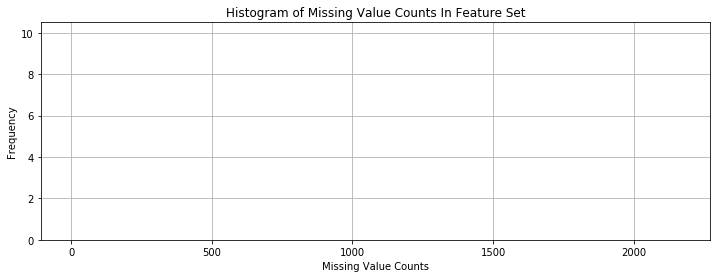

In [14]:
missing_count = td.isnull().sum()
#Plot a histogram of the missingness observed over all features in the dataset
ax = missing_count.hist(bins=num_rows,figsize=(12,4))
ax.set_xlabel("Missing Value Counts")
ax.set_ylabel("Frequency")
ax.set_title("Histogram of Missing Value Counts In Feature Set")

---
# Data Cleaning

### Remove instances (rows) with missing outcome values

In [15]:
print("Number of training instances in original dataset = ",num_rows)
td = td.dropna(axis=0,how='any',subset=[outcomeLabel])
print("Number of training instances after removing instances with missing endpoint = ",len(td))
diff = num_rows-len(td)
print("Number of instances removed = ", diff)
num_rows = len(td) #reassign value (if changed)
if diff > 0:
    data_changed = True
td.shape

Number of training instances in original dataset =  5128
Number of training instances after removing instances with missing endpoint =  5098
Number of instances removed =  30


(5098, 29)

In [16]:
#It's critical to reset the index after dropping rows to work with data frame later with pd.concat of separate columns
td = td.reset_index(drop=True)
td.shape
#Ensure Class variable is cast as an int
td[outcomeLabel] = td[outcomeLabel].astype(dtype='int64')
td.info()

(5098, 29)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5098 entries, 0 to 5097
Data columns (total 29 columns):
panc_type01          5098 non-null int64
cig_stat             5069 non-null float64
cig_stop             2946 non-null float64
cig_years            5000 non-null float64
pack_years           4997 non-null float64
bmi_curc             5015 non-null float64
bmi_curr             5015 non-null float64
diabetes_f           5050 non-null float64
panc_fh              5022 non-null float64
fh_cancer            5057 non-null float64
bmi_20               4998 non-null float64
bmi_50               5019 non-null float64
asp                  5038 non-null float64
ibup                 5053 non-null float64
gallblad_f           5053 non-null float64
liver_comorbidity    5048 non-null float64
age                  5098 non-null int64
agelevel             5098 non-null int64
educat               5064 non-null float64
race7                5098 non-null int64
hispanic_f           4994 non-null float6

In [17]:
#Confirm no missing values in outcome variable
na_percent = np.sum(td[outcomeLabel].isnull())/len(td[outcomeLabel])*100
if na_percent > 0:
    print(c,'\t\t% Missing(N/A) = ',np.sum(td[outcomeLabel].isnull())/len(td)*100)
else:
    print('No missing values found in: '+ str(outcomeLabel))

No missing values found in: panc_type01


### Remove columns to be ignored in analysis

In [18]:
print("Number of columns in original dataset = ", num_cols)
td = td.drop(ignore_columns, axis=1)
print("Number of columns after removing ignored columns = ", len(td.columns))
diff = num_cols-len(td.columns)
print("Number of columns removed = ", diff)
num_cols = len(td.columns)
if diff > 0:
    data_changed = True
td.shape

Number of columns in original dataset =  29
Number of columns after removing ignored columns =  25
Number of columns removed =  4


(5098, 25)

### Assess class imbalance (assuming discrete outcome)

Counts of each class
0    4298
1     800
Name: panc_type01, dtype: int64


Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Class Counts (Checking for Imbalance)')

(5098, 25)

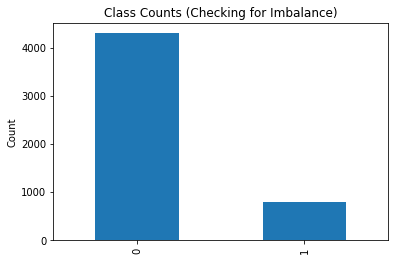

In [19]:
print("Counts of each class")
print(td[outcomeLabel].value_counts())
td[outcomeLabel].value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.title('Class Counts (Checking for Imbalance)')
td.shape

### Identify categorical variables in dataset

In [20]:
if autoDetectCategorical:
    #Separate independent variables from the rest
    if instLabel == None or instLabel == 'None':
        x_data = td.drop([outcomeLabel], axis=1)
    else:
        x_data = td.drop([outcomeLabel,instLabel], axis=1)

    categorical_variables = identifyCategoricalFeatures(x_data,categoricalCutoff)
    #print(categorical_variables)
    td.shape

(5098, 25)

---
# Example Code for other potential data cleaning/processing
- Not applied in this example script, but available here as an example

### Delete Rows/Instances with any missing values
- An extreme alternative to imputation when missing values must be eliminated from the dataset prior to machine learning

In [21]:
#num_rows = td.shape[0]
#print("Number of training instances in original dataset = ",num_rows)
#td = td.dropna()
#print("Number of training instances after removing instances with any missing values = ",td.shape[0])
#diff = num_rows-td.shape[0]
#if diff > 0:
#    data_changed = True

### Delete Columns with any missing values
- An extreme alternative to imputation when missing values must be eliminated from the dataset prior to machine learning

In [22]:
#num_cols = td.shape[1]
#print("Number of training instances in original dataset = ",num_cols)
#td = df.dropna(axis='columns')
#print("Number of training instances after removing instances with any missing values = ",td.shape[1])
#diff = num_cols-td.shape[1]
#if diff > 0:
#    data_changed = True

### One hot encoding of categorical variables
- Ensures that categorical variables are not treated in an ordinal manner by ML algorithms
- The code below is an example of how to convert a single column to one hot encoding, and is not meant to be run as is. 

In [23]:
## Example below assumes a data frame 'df' with a column called 'B'
#one_hot = pd.get_dummies(df['B'])
#df = df.drop('B',axis = 1)
#df = df.join(one_hot)

### Other possible cleaning steps:
- encode text values as numerics
- oversample or undersample to reduce class imbalance
- drop additional rows based on assigned cutoffs, etc
- cast variable types as nominal or ordinal
- construct missingness features with MissingIndicator: https://scikit-learn.org/stable/modules/impute.html

In [24]:
#Saved for later, determines if imputation attempted.
isMissingData = False
if td.isnull().values.any():
    isMissingData = True

## Save cleaned dataset if it has been modified

In [25]:
if data_changed:
    print('Saving cleaned data.')
    td.shape
    data_name = data_name +'_clean'
    td.to_csv(data_name+'.txt', index=None, sep='\t')

Saving cleaned data.


(5098, 25)

---
# Further Exploratory/Descriptive Analysis
- Visualize feature correlations in data
- Appropriate univariate analyses

## Feature Correlations

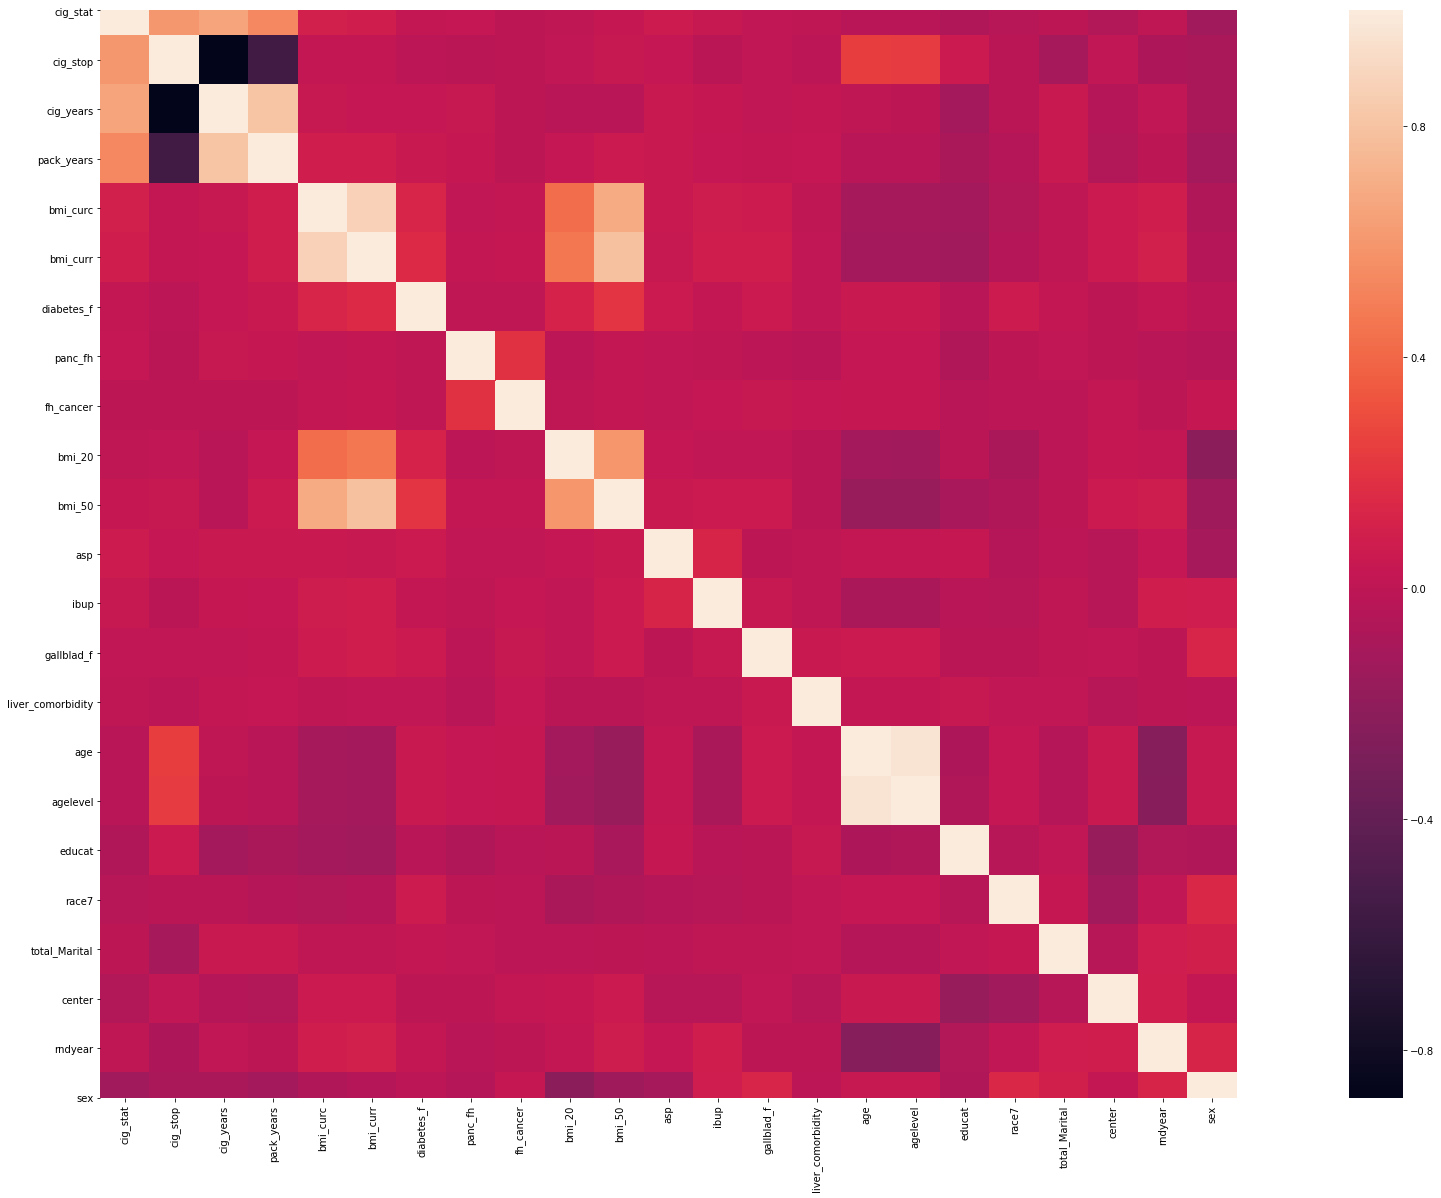

In [26]:
if doCorrelation:
    #Drop outcome column for correlation analysis
    td_cor = td.drop([outcomeLabel], axis=1)
    
    #Compute correlation between the outcome and each feature , excluding NA/null values.
    corrmat = td_cor.corr(method='pearson') 
    f, ax = plt.subplots(figsize = (40,20)) # Note: need large size
    sns.heatmap(corrmat, vmax =1.0,square = True) # Set max value and square-shaped


## Univariate Analysis and Plots
Below we have encoded a method to automatically select an appropriate plot and univariate association test between a single feature and the target outcome in the dataset.

In [27]:
# Code to analyze the univariate relationship between the outcome and each feature
def test_selector(featureName, outcomeLabel, td, categorical_variables):
    p_val = 0
    #Feature and Outcome are discrete/categorical/binary
    if featureName in categorical_variables:  
        #Calculate Contingency Table - Counts
        table = pd.crosstab(td[featureName], td[outcomeLabel])
        
        #Univariate association test (Chi Square Test of Independence - Non-parametric)
        c, p, dof, expected = scs.chi2_contingency(table)
        p_val = p
        
    #Feature is continuous and Outcome is discrete/categorical/binary
    else: 
        #Univariate association test (Mann-Whitney Test - Non-parametric)
        c, p = scs.mannwhitneyu(x=td[featureName].loc[td[outcomeLabel] == 0],y=td[featureName].loc[td[outcomeLabel] == 1])
        p_val = p
        
    return p_val

In [28]:
# Function select appropriate visualizations to examine univariate relationships between each feature and outcome

def graph_selector(featureName, outcomeLabel, td, categorical_variables):
    #Feature and Outcome are discrete/categorical/binary
    if featureName in categorical_variables:  
        #Generate contingency table count bar plot. ------------------------------------------------------------------------
        #Calculate Contingency Table - Counts
        table = pd.crosstab(td[featureName], td[outcomeLabel])
        geom_bar_data = pd.DataFrame(table)
        mygraph = geom_bar_data.plot(kind='bar')
        plt.ylabel('Count')
        new_feature_name = featureName.replace(" ","") #Deal with the dataset specific characters causing problems in this dataset.
        new_feature_name = new_feature_name.replace("*","") #Deal with the dataset specific characters causing problems in this dataset.
        new_feature_name = new_feature_name.replace("/","") #Deal with the dataset specific characters causing problems in this dataset.
        plt.savefig((wd_path+ua_folder+'/'+'UA_Barplot_' + str(new_feature_name)+'_'+outcomeLabel+'_'+data_name), bbox_inches = "tight")
        plt.show()
        
    #Feature is continuous and Outcome is discrete/categorical/binary    
    else: 
        #Generate boxplot-----------------------------------------------------------------------------------------------------
        mygraph = td.boxplot(column=featureName,by=outcomeLabel)
        plt.ylabel(featureName)
        plt.title('')
        new_feature_name = featureName.replace(" ","") #Deal with the dataset specific characters causing problems in this dataset.
        new_feature_name = new_feature_name.replace("*","") #Deal with the dataset specific characters causing problems in this dataset.
        new_feature_name = new_feature_name.replace("/","") #Deal with the dataset specific characters causing problems in this dataset.
        plt.savefig((wd_path+ua_folder+'/'+'UA_Boxplot_' + str(new_feature_name)+'_'+outcomeLabel+'_'+data_name), bbox_inches = "tight")
        plt.show()

Plotting top significant 20 features.
###################################################
Significant Univariate Associations:
sex: (p-val = 7.391784443712373e-86)
race7: (p-val = 2.536193502544118e-48)
center: (p-val = 1.592156210115093e-20)
cig_stop: (p-val = 1.6687279079980054e-11)
cig_stat: (p-val = 8.770533043202116e-11)
gallblad_f: (p-val = 1.6008209713688788e-07)
total_Marital: (p-val = 5.2949541626533e-07)
cig_years: (p-val = 4.318980433391872e-06)
bmi_curc: (p-val = 0.00014863382844742507)
pack_years: (p-val = 0.000383585153873031)
age: (p-val = 0.0009053592901335461)
panc_fh: (p-val = 0.0022017827819021296)
rndyear: (p-val = 0.0025521241191893774)
diabetes_f: (p-val = 0.0036111210931641024)
fh_cancer: (p-val = 0.004772926613656827)
agelevel: (p-val = 0.006222319565214877)
bmi_20: (p-val = 0.03206515042084443)
educat: (p-val = 0.0424940416156217)
bmi_50: (p-val = 0.06160544476241928)
asp: (p-val = 0.08166098752553685)


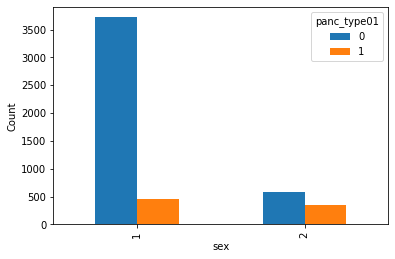

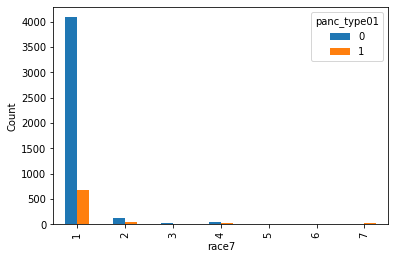

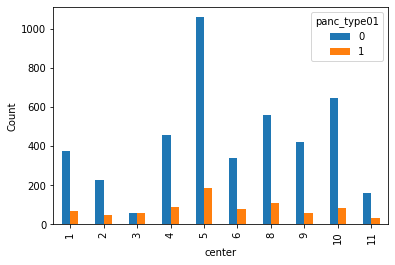

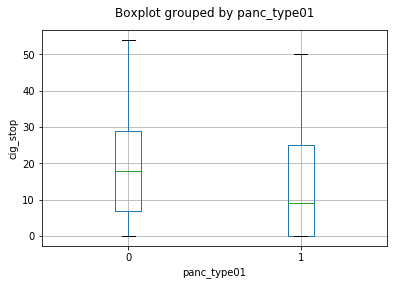

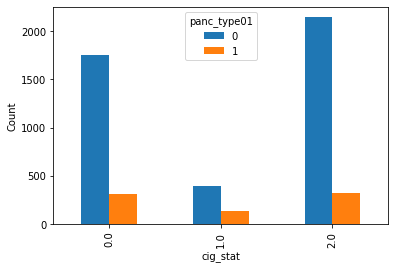

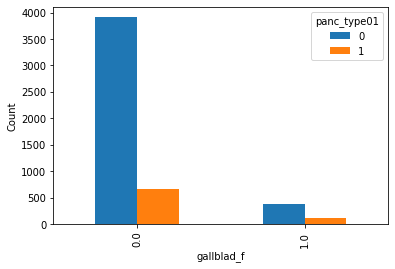

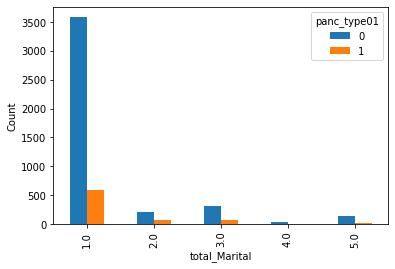

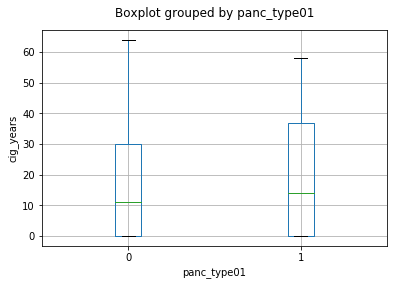

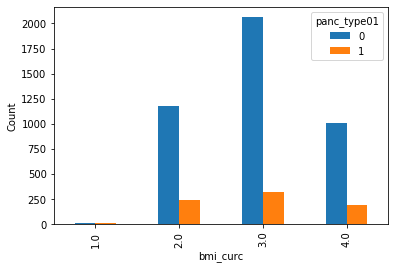

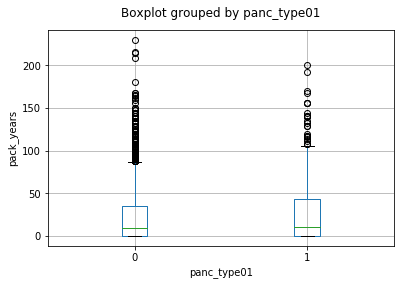

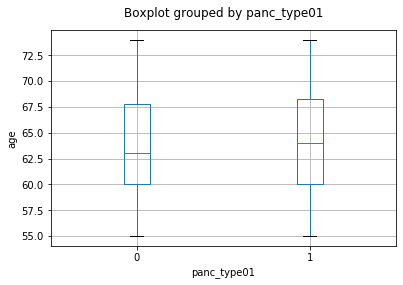

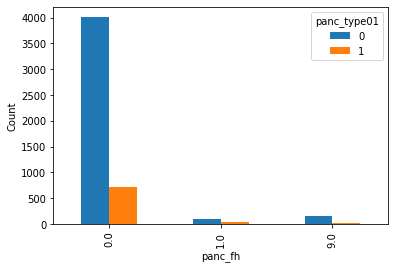

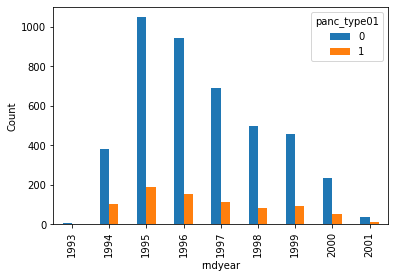

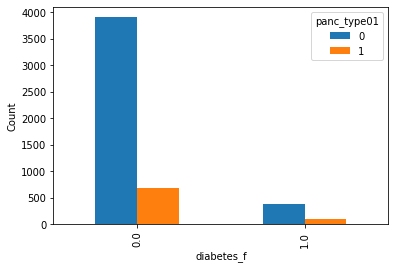

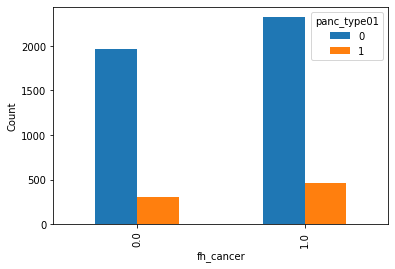

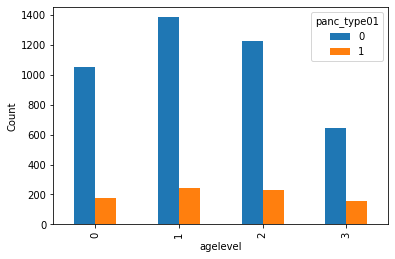

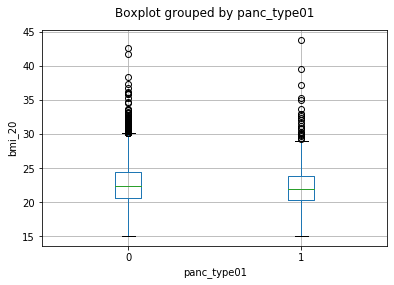

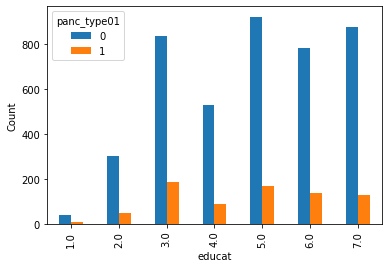

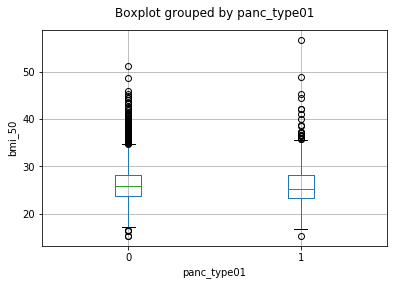

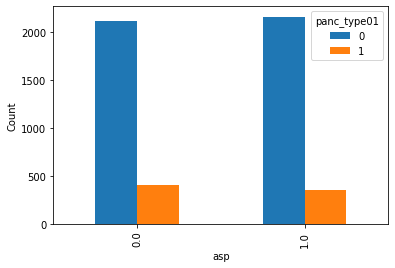

In [29]:
if doUA:
    p_val_dict = {}
    # run appropriate univariate association test for each independent variable
    for each in td:
        if each != outcomeLabel: 
            p_val_dict[each] = test_selector(each, outcomeLabel, td, categorical_variables)
    
    num_features = td.shape[1] - 1
    
    sorted_p_list = sorted(p_val_dict.items(), key = lambda item:item[1])
    
    #Save all p-values to file
    pval_df = pd.DataFrame.from_dict(p_val_dict, orient='index')
    filepath = wd_path+ua_folder+'/'+'UA_Significance_'+data_name+'.csv'
    pval_df.to_csv(filepath, header=['p-value'], index=True)  
    
    min_num = min(topResults,num_features)
    sorted_p_list = sorted_p_list[: min_num]
    print('Plotting top significant '+ str(min_num) + ' features.')
    
    # summarize significant values of selected number of features
    print('###################################################')
    print('Significant Univariate Associations:')
    for each in sorted_p_list[:min_num]:
        print(each[0]+": (p-val = "+str(each[1]) +")")

    #generate appropriate descriptive plot for selected number of features
    for i in sorted_p_list:
        for j in td:
            if j == i[0]:# if the feature name is within the selected feature list
                graph_selector(j, outcomeLabel, td, categorical_variables) #plot appropriate figure for each feature

---
# Create n-fold Cross Validation (CV) Datasets 
- i.e. Training and Testing Datasets

In [30]:
#Create a header list of independant feature names
header = td.columns.values.tolist()
header.remove(outcomeLabel)
if instLabel != None and instLabel != 'None':
    header.remove(instLabel)

#Perform CV partitioning (get back list of training and testing partition dataframes)
train_dfs, test_dfs = cv_partitioner(td, cv_partitions, partition_method, outcomeLabel, categoricalOutcome, matchName, randomSeed)

if partition_method == 'M':
    header.remove(matchName)

Nominal Stratitifed Partitioning


---
# Transform data - Standard Scaling
- Features are independently scaled to allow them to be more comparable in downstream logistic regression modeling, etc
- Scaling is learned on the training data and saved with pickel so that the same scaling may be applied to any future testing data
- Completed within each training and testing partition independently

In [31]:
if scaleData:
    print('Scaling Data')
    data_name = data_name +'_scale'
    name_path = wd_path+model_folder+'/'+'Scalar_' + data_name+'_'
    train_dfs, test_dfs = dataScaling(train_dfs, test_dfs, outcomeLabel, instLabel, name_path, header)

Scaling Data


---
# Impute Missing Data Values
- Missing data values in categorical features are imputed with simple 'mode' imputation
- Remaining missing data values are imputed using Iterative Imputer (i.e. MICE) 
- Completed within each training and testing partition independently

In [32]:
if imputeData and isMissingData:
    print('Imputing Data')
    data_name = data_name + '_imp'
    train_dfs, test_dfs = imputeCVData(outcomeLabel, instLabel, categorical_variables, header, train_dfs, test_dfs, randomSeed)

Imputing Data


### Confirm Missing Data Imputation

In [33]:
print("Training Datasets")
for each in train_dfs:
    each.isnull().sum().sum()

print("Testing Datasets")
for each in test_dfs:
    each.isnull().sum().sum()

Training Datasets


0

0

0

0

0

0

0

0

0

0

Testing Datasets


0

0

0

0

0

0

0

0

0

0

## Save Training and Testing Datasets as .txt Files

In [34]:
data_name = data_name+'_CV_'+str(partition_method)

counter = 0
for each in train_dfs:
    each.to_csv(cv_data_folder+'/'+data_name+'_'+str(counter)+'_Train.txt', index=None, sep='\t')
    counter += 1
    
counter = 0
for each in test_dfs:
    each.to_csv(cv_data_folder+'/'+data_name+'_'+str(counter)+'_Test.txt', index=None, sep='\t')
    counter += 1

---
# Load, Check, and Prepare Saved CV Datasets for ML

## Load CV Partition Datasets
Re-loads training and testing datasets from saved .txt files

In [35]:
#create lists to hold training and testing set dataframes.
trainList = []
testList = []

for i in range(cv_partitions):
    #Load training partition
    trainSet = pd.read_csv(cv_data_folder+'/'+data_name+'_'+str(i)+'_Train.txt', na_values='NA', sep = "\t")
    trainList.append(trainSet)
    
    #Load testing partition
    testSet = pd.read_csv(cv_data_folder+'/'+data_name+'_'+str(i)+'_Test.txt', na_values='NA', sep = "\t")
    testList.append(testSet)
    
print('Number of Training Partitions: '+ str(len(trainList)))
print('Number of Training Partitions: '+ str(len(testList)))

Number of Training Partitions: 10
Number of Training Partitions: 10


#### Quality Control Check (Checking one of the partitions)
Merge the first training/testing datasets to confirm original dataset is reconstituted

In [36]:
#Confirm case/control counts when merging one training and testing dataset
classesTrain = trainList[0].apply(lambda x: True if x[outcomeLabel] == 1 else False , axis=1)
casesTrain = len(classesTrain[classesTrain == True].index)
controlsTrain = len(classesTrain[classesTrain == False].index)

classesTest = testList[0].apply(lambda x: True if x[outcomeLabel] == 1 else False , axis=1)
casesTest = len(classesTest[classesTest == True].index)
controlsTest = len(classesTest[classesTest == False].index)

print("Number of Cases in Original Dataset: "+str(casesTrain+casesTest))
print("Number of Controls in Original Dataset: "+str(controlsTrain+controlsTest))

Number of Cases in Original Dataset: 800
Number of Controls in Original Dataset: 4298


In [37]:
#Confirm training and testing set dimensions
print("Training Set Dimensions: " + str(trainList[0].shape))
print("Testing Set Dimensions: " + str(testList[0].shape))
numColumns = trainList[0].shape[1]

Training Set Dimensions: (4588, 25)
Testing Set Dimensions: (510, 25)


## Partition Data Preprocessing
If present, remove instance id's from datasets prior to analysis. Also confirm that training and testing sets have same set of columns.

In [38]:
# Drop Instance ID from all training and test sets
if instLabel != None and instLabel != 'None':
    for i in range(cv_partitions):
        trainList[i] = trainList[i].drop([instLabel] , axis = 1)
        testList[i] = testList[i].drop([instLabel] , axis = 1)

In [39]:
trainColumnNames = list(trainList[0])
testColumnNames = list(testList[0])

if not trainColumnNames == testColumnNames:
    print('Error: Training columns do not match testing columns!')

# As we can see, instLabel is no longer a column name for any of the sets
#print(trainColumnNames)
#print(testColumnNames)

#Create master list of feature names (excluding outcome column)
ordered_feature_names = copy.deepcopy(trainColumnNames) #Stores original ordered feature list 
ordered_feature_names.remove(outcomeLabel)
#ordered_feature_names

## Format data for Scikit learn (separate features from outcome)

In [40]:
# Separate data into training and test features and outcomes
xTrainList = []
yTrainList = []
xTestList = []
yTestList = []

for i in range(cv_partitions):
    xTrainList.append(trainList[i].iloc[:, 1:].values)
    yTrainList.append(trainList[i].iloc[:, 0].values)
 
    xTestList.append(testList[i].iloc[:, 1:].values)
    yTestList.append(testList[i].iloc[:, 0].values)

---
# Feature Importance Evaluation
- Completed independently within each training dataset

In [41]:
#Store indexes of 'interesting' features identified by each algorithm in algorithm labeled dictionary
selectedFeatureLists = {}
metaScoreDict = {}
metaFeatureRanks = {}

## Mutual information


Mutual Information Run Time: 9.559181451797485


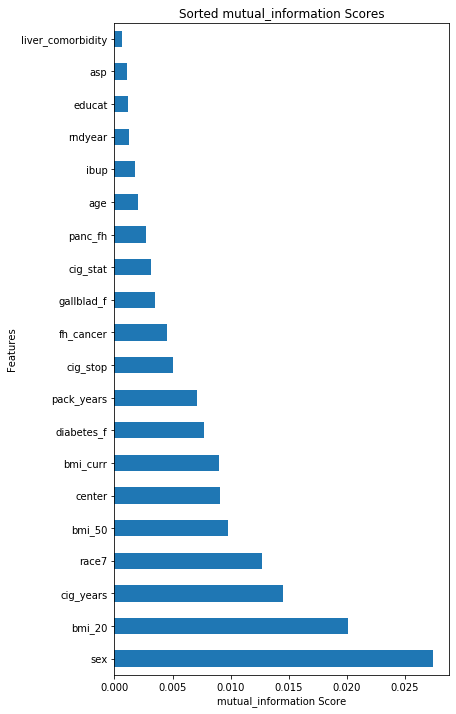

In [42]:
#Run Mutual Information for each CV------------------------------------------------------------------------------
algorithm = 'mutual_information'
if algorithm in algorithms:
    start_time = time.time()
    scoreSet = [] #Used to save excel filel with data-ordered scores for each CV partition
    featureNameRanks = [] #list of feature name ranks for each CV partition
    scoreDictSet = [] #list of feature/score dictionaries (one for each cv partition)
    cvKeepList = [] #Used for initial feature selection attempt to keep only features with 'informative' support
    
    for i in tqdm_notebook(range(cv_partitions), desc='1st loop'):
        #Run algorithm and return scores and sorted score dictionary
        scores, scoreDict, score_sorted_features = run_mi(xTrainList[i],yTrainList[i], i, data_name, output_folder,randomSeed,ordered_feature_names,algorithm)
        scoreSet.append(scores) #store data-ordered scores for this cv partition
        scoreDictSet.append(scoreDict)
        featureNameRanks.append(score_sorted_features)
        
        #Add list of feature names that meet the 'informative' cutoff
        keepList = []
        for each in scoreDict:
            if scoreDict[each] > 0:
                keepList.append(each)
                #keepList.append(ordered_feature_names.index(each))
        cvKeepList.append(keepList)
        
        #Create dictionary of average scores
        if i == 0:
            scoreSum = copy.deepcopy(scoreDict)
        else:
            for each in scoreDict:
                scoreSum[each] += scoreDict[each]
    
    #Save/report analysis results
    #cv_output_name = data_name+'_clean_imp_CV_'+partition_method
    reportAllFS(scoreSet, algorithm, ordered_feature_names,output_folder,data_name) #Save CV scores file for algorithm
    reportTopFS(scoreSum, algorithm, cv_partitions,topResults,wd_path,output_folder,data_name)
    
    #Store info for downstream feature selection
    selectedFeatureLists[algorithm] = cvKeepList
    metaScoreDict[algorithm] = scoreDictSet
    metaFeatureRanks[algorithm] = featureNameRanks

    elapsed_time = time.time() - start_time
    print('Mutual Information Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## MultiSURF


MultiSURF Run Time: 750.9629020690918


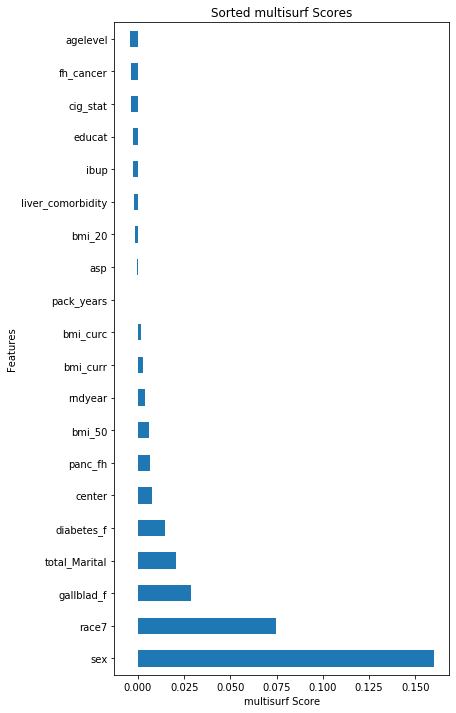

In [43]:
#Run MultiSURF for each CV------------------------------------------------------------------------------
algorithm = 'multisurf'
if algorithm in algorithms:
    start_time = time.time()
    scoreSet = [] #Used to save excel filel with data-ordered scores for each CV partition
    scoreDictSet = [] #list of feature/score dictionaries (one for each cv partition)
    cvKeepList = [] #Used for initial feature selection attempt to keep only features with 'informative' support
    
    for i in tqdm_notebook(range(cv_partitions), desc='1st loop'):
        #If training set is large MultiSURF will run very slowly - quadradic time complexity with # instances (so use subset)
        tempData = pd.concat([pd.DataFrame(yTrainList[i]),pd.DataFrame(xTrainList[i])], axis=1, sort=False)
        if len(tempData) < instanceSubset:
            dataSample = tempData.sample(n=len(tempData), axis = 0)
        else:
            dataSample = tempData.sample(n=instanceSubset, axis = 0)

        xTrain = dataSample.iloc[:, 1:].values
        yTrain = dataSample.iloc[:, 0].values
        #Run algorithm and return scores and sorted score dictionary
        scores, scoreDict, score_sorted_features = run_multisurf(xTrain,yTrain, i, data_name, output_folder,randomSeed,ordered_feature_names,algorithm)
        scoreSet.append(scores) #store data-ordered scores for this cv partition
        scoreDictSet.append(scoreDict)
        featureNameRanks.append(score_sorted_features)
        
        #Add list of feature names that meet the 'informative' cutoff
        keepList = []
        for each in scoreDict:
            if scoreDict[each] > 0:
                keepList.append(each)
                #keepList.append(ordered_feature_names.index(each))
        cvKeepList.append(keepList)
        
        #Create dictionary of average scores
        if i == 0:
            scoreSum = copy.deepcopy(scoreDict)
        else:
            for each in scoreDict:
                scoreSum[each] += scoreDict[each]
    
    #Save/report analysis results
    reportAllFS(scoreSet, algorithm, ordered_feature_names,output_folder,data_name) #Save CV scores file for algorithm
    reportTopFS(scoreSum, algorithm, cv_partitions,topResults,wd_path,output_folder,data_name)
    
    #Store info for downstream feature selection
    selectedFeatureLists[algorithm] = cvKeepList
    metaScoreDict[algorithm] = scoreDictSet
    metaFeatureRanks[algorithm] = featureNameRanks
    
    elapsed_time = time.time() - start_time
    print('MultiSURF Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

---
# Feature Selection

## Identify union of 'interesting' features from different algorithms
- Operates no matter how many feature selection methods are being applied
- But assumes that all methods have larger scores as being more informative

In [44]:
cv_Selected_List = selectFeatures(algorithms, cv_partitions, selectedFeatureLists, maxFeaturesToKeep,metaFeatureRanks)

### Report counts of 'interesting' features identified by each algorithm

In [45]:
print('Original feature count: '+str(len(ordered_feature_names)))

for each in algorithms:
    print(each)
    for cv in selectedFeatureLists[each]:
        print(len(cv))
    
print("Selected Counts")
for each in cv_Selected_List:
    print(len(each))

Original feature count: 23
mutual_information
18
16
16
15
18
16
18
18
18
19
multisurf
10
13
14
11
12
12
12
12
15
10
Selected Counts
20
20
20
18
21
19
19
19
21
19


## Generate Filtered Datasets (Save as new .txt files)
- These datasets included only the selected features for each respective partition
- Note that the feature order from the original datasets is no longer preserved in these datasets

In [46]:
if filterPoorFeatures:
    genFilteredDatasets(cv_Selected_List, outcomeLabel, instLabel,cv_partitions,cv_data_folder,data_name)
    data_name = data_name +'_FS'

## Generate Filtered MultiSURF Files (Save as new .txt files)

In [47]:
if 'multisurf' in algorithms: #This method is only meant for working with MultiSURF scores
    if filterPoorFeatures:
        for i in range(cv_partitions):
            tempDict = scoreDictSet[i]

            #create new dictionary with only selected features
            scoreDict = {}
            for j in cv_Selected_List[i]:
                scoreDict[j] = tempDict[j]
            
            filename = output_folder+'/'+'multisurf'+'_'+data_name+'_'+str(i)+'_Train.txt'
            sort_save_fs_fi_scores(scoreDict, 'multisurf', filename)

---
# Load, Check, and Prepare Filtered CV Datasets for ML
- If user opted not to filter datasets then the code below will simply reload the original CV datasets again.

## Load CV Partition Datasets (Filtered Datasets)

In [48]:
#create lists to hold training and testing set dataframes.
trainList = []
testList = []

for i in range(cv_partitions):
    #Load training partition
    trainset_name = cv_data_folder+'/'+data_name+'_'+str(i)+'_Train.txt'
    trainSet = pd.read_csv(trainset_name, na_values='NA', sep = "\t")
    trainList.append(trainSet)

    #Load testing partition
    testset_name = cv_data_folder+'/'+data_name+'_'+str(i)+'_Test.txt'
    testSet = pd.read_csv(testset_name, na_values='NA', sep = "\t")
    testList.append(testSet)
    
print('Number of Training Partitions: '+ str(len(trainList)))
print('Number of Training Partitions: '+ str(len(testList)))

Number of Training Partitions: 10
Number of Training Partitions: 10


## CV partition data cleaning (Filtered Datasets)

In [49]:
# Drop Instance ID from all training and test sets
if instLabel != None and instLabel != 'None':
    for i in range(cv_partitions):
        trainList[i] = trainList[i].drop([instLabel] , axis = 1)
        testList[i] = testList[i].drop([instLabel] , axis = 1)

In [50]:
global_ordered_features = [] #Holds the new order of features in the FS CV datasets
for i in range(cv_partitions):
    cv_ordered_features = list(trainList[i])
    cv_ordered_features.remove(outcomeLabel)
    #print(cv_ordered_features)
    global_ordered_features.append(cv_ordered_features)

## Format data for Scikit learn (filtered datasets)

In [51]:
# Separate data into training and test features and outcomes
xTrainList = []
yTrainList = []
xTestList = []
yTestList = []

for i in range(cv_partitions):
    xTrainList.append(trainList[i].iloc[:, 1:].values)
    yTrainList.append(trainList[i].iloc[:, 0].values)
 
    xTestList.append(testList[i].iloc[:, 1:].values)
    yTestList.append(testList[i].iloc[:, 0].values)


---
# Machine Learning Modeling
ML algorithms are run one after the other below. Within each we conduct a hyperparameter sweep, train a best model and evaluate it indendently within each CV training/testing partition. 
- All standard classification metrics are computed for the resulting models as well as an ROC curve and precision/recall curve

## Run Logistic Regression

Running logistic_regression
Best trial:
  Value:  0.6789815382795789
  Params: 
    penalty: l2
    dual: False
    C: 0.03842884090673402
    solver: newton-cg
    class_weight: balanced
    max_iter: 532.3617594751498
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.6759457634967315
  Params: 
    penalty: l2
    dual: False
    C: 32147.193482816965
    solver: liblinear
    class_weight: balanced
    max_iter: 157.51320499779712
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.6785622430303723
  Params: 
    penalty: l2
    dual: False
    C: 0.03842884090673402
    solver: newton-cg
    class_weight: balanced
    max_iter: 532.3617594751498
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.6757518648151825
  Params: 
    penalty: l2
    dual: False
    C: 0.03842884090673402
    solver: newton-cg
    class_weight: balanced
    max_iter: 532.3617594751498
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.6859608884959797
  Params: 
    penalty: l2
    dual: False
    C: 0.03842884090673402
    solver: newton-cg
    class_weight: balanced
    max_iter: 532.3617594751498
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.6819381674194084
  Params: 
    penalty: l2
    dual: False
    C: 0.03842884090673402
    solver: newton-cg
    class_weight: balanced
    max_iter: 532.3617594751498
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.6817125703878775
  Params: 
    penalty: l2
    dual: False
    C: 32147.193482816965
    solver: liblinear
    class_weight: balanced
    max_iter: 157.51320499779712
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.6835515507885246
  Params: 
    penalty: l2
    dual: False
    C: 0.03842884090673402
    solver: newton-cg
    class_weight: balanced
    max_iter: 532.3617594751498
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.6857258446044147
  Params: 
    penalty: l2
    dual: False
    C: 2.9285768980188992e-05
    solver: sag
    class_weight: balanced
    max_iter: 29.21074818565715
    n_jobs: -1



Running logistic_regression
Best trial:
  Value:  0.6822899314012626
  Params: 
    penalty: l2
    dual: False
    C: 0.03842884090673402
    solver: newton-cg
    class_weight: balanced
    max_iter: 532.3617594751498
    n_jobs: -1


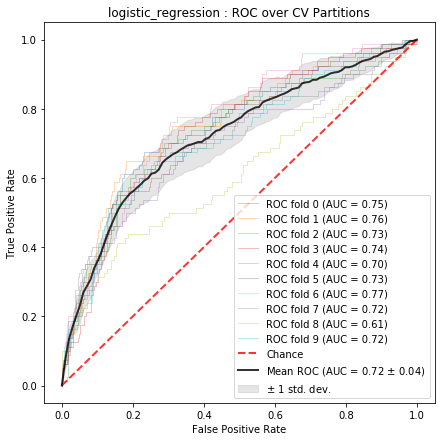

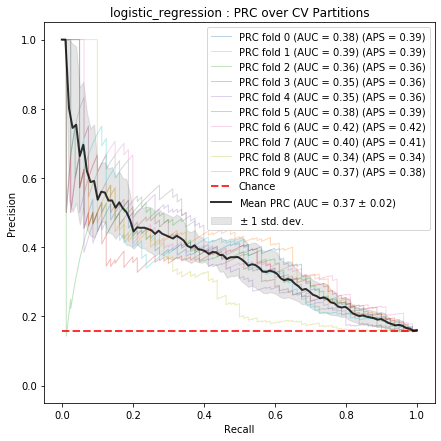

Avg. Model Balanced Accuracy = 0.6795253632026887 (std. dev. = 0.031088679289716908)
Avg. Model Accuracy = 0.7538156323433106 (std. dev. = 0.022298154758954667)
Avg. Model F1-Score = 0.4221264557304175 (std. dev. = 0.039882526301709964)
Avg. Model Recall = 0.57125 (std. dev. = 0.04577458355900139)
Avg. Model Specificity = 0.7878007264053776 (std. dev. = 0.019078649864201835)
Avg. Model Precision = 0.3349592567318168 (std. dev. = 0.03521890779926648)
Avg. Model True Positives = 45.7 (std. dev. = 3.6619666847201113)
Avg. Model True Negatives = 338.6 (std. dev. = 8.333066662399863)
Avg. Model False Positives = 91.2 (std. dev. = 8.158431221748456)
Avg. Model False Negatives = 34.3 (std. dev. = 3.6619666847201113)
Avg. ROC AUC = 0.7211482896948013 (std. dev. = 0.04213322784680079)
Avg. PRC AUC = 0.37440505445417804 (std. dev. = 0.023257457811178543)
Avg. PRC Precision Score = 0.37946283521653856 (std. dev. = 0.02329623746867406)

---Feature Importances---



Names    Scores
22            sex  0.075431
18          race7  0.025170
0        cig_stat  0.007282
6      diabetes_f  0.006877
1        cig_stop  0.005349
3      pack_years  0.002500
21        rndyear  0.002384
2       cig_years  0.002297
8       fh_cancer  0.002267
13     gallblad_f  0.002006
15            age  0.001992
5        bmi_curr  0.001643
7         panc_fh  0.001599
20         center  0.001570
10         bmi_50  0.001366
9          bmi_20  0.001366
17         educat  0.001208
19  total_Marital  0.000742
11            asp  0.000741
12           ibup  0.000625

Logistic Regression Run Time: 296.77040934562683


In [52]:
algorithm = 'logistic_regression'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)

    elapsed_time = time.time() - start_time
    print('Logistic Regression Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run Decision Tree

Running decision_tree
Best trial:
  Value:  0.6771276107913712
  Params: 
    criterion: entropy
    splitter: best
    max_depth: 4
    min_samples_split: 15
    min_samples_leaf: 35
    max_features: None
    class_weight: balanced
Running decision_tree
Best trial:
  Value:  0.6786733877191823
  Params: 
    criterion: gini
    splitter: best
    max_depth: 4
    min_samples_split: 6
    min_samples_leaf: 29
    max_features: None
    class_weight: balanced
Running decision_tree
Best trial:
  Value:  0.6776644655733367
  Params: 
    criterion: gini
    splitter: best
    max_depth: 4
    min_samples_split: 15
    min_samples_leaf: 24
    max_features: None
    class_weight: balanced
Running decision_tree
Best trial:
  Value:  0.6764970642065741
  Params: 
    criterion: gini
    splitter: best
    max_depth: 4
    min_samples_split: 34
    min_samples_leaf: 28
    max_features: None
    class_weight: balanced
Running decision_tree
Best trial:
  Value:  0.6807447809230559
  Params: 


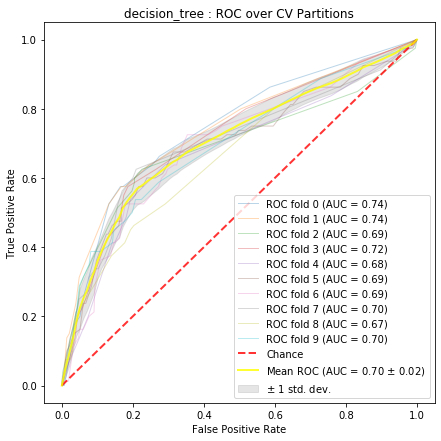

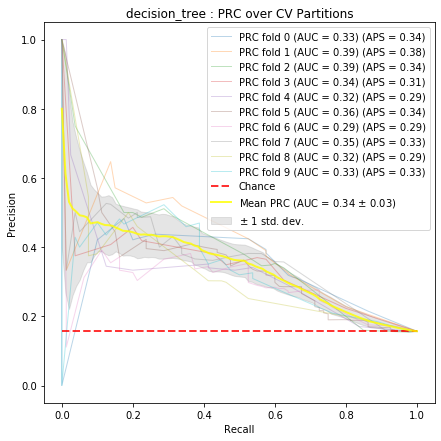

Avg. Model Balanced Accuracy = 0.6744562123922588 (std. dev. = 0.024824325635141257)
Avg. Model Accuracy = 0.7581339805077236 (std. dev. = 0.025404822041988975)
Avg. Model F1-Score = 0.41828865395474857 (std. dev. = 0.033364186604779036)
Avg. Model Recall = 0.5525 (std. dev. = 0.04802343178074636)
Avg. Model Specificity = 0.7964124247845177 (std. dev. = 0.03130628542471559)
Avg. Model Precision = 0.33809691883819126 (std. dev. = 0.03355632407638899)
Avg. Model True Positives = 44.2 (std. dev. = 3.841874542459709)
Avg. Model True Negatives = 342.3 (std. dev. = 13.51332675546625)
Avg. Model False Positives = 87.5 (std. dev. = 13.44804818551748)
Avg. Model False Negatives = 35.8 (std. dev. = 3.841874542459709)
Avg. ROC AUC = 0.7024629038597062 (std. dev. = 0.02383776759818848)
Avg. PRC AUC = 0.34272349646987565 (std. dev. = 0.03131105137779764)
Avg. PRC Precision Score = 0.3220065491557865 (std. dev. = 0.027965986810609838)

---Feature Importances---



Names    Scores
22            sex  0.558035
18          race7  0.192942
1        cig_stop  0.073551
3      pack_years  0.038131
2       cig_years  0.033881
5        bmi_curr  0.015803
21        rndyear  0.015311
9          bmi_20  0.013711
15            age  0.012897
8       fh_cancer  0.009913
20         center  0.009510
0        cig_stat  0.006582
13     gallblad_f  0.004494
12           ibup  0.003841
6      diabetes_f  0.002328
10         bmi_50  0.002046
19  total_Marital  0.001901
17         educat  0.001760
4        bmi_curc  0.001723
11            asp  0.001638

Decision Tree Run Time: 286.4733467102051


In [53]:
algorithm = 'decision_tree'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)

    elapsed_time = time.time() - start_time
    print('Decision Tree Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run Random Forest

Running random_forest
Best trial:
  Value:  0.6852880064469181
  Params: 
    n_estimators: 929
    criterion: gini
    max_depth: 21
    min_samples_split: 49
    min_samples_leaf: 22
    max_features: log2
    bootstrap: True
    oob_score: False
    n_jobs: -1
    class_weight: balanced
Running random_forest
Best trial:
  Value:  0.6804733403094761
  Params: 
    n_estimators: 133
    criterion: gini
    max_depth: 13
    min_samples_split: 10
    min_samples_leaf: 24
    max_features: auto
    bootstrap: True
    oob_score: True
    n_jobs: -1
    class_weight: balanced
Running random_forest
Best trial:
  Value:  0.687116951124903
  Params: 
    n_estimators: 395
    criterion: entropy
    max_depth: 8
    min_samples_split: 48
    min_samples_leaf: 22
    max_features: log2
    bootstrap: True
    oob_score: False
    n_jobs: -1
    class_weight: balanced
Running random_forest
Best trial:
  Value:  0.6824735187223235
  Params: 
    n_estimators: 383
    criterion: gini
    max_dep

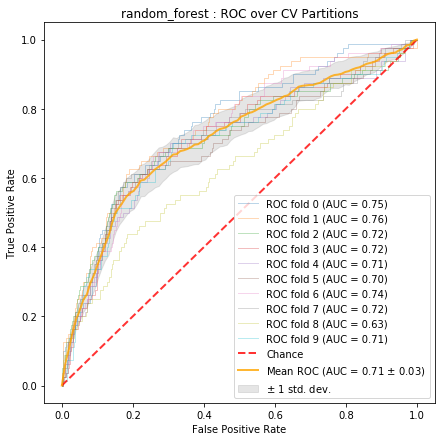

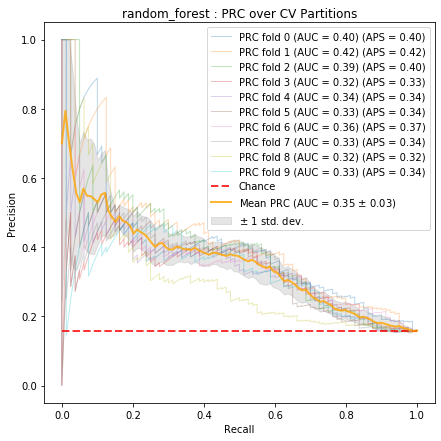

Avg. Model Balanced Accuracy = 0.6798141635496286 (std. dev. = 0.028496342157361187)
Avg. Model Accuracy = 0.7645976347316922 (std. dev. = 0.025495070102015037)
Avg. Model F1-Score = 0.4271540501465144 (std. dev. = 0.03790026027474764)
Avg. Model Recall = 0.55625 (std. dev. = 0.03502231431530476)
Avg. Model Specificity = 0.8033783270992572 (std. dev. = 0.02463510575512501)
Avg. Model Precision = 0.34711168432380646 (std. dev. = 0.03636371216905547)
Avg. Model True Positives = 44.5 (std. dev. = 2.80178514522438)
Avg. Model True Negatives = 345.3 (std. dev. = 10.835589508651571)
Avg. Model False Positives = 84.5 (std. dev. = 10.509519494249012)
Avg. Model False Negatives = 35.5 (std. dev. = 2.80178514522438)
Avg. ROC AUC = 0.7146284965034965 (std. dev. = 0.03335653195554701)
Avg. PRC AUC = 0.35448356149542926 (std. dev. = 0.034066124291203245)
Avg. PRC Precision Score = 0.3606106595242177 (std. dev. = 0.033087784932829746)

---Feature Importances---



Names    Scores
22            sex  0.306167
18          race7  0.097271
1        cig_stop  0.089941
9          bmi_20  0.075491
10         bmi_50  0.073805
5        bmi_curr  0.064471
2       cig_years  0.056621
3      pack_years  0.051760
20         center  0.042380
15            age  0.037076
21        rndyear  0.034210
8       fh_cancer  0.017078
17         educat  0.012932
19  total_Marital  0.008085
13     gallblad_f  0.006691
0        cig_stat  0.006386
11            asp  0.004411
12           ibup  0.004294
4        bmi_curc  0.003623
6      diabetes_f  0.003536

Random Forest Run Time: 2604.0302968025208


In [54]:
algorithm = 'random_forest'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))
    
    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('Random Forest Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run Naive Bayes

Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes



Running naive_bayes


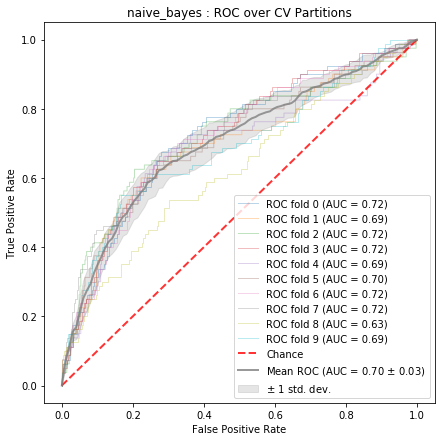

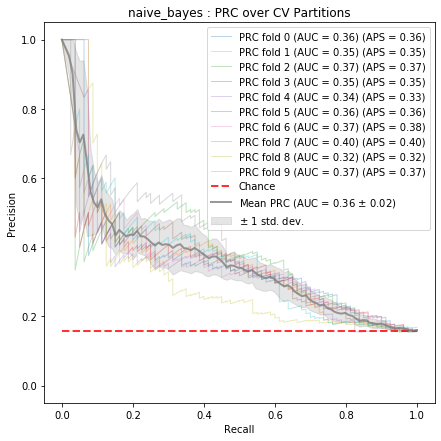

Avg. Model Balanced Accuracy = 0.6053287797473844 (std. dev. = 0.02281227974880077)
Avg. Model Accuracy = 0.8216918987634345 (std. dev. = 0.014380272144087382)
Avg. Model F1-Score = 0.33831884305640864 (std. dev. = 0.04497410391836475)
Avg. Model Recall = 0.29000000000000004 (std. dev. = 0.03699662146737186)
Avg. Model Specificity = 0.9206575594947688 (std. dev. = 0.01162934237465462)
Avg. Model Precision = 0.4070099391958206 (std. dev. = 0.060780487759906264)
Avg. Model True Positives = 23.2 (std. dev. = 2.9597297173897488)
Avg. Model True Negatives = 395.7 (std. dev. = 5.119570294468081)
Avg. Model False Positives = 34.1 (std. dev. = 4.988987873306569)
Avg. Model False Negatives = 56.8 (std. dev. = 2.9597297173897483)
Avg. ROC AUC = 0.7003709241340056 (std. dev. = 0.02859565898828718)
Avg. PRC AUC = 0.3573242549562033 (std. dev. = 0.02109142273249366)
Avg. PRC Precision Score = 0.3593041646913841 (std. dev. = 0.02229382147997472)

---Feature Importances---



Names    Scores
22            sex  0.044585
13     gallblad_f  0.014693
18          race7  0.011129
6      diabetes_f  0.008139
10         bmi_50  0.007747
1        cig_stop  0.005828
9          bmi_20  0.004970
7         panc_fh  0.004811
2       cig_years  0.003721
3      pack_years  0.002820
15            age  0.002616
5        bmi_curr  0.002384
19  total_Marital  0.002224
12           ibup  0.001992
8       fh_cancer  0.001526
20         center  0.001017
21        rndyear  0.000974
11            asp  0.000741
0        cig_stat  0.000625
17         educat  0.000117

Naive Bayes Run Time: 2.549142837524414


In [55]:
algorithm = 'naive_bayes'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('Naive Bayes Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run XGBoost

Running XGB
Best trial:
  Value:  0.6797812011995757
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.00013404495457105446
    alpha: 1.433888399372643e-07
    eta: 1.7598363495862535e-07
    gamma: 0.026195160311627812
    max_depth: 1
    grow_policy: lossguide
    n_estimators: 32
    min_samples_split: 18
    min_samples_leaf: 48
    subsample: 0.611746434095161
    min_child_weight: 9.617381029977732
    colsample_bytree: 0.4056225562221871
    scale_pos_weight: 5.372222222222222



Running XGB
Best trial:
  Value:  0.6835679011231992
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.0006050369094062877
    alpha: 2.8841933016582215e-07
    eta: 2.1596986964581704e-07
    gamma: 3.666742252152066e-05
    max_depth: 1
    grow_policy: lossguide
    n_estimators: 164
    min_samples_split: 4
    min_samples_leaf: 29
    subsample: 0.5700732856599436
    min_child_weight: 5.4908013398414495
    colsample_bytree: 0.1492210553031469
    scale_pos_weight: 5.372222222222222



Running XGB
Best trial:
  Value:  0.6808934374141765
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.0004104886342783996
    alpha: 3.046621915526221e-05
    eta: 1.1477790924127086e-05
    gamma: 4.445806822285124e-06
    max_depth: 3
    grow_policy: depthwise
    n_estimators: 29
    min_samples_split: 28
    min_samples_leaf: 48
    subsample: 0.5748084940679434
    min_child_weight: 9.13066889394593
    colsample_bytree: 0.8779768973226711
    scale_pos_weight: 5.372222222222222



Running XGB
Best trial:
  Value:  0.6886222092923026
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.0019782993957858453
    alpha: 9.545213444790171e-08
    eta: 1.0616116438541145e-06
    gamma: 0.0003829803916133909
    max_depth: 2
    grow_policy: depthwise
    n_estimators: 74
    min_samples_split: 29
    min_samples_leaf: 17
    subsample: 0.552839916463657
    min_child_weight: 8.603179115650294
    colsample_bytree: 0.8677653635101941
    scale_pos_weight: 5.372222222222222



Running XGB
Best trial:
  Value:  0.6857677916699242
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 2.3483703140698103e-05
    alpha: 4.273413073821283e-08
    eta: 1.652314164910565e-08
    gamma: 0.20048314349063476
    max_depth: 1
    grow_policy: lossguide
    n_estimators: 71
    min_samples_split: 2
    min_samples_leaf: 11
    subsample: 0.5612298099331161
    min_child_weight: 7.184560342880562
    colsample_bytree: 0.6195953619807266
    scale_pos_weight: 5.372222222222222



Running XGB
Best trial:
  Value:  0.687089374813318
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 2.4333486845651853e-06
    alpha: 0.1281613945332274
    eta: 1.1666499551860484e-05
    gamma: 0.006417060907290114
    max_depth: 2
    grow_policy: lossguide
    n_estimators: 78
    min_samples_split: 10
    min_samples_leaf: 49
    subsample: 0.7842421570294451
    min_child_weight: 4.593142193674202
    colsample_bytree: 0.33848607082275517
    scale_pos_weight: 5.372222222222222



Running XGB
Best trial:
  Value:  0.6856040878593065
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.0009694154589257948
    alpha: 2.8297003918716257e-08
    eta: 4.121538904586819e-08
    gamma: 0.03339173465924458
    max_depth: 2
    grow_policy: lossguide
    n_estimators: 76
    min_samples_split: 28
    min_samples_leaf: 31
    subsample: 0.539902763478989
    min_child_weight: 7.985785893878888
    colsample_bytree: 0.37958797493846114
    scale_pos_weight: 5.372222222222222



Running XGB
Best trial:
  Value:  0.6862349351399137
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.029695270881843972
    alpha: 4.204155337492681e-08
    eta: 0.0007999379144247273
    gamma: 0.6426218097991001
    max_depth: 1
    grow_policy: depthwise
    n_estimators: 81
    min_samples_split: 22
    min_samples_leaf: 50
    subsample: 0.5541266132078597
    min_child_weight: 5.223213028451344
    colsample_bytree: 0.45993787953674675
    scale_pos_weight: 5.372222222222222



Running XGB
Best trial:
  Value:  0.6938858393322147
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.09652428307363503
    alpha: 0.7852154832400876
    eta: 6.054083464239147e-08
    gamma: 0.0017034692646872586
    max_depth: 1
    grow_policy: lossguide
    n_estimators: 106
    min_samples_split: 28
    min_samples_leaf: 18
    subsample: 0.5659609337413624
    min_child_weight: 4.86670095067954
    colsample_bytree: 0.23867942301747777
    scale_pos_weight: 5.373611111111111



Running XGB
Best trial:
  Value:  0.684790054185385
  Params: 
    booster: gbtree
    objective: binary:logistic
    verbosity: 0
    reg_lambda: 0.9555746788837818
    alpha: 0.06932076016189011
    eta: 8.913811635186366e-08
    gamma: 0.07975625318087821
    max_depth: 3
    grow_policy: lossguide
    n_estimators: 14
    min_samples_split: 9
    min_samples_leaf: 27
    subsample: 0.5556775765806254
    min_child_weight: 9.88528942303389
    colsample_bytree: 0.4135044728747107
    scale_pos_weight: 5.373611111111111


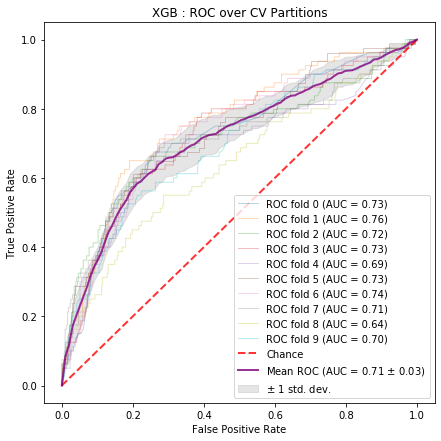

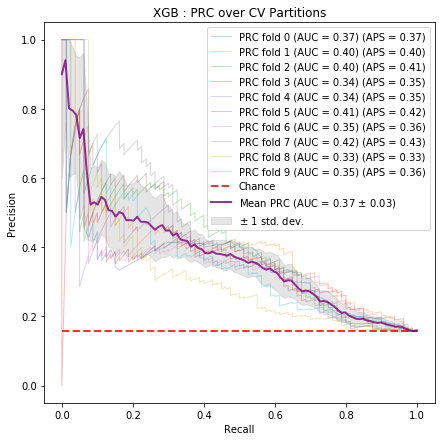

Avg. Model Balanced Accuracy = 0.6854248997126905 (std. dev. = 0.026138922690857703)
Avg. Model Accuracy = 0.7620493855695519 (std. dev. = 0.022277842314303794)
Avg. Model F1-Score = 0.43166574189647305 (std. dev. = 0.034434544168058)
Avg. Model Recall = 0.57375 (std. dev. = 0.03727012878968894)
Avg. Model Specificity = 0.7970997994253809 (std. dev. = 0.022125336195107127)
Avg. Model Precision = 0.346502252153725 (std. dev. = 0.03294671742723385)
Avg. Model True Positives = 45.9 (std. dev. = 2.981610303175115)
Avg. Model True Negatives = 342.6 (std. dev. = 9.73858305915188)
Avg. Model False Positives = 87.2 (std. dev. = 9.4424573072903)
Avg. Model False Negatives = 34.1 (std. dev. = 2.981610303175115)
Avg. ROC AUC = 0.7141444509947417 (std. dev. = 0.030366523984325565)
Avg. PRC AUC = 0.37189247744442555 (std. dev. = 0.031353108455863914)
Avg. PRC Precision Score = 0.3772635940152554 (std. dev. = 0.03112036168503492)

---Feature Importances---



Names    Scores
22            sex  0.075461
18          race7  0.034224
3      pack_years  0.009041
21        rndyear  0.008433
6      diabetes_f  0.008112
19  total_Marital  0.007762
10         bmi_50  0.007357
13     gallblad_f  0.007326
9          bmi_20  0.006992
1        cig_stop  0.006657
8       fh_cancer  0.006542
2       cig_years  0.006307
0        cig_stat  0.005712
5        bmi_curr  0.005509
12           ibup  0.005494
20         center  0.005322
7         panc_fh  0.005293
15            age  0.004844
11            asp  0.004799
4        bmi_curc  0.002094

XGBoost Run Time: 2685.6573197841644


In [56]:
algorithm = 'XGB'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('XGBoost Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run LGBoost

Running LGB
Best trial:
  Value:  0.6806125749985465
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 4
    max_depth: 11
    lambda_l1: 0.00768338761934432
    lambda_l2: 0.0005413558500340576
    feature_fraction: 0.717791465072565
    bagging_fraction: 0.8383559648289849
    bagging_freq: 7
    min_child_samples: 48
    n_estimators: 41
    scale_pos_weight: 5.372222222222222



Running LGB
Best trial:
  Value:  0.6803527738186164
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 2
    max_depth: 9
    lambda_l1: 0.00040068945383482326
    lambda_l2: 2.0069584681077582e-07
    feature_fraction: 0.9289858434387642
    bagging_fraction: 0.7726588301659502
    bagging_freq: 7
    min_child_samples: 68
    n_estimators: 115
    scale_pos_weight: 5.372222222222222



Running LGB
Best trial:
  Value:  0.6823914663531413
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 8
    max_depth: 13
    lambda_l1: 4.873620036546419
    lambda_l2: 9.2405986092081e-05
    feature_fraction: 0.46798717274812346
    bagging_fraction: 0.7449794063258433
    bagging_freq: 7
    min_child_samples: 9
    n_estimators: 40
    scale_pos_weight: 5.372222222222222



Running LGB
Best trial:
  Value:  0.6830536110559836
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 2
    max_depth: 13
    lambda_l1: 0.011307414470770143
    lambda_l2: 8.944833209541381e-07
    feature_fraction: 0.7779782710146178
    bagging_fraction: 0.7974194199285014
    bagging_freq: 2
    min_child_samples: 76
    n_estimators: 70
    scale_pos_weight: 5.372222222222222



Running LGB
Best trial:
  Value:  0.6839435578929643
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 82
    max_depth: 1
    lambda_l1: 0.0009472957582651204
    lambda_l2: 0.00044004644365977676
    feature_fraction: 0.5449743339796319
    bagging_fraction: 0.8679705849010112
    bagging_freq: 6
    min_child_samples: 57
    n_estimators: 93
    scale_pos_weight: 5.372222222222222



Running LGB
Best trial:
  Value:  0.6838615055237819
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 2
    max_depth: 12
    lambda_l1: 0.000192454768684358
    lambda_l2: 0.011899209685966892
    feature_fraction: 0.8882273184170065
    bagging_fraction: 0.8308486151186788
    bagging_freq: 7
    min_child_samples: 48
    n_estimators: 67
    scale_pos_weight: 5.372222222222222



Running LGB
Best trial:
  Value:  0.6827754549026448
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 109
    max_depth: 1
    lambda_l1: 0.00035224313190313134
    lambda_l2: 0.0004519442225888199
    feature_fraction: 0.5655600682025139
    bagging_fraction: 0.4252453488903947
    bagging_freq: 5
    min_child_samples: 28
    n_estimators: 127
    scale_pos_weight: 5.372222222222222



Running LGB
Best trial:
  Value:  0.6837137511200919
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 38
    max_depth: 1
    lambda_l1: 0.26236128411125315
    lambda_l2: 7.544294326864501e-07
    feature_fraction: 0.7178867649931066
    bagging_fraction: 0.46577449447389235
    bagging_freq: 3
    min_child_samples: 28
    n_estimators: 105
    scale_pos_weight: 5.372222222222222



Running LGB
Best trial:
  Value:  0.6936415866314652
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 20
    max_depth: 1
    lambda_l1: 0.0003679233531871612
    lambda_l2: 0.00026341868887385945
    feature_fraction: 0.6138553133842836
    bagging_fraction: 0.40699643275079084
    bagging_freq: 6
    min_child_samples: 45
    n_estimators: 69
    scale_pos_weight: 5.373611111111111



Running LGB
Best trial:
  Value:  0.6871495390333231
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    num_leaves: 2
    max_depth: 3
    lambda_l1: 0.0354762914868253
    lambda_l2: 1.4573987467470022e-05
    feature_fraction: 0.6109180447304533
    bagging_fraction: 0.5016928738695015
    bagging_freq: 7
    min_child_samples: 16
    n_estimators: 127
    scale_pos_weight: 5.373611111111111


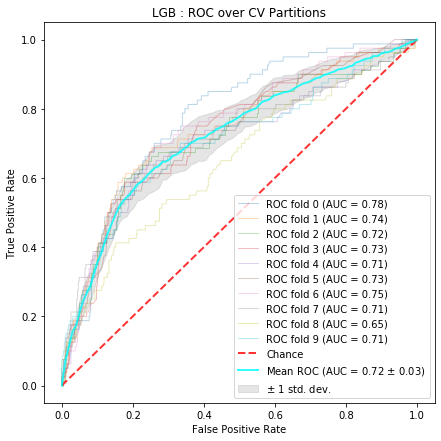

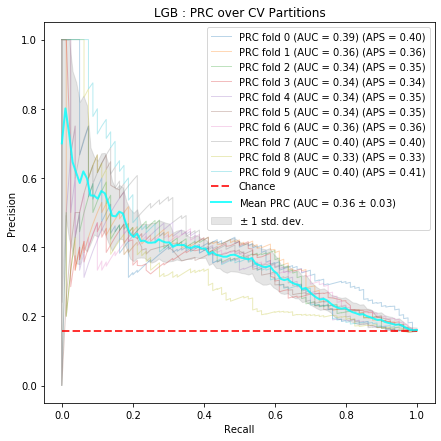

Avg. Model Balanced Accuracy = 0.6851081137854393 (std. dev. = 0.0280225676016413)
Avg. Model Accuracy = 0.7632300936091527 (std. dev. = 0.017612750516259948)
Avg. Model F1-Score = 0.43109367252278175 (std. dev. = 0.035708204114537866)
Avg. Model Recall = 0.5712500000000001 (std. dev. = 0.048104703512234656)
Avg. Model Specificity = 0.7989662275708787 (std. dev. = 0.015716124753949554)
Avg. Model Precision = 0.3464757592788621 (std. dev. = 0.030289157821115676)
Avg. Model True Positives = 45.7 (std. dev. = 3.848376280978772)
Avg. Model True Negatives = 343.4 (std. dev. = 6.974238309665077)
Avg. Model False Positives = 86.4 (std. dev. = 6.696267617113283)
Avg. Model False Negatives = 34.3 (std. dev. = 3.848376280978772)
Avg. ROC AUC = 0.7215693473193474 (std. dev. = 0.03176725906528118)
Avg. PRC AUC = 0.3602066152849159 (std. dev. = 0.026304809543192358)
Avg. PRC Precision Score = 0.36560797458585814 (std. dev. = 0.025921665072924083)

---Feature Importances---



Names    Scores
22                sex  0.078868
18              race7  0.021688
3          pack_years  0.007167
2           cig_years  0.006354
1            cig_stop  0.006192
20             center  0.006166
21            rndyear  0.005932
8           fh_cancer  0.005379
6          diabetes_f  0.004828
15                age  0.004711
13         gallblad_f  0.004639
10             bmi_50  0.004550
19      total_Marital  0.004056
7             panc_fh  0.003504
17             educat  0.002575
9              bmi_20  0.002414
0            cig_stat  0.002413
14  liver_comorbidity  0.002341
11                asp  0.002138
12               ibup  0.001949

LGBoost Run Time: 1002.0901114940643


In [57]:
algorithm = 'LGB'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('LGBoost Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run SVM

Running SVM
Best trial:
  Value:  0.6762077697792691
  Params: 
    kernel: rbf
    C: 0.1911772341732637
    gamma: scale
    degree: 1
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.6762413725360483
  Params: 
    kernel: rbf
    C: 0.33710253563410514
    gamma: scale
    degree: 1
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.6738041452922062
  Params: 
    kernel: rbf
    C: 0.3828280035654849
    gamma: scale
    degree: 6
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.6817788738140056
  Params: 
    kernel: rbf
    C: 0.33646189237823154
    gamma: scale
    degree: 5
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.6810083909165808
  Params: 
    kernel: rbf
    C: 0.5077079167429801
    gamma: scale
    degree: 5
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.6806338366981195
  Params: 
    kernel: rbf
    C: 0.179718837921994
    gamma: scale
    degree: 1
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.6827362266284182
  Params: 
    kernel: rbf
    C: 0.40131031441306136
    gamma: scale
    degree: 5
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.6847194533149707
  Params: 
    kernel: rbf
    C: 0.5466569557432683
    gamma: scale
    degree: 5
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.692144359547994
  Params: 
    kernel: rbf
    C: 0.2977854288972673
    gamma: scale
    degree: 5
    probability: True
    class_weight: balanced



Running SVM
Best trial:
  Value:  0.6837458253398365
  Params: 
    kernel: rbf
    C: 0.5268499092654428
    gamma: scale
    degree: 2
    probability: True
    class_weight: balanced


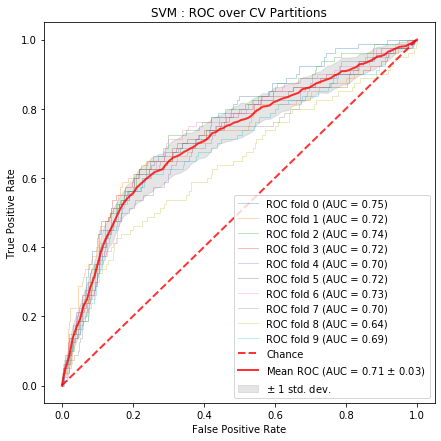

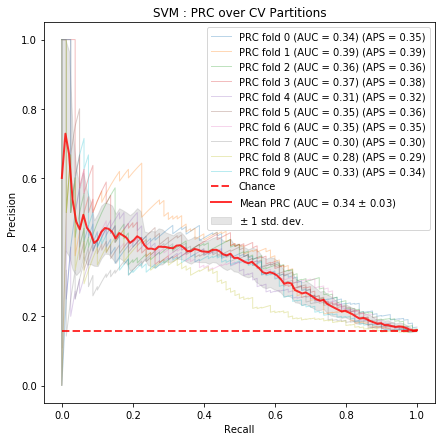

Avg. Model Balanced Accuracy = 0.6761296213476446 (std. dev. = 0.020709595807843848)
Avg. Model Accuracy = 0.7669609769251511 (std. dev. = 0.01619898213734307)
Avg. Model F1-Score = 0.42312601260565685 (std. dev. = 0.02822671512785828)
Avg. Model Recall = 0.54375 (std. dev. = 0.03365728004459065)
Avg. Model Specificity = 0.8085092426952892 (std. dev. = 0.016462054949893886)
Avg. Model Precision = 0.3467224217507967 (std. dev. = 0.027265099733782126)
Avg. Model True Positives = 43.5 (std. dev. = 2.692582403567252)
Avg. Model True Negatives = 347.5 (std. dev. = 7.214568594171102)
Avg. Model False Positives = 82.3 (std. dev. = 7.043436661176133)
Avg. Model False Negatives = 36.5 (std. dev. = 2.692582403567252)
Avg. ROC AUC = 0.7110055022496883 (std. dev. = 0.03025825420181418)
Avg. PRC AUC = 0.336469086806084 (std. dev. = 0.031819366018695845)
Avg. PRC Precision Score = 0.3431859597036212 (std. dev. = 0.03070722273179975)

---Feature Importances---



Names    Scores
22                sex  0.067411
18              race7  0.020772
6          diabetes_f  0.004883
19      total_Marital  0.004840
21            rndyear  0.004258
1            cig_stop  0.003677
10             bmi_50  0.003358
13         gallblad_f  0.002965
4            bmi_curc  0.002341
15                age  0.002034
5            bmi_curr  0.001948
2           cig_years  0.001918
14  liver_comorbidity  0.001831
9              bmi_20  0.001758
20             center  0.001569
12               ibup  0.001483
8           fh_cancer  0.001439
17             educat  0.001367
11                asp  0.001250
7             panc_fh  0.001134

SVM Run Time: 14065.45315861702


In [58]:
algorithm = 'SVM'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('SVM Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run ANN

Running ANN
Best trial:
  Value:  0.5708400739310765
  Params: 
    activation: tanh
    learning_rate: constant
    momentum: 0.7032986708712756
    solver: adam
    batch_size: auto
    alpha: 0.0001761515589182565
    max_iter: 200
    n_layers: 3
    n_units_l0: 33
    n_units_l1: 85
    n_units_l2: 29



Running ANN
Best trial:
  Value:  0.5812695828146331
  Params: 
    activation: relu
    learning_rate: invscaling
    momentum: 0.5848065307505798
    solver: adam
    batch_size: auto
    alpha: 0.0009316701944982453
    max_iter: 200
    n_layers: 3
    n_units_l0: 56
    n_units_l1: 85
    n_units_l2: 60



Running ANN
Best trial:
  Value:  0.5848591641057407
  Params: 
    activation: relu
    learning_rate: invscaling
    momentum: 0.5028733708300864
    solver: adam
    batch_size: auto
    alpha: 0.010030834399317852
    max_iter: 200
    n_layers: 2
    n_units_l0: 92
    n_units_l1: 21



Running ANN
Best trial:
  Value:  0.5909104542912299
  Params: 
    activation: tanh
    learning_rate: constant
    momentum: 0.24674783189293104
    solver: adam
    batch_size: auto
    alpha: 0.004128205343826225
    max_iter: 200
    n_layers: 3
    n_units_l0: 83
    n_units_l1: 87
    n_units_l2: 75



Running ANN
Best trial:
  Value:  0.59692502200091
  Params: 
    activation: relu
    learning_rate: adaptive
    momentum: 0.31865777832316955
    solver: adam
    batch_size: auto
    alpha: 0.025237035807340137
    max_iter: 200
    n_layers: 2
    n_units_l0: 83
    n_units_l1: 7



Running ANN
Best trial:
  Value:  0.5913266298214067
  Params: 
    activation: tanh
    learning_rate: constant
    momentum: 0.4113668194497794
    solver: adam
    batch_size: auto
    alpha: 0.048975344735162414
    max_iter: 200
    n_layers: 2
    n_units_l0: 47
    n_units_l1: 99



Running ANN
Best trial:
  Value:  0.5915102046134756
  Params: 
    activation: relu
    learning_rate: invscaling
    momentum: 0.39850288758025676
    solver: adam
    batch_size: auto
    alpha: 0.028213350546546834
    max_iter: 200
    n_layers: 2
    n_units_l0: 93
    n_units_l1: 37



Running ANN
Best trial:
  Value:  0.5863258956224703
  Params: 
    activation: relu
    learning_rate: constant
    momentum: 0.39657330428872223
    solver: adam
    batch_size: auto
    alpha: 0.005368967692462798
    max_iter: 200
    n_layers: 3
    n_units_l0: 52
    n_units_l1: 38
    n_units_l2: 24



Running ANN
Best trial:
  Value:  0.5853253929593077
  Params: 
    activation: tanh
    learning_rate: constant
    momentum: 0.3830760709856287
    solver: adam
    batch_size: auto
    alpha: 0.0046226856536736565
    max_iter: 200
    n_layers: 2
    n_units_l0: 94
    n_units_l1: 16



Running ANN
Best trial:
  Value:  0.5905398968212444
  Params: 
    activation: tanh
    learning_rate: constant
    momentum: 0.17920532045331036
    solver: adam
    batch_size: auto
    alpha: 0.00013243275977758927
    max_iter: 200
    n_layers: 3
    n_units_l0: 22
    n_units_l1: 40
    n_units_l2: 80


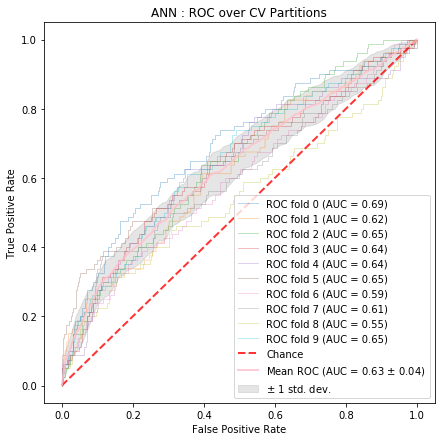

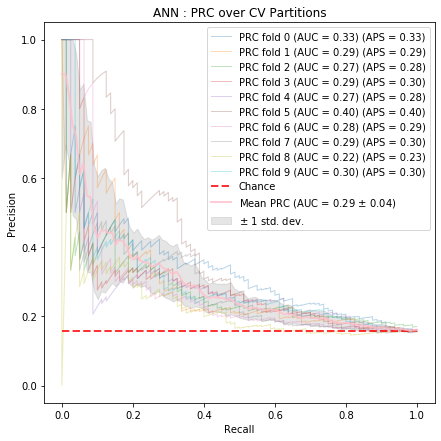

Avg. Model Balanced Accuracy = 0.5823919200954085 (std. dev. = 0.028508731173229482)
Avg. Model Accuracy = 0.8018837397434415 (std. dev. = 0.0221430406930008)
Avg. Model F1-Score = 0.2907697133380833 (std. dev. = 0.06158624787350398)
Avg. Model Recall = 0.26250000000000007 (std. dev. = 0.06937218462755805)
Avg. Model Specificity = 0.9022838401908169 (std. dev. = 0.03162071403947968)
Avg. Model Precision = 0.3380007208130943 (std. dev. = 0.07715620754199831)
Avg. Model True Positives = 21.0 (std. dev. = 5.549774770204643)
Avg. Model True Negatives = 387.8 (std. dev. = 13.555810562264435)
Avg. Model False Positives = 42.0 (std. dev. = 13.601470508735444)
Avg. Model False Negatives = 59.0 (std. dev. = 5.549774770204643)
Avg. ROC AUC = 0.6294597461646881 (std. dev. = 0.03789686829560999)
Avg. PRC AUC = 0.294821179579532 (std. dev. = 0.04292868166909015)
Avg. PRC Precision Score = 0.2994717628554461 (std. dev. = 0.04188312509897805)

---Feature Importances---



Names    Scores
22            sex  0.036846
21        rndyear  0.024236
8       fh_cancer  0.017979
19  total_Marital  0.017864
5        bmi_curr  0.016977
3      pack_years  0.016937
18          race7  0.016467
12           ibup  0.015769
2       cig_years  0.014897
20         center  0.014183
7         panc_fh  0.013692
1        cig_stop  0.012909
4        bmi_curc  0.012529
11            asp  0.010016
10         bmi_50  0.009842
0        cig_stat  0.009317
13     gallblad_f  0.008021
9          bmi_20  0.007951
15            age  0.007922
6      diabetes_f  0.007339

ANN Run Time: 4140.119745969772


In [59]:
algorithm = 'ANN'
if algorithm in algorithmsToRun:
    start_time = time.time()
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec, FI_ave = eval_Algorithm_FI(algorithm,ordered_feature_names,
        xTrainList,yTrainList,xTestList,yTestList,cv_partitions,global_ordered_features,wd_path,output_folder,
        data_name,randomSeed,param_grid,model_folder,algColor,hype_cv,n_trials,scoring_metric,timeout)
    
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)
    
    elapsed_time = time.time() - start_time
    print('ANN Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

## Run LCS

In [60]:
def makeConfigFile(train_dataset,test_dataset,outpath,external_ek_file,iterations,popsize,configfile,outcomelabel,instancelabel,discthresh):
    """ Construct Configuration File for CV Analysis """
    configFile = open(configfile,'w')
    
    #Write to Config File#############################################################################################################
    configFile.write('offlineData=1# \n')
    configFile.write('trainFile='+str(train_dataset)+'# \n')
    configFile.write('testFile='+str(test_dataset)+'# \n')
    configFile.write('internalCrossValidation=0# \n')
    
    configFile.write('outFileName='+str(outpath)+'# \n')
    configFile.write('randomSeed=1# \n')
    configFile.write('labelInstanceID='+str(instancelabel)+'# \n')
    configFile.write('labelPhenotype='+str(outcomelabel)+'# \n')
    configFile.write('discreteAttributeLimit='+str(discthresh)+'# \n')
    configFile.write('labelMissingData=NA# \n')
    configFile.write('outputSummary=1# \n')
    configFile.write('outputPopulation=1# \n')
    configFile.write('outputAttCoOccur=1# \n')
    configFile.write('outputTestPredictions=1# \n')  
    configFile.write('maxAttsCoOccur=50# \n')
        
    configFile.write('trackingFrequency=0# \n')
    configFile.write('learningIterations='+str(iterations)+'# \n')
    
    configFile.write('N='+str(popsize)+'# \n') 
    configFile.write('nu=1# \n')
    configFile.write('chi=0.8# \n')
    configFile.write('upsilon=0.04# \n')
    configFile.write('theta_GA=25# \n')
    configFile.write('theta_del=20# \n')   
    configFile.write('theta_sub=20# \n')    
    configFile.write('acc_sub=0.99# \n')    
    configFile.write('beta=0.2# \n')         
    configFile.write('delta=0.1# \n')     
    configFile.write('init_fit=0.01# \n')
    configFile.write('fitnessReduction=0.1# \n')
    configFile.write('theta_sel=0.5# \n')
    configFile.write('RSL_Override=0# \n')

    configFile.write('doSubsumption=1# \n')
    configFile.write('selectionMethod=tournament# \n')
    
    configFile.write('doAttributeTracking=1# \n')
    configFile.write('doAttributeFeedback=1# \n')
    
    configFile.write('useExpertKnowledge=1# \n')
    configFile.write('external_EK_Generation='+str(external_ek_file)+'# \n')
    configFile.write('outEKFileName=None# \n')
    
    configFile.write('filterAlgorithm=None# \n')
    configFile.write('turfPercent=0.2# \n')
    configFile.write('reliefNeighbors=10# \n')
    configFile.write('reliefSampleFraction=1# \n')
    configFile.write('onlyEKScores=0# \n')
    
    configFile.write('doRuleCompaction=1# \n')
    configFile.write('onlyRC=0# \n')
    configFile.write('ruleCompactionMethod=QRF# \n')
    
    configFile.write('doPopulationReboot=0# \n')
    configFile.write('popRebootIteration=0# \n')
    
    configFile.close()

### Generate LCS Configuration Files (needed to pass all run/hyperparamters)

In [61]:
algorithm = 'LCS'
if algorithm in algorithmsToRun:
    start_time = time.time()
    # Generate LCS configuration files (needed to pass all run/hyper parameters to LCS)
    for i in tqdm_notebook(range(cv_partitions), desc='1st loop'):
        trainFile = wd_path+cv_data_folder+'/'+data_name+'_'+str(i)+'_Train.txt'
        testFile = wd_path+cv_data_folder+'/'+data_name+'_'+str(i)+'_Test.txt'
        ekFile = wd_path+output_folder+'/'+'multisurf'+'_'+data_name+'_'+str(i)+'_Train.txt'
        configfile = wd_path+lcs_folder+'/'+lcs_alg+'_'+data_name+'_'+str(i)+'_Train_ConfigFile.txt'
        outFold = wd_path+lcs_folder+'/'

        makeConfigFile(trainFile,testFile,outFold,ekFile,iterations,popsize,configfile,outcomeLabel,instLabel,categoricalCutoff)

In [62]:
algorithm = 'LCS'
if algorithm in algorithmsToRun:
    #Use Python Magic to run Exstracs from command line
    for i in tqdm_notebook(range(cv_partitions), desc='1st loop'):
        #lcs_path = 'exstracs_2.0.2.1_noclassmutate_lynch'+'/'+'exstracs_main.py'
        configFile = wd_path+lcs_folder+'/'+lcs_alg+'_'+data_name+'_'+str(i)+'_Train_ConfigFile.txt'
        %run {lcs_path} {configFile}

----------------------------------------------------------------------------
Environment: Formatting Data... 
DataManagement: Loading Data... C:/home/work/research_urbslab/ml_pipe/lynch_ml_pipe_biclass/ml_pipe_biclass_EpiOnly/cv_datasets/EpiOnly_20180710_clean_scale_imp_CV_S_FS_0_Train.txt
DataManagement: Instance ID Column location = 1
DataManagement: Phenotype Column Location = 0
DataManagement: Number of Attributes = 20
DataManagement: Number of Instances = 4588
DataManagement: Loading Data... C:/home/work/research_urbslab/ml_pipe/lynch_ml_pipe_biclass/ml_pipe_biclass_EpiOnly/cv_datasets/EpiOnly_20180710_clean_scale_imp_CV_S_FS_0_Test.txt
DataManagement: Number of Attributes = 20
DataManagement: Number of Instances = 510
DataManagement: Analyzing Phenotype...
DataManagement: Phenotype Detected as Discrete.
DataManagement: Detecting Classes...
DataManagement: Following Classes Detected:
['0', '1']
Class: 0 count = 3868
Class: 1 count = 720
{'0': 0.15693112467306014, '1': 0.8430688753

Epoch: 18	 Iteration: 82584	 MacroPop: 1810	 MicroPop: 2000	 AccEstimate: 0.803182214472537	 AveGen: 0.7780499999999987	 ExpRules: 0.269060773480663	 Time: 10.074831489721934
Epoch: 19	 Iteration: 87172	 MacroPop: 1811	 MicroPop: 2000	 AccEstimate: 0.8027462946817786	 AveGen: 0.7714750000000004	 ExpRules: 0.28437327443401433	 Time: 10.613552169005077
Epoch: 20	 Iteration: 91760	 MacroPop: 1843	 MicroPop: 2000	 AccEstimate: 0.8016564952048822	 AveGen: 0.767900000000002	 ExpRules: 0.2892023874118285	 Time: 11.173356374104818
Epoch: 21	 Iteration: 96348	 MacroPop: 1810	 MicroPop: 2000	 AccEstimate: 0.7968613775065388	 AveGen: 0.7723250000000005	 ExpRules: 0.29613259668508285	 Time: 11.699368826548259
Epoch: 22	 Iteration: 100936	 MacroPop: 1796	 MicroPop: 2000	 AccEstimate: 0.798823016564952	 AveGen: 0.7779499999999988	 ExpRules: 0.2989977728285078	 Time: 12.229045255978901
Epoch: 23	 Iteration: 105524	 MacroPop: 1825	 MicroPop: 2000	 AccEstimate: 0.7946817785527462	 AveGen: 0.78032499999

------------------------------------------------------------------------------------------------------------------------------------------------------
Running Population Evaluation after 200000 iterations.
-----------------------------------------------
TRAINING Accuracy Results:-------------
Instance Coverage = 100.0%
Prediction Ties = 0.0%
3673 out of 4588 instances covered and correctly classified.
Standard Accuracy (Adjusted) = 0.800566695727986
Balanced Accuracy (Adjusted) = 0.6483910109445188
-----------------------------------------------
TESTING Accuracy Results:-------------
Instance Coverage = 100.0%
Prediction Ties = 0.0%
399 out of 510 instances covered and correctly classified.
Standard Accuracy (Adjusted) = 0.7823529411764706
Balanced Accuracy (Adjusted) = 0.63229754129422
Writing Population Statistical Summary File...
Writing Population as Data File...
Calculating Attribute Co-occurence Scores...
Writing Attribute Co-occurence scores as data file...
Writing Attribute Tra

Epoch: 4	 Iteration: 18352	 MacroPop: 1894	 MicroPop: 2000	 AccEstimate: 0.7857454228421971	 AveGen: 0.768833333333353	 ExpRules: 0.2238648363252376	 Time: 1.949357016881307
Epoch: 5	 Iteration: 22940	 MacroPop: 1856	 MicroPop: 2000	 AccEstimate: 0.79359197907585	 AveGen: 0.7739047619047787	 ExpRules: 0.2273706896551724	 Time: 2.545868468284607
Epoch: 6	 Iteration: 27528	 MacroPop: 1886	 MicroPop: 2000	 AccEstimate: 0.8038360941586749	 AveGen: 0.7715952380952565	 ExpRules: 0.24125132555673381	 Time: 3.1296550154685976
Epoch: 7	 Iteration: 32116	 MacroPop: 1899	 MicroPop: 2000	 AccEstimate: 0.7979511769834351	 AveGen: 0.7596904761904946	 ExpRules: 0.20905739863085834	 Time: 3.7254171490669252
Epoch: 8	 Iteration: 36704	 MacroPop: 1834	 MicroPop: 2000	 AccEstimate: 0.7922842197035745	 AveGen: 0.7680476190476346	 ExpRules: 0.22737186477644494	 Time: 4.309470172723135
Epoch: 9	 Iteration: 41292	 MacroPop: 1897	 MicroPop: 2000	 AccEstimate: 0.7813862249346121	 AveGen: 0.7627857142857332	 Ex

Epoch: 31	 Iteration: 142228	 MacroPop: 1756	 MicroPop: 2000	 AccEstimate: 0.794463818657367	 AveGen: 0.778578947368429	 ExpRules: 0.31605922551252846	 Time: 16.910335834821066
Epoch: 32	 Iteration: 146816	 MacroPop: 1720	 MicroPop: 2000	 AccEstimate: 0.7964254577157803	 AveGen: 0.7779210526315852	 ExpRules: 0.3267441860465116	 Time: 17.432434483369192
Epoch: 33	 Iteration: 151404	 MacroPop: 1743	 MicroPop: 2000	 AccEstimate: 0.7783347863993025	 AveGen: 0.7735263157894813	 ExpRules: 0.31497418244406195	 Time: 17.945907111962637
Epoch: 34	 Iteration: 155992	 MacroPop: 1718	 MicroPop: 2000	 AccEstimate: 0.7948997384481256	 AveGen: 0.776236842105272	 ExpRules: 0.3160651920838184	 Time: 18.472236005465188
Epoch: 35	 Iteration: 160580	 MacroPop: 1736	 MicroPop: 2000	 AccEstimate: 0.8038360941586749	 AveGen: 0.7762631578947444	 ExpRules: 0.3392857142857143	 Time: 19.00697053670883
Epoch: 36	 Iteration: 165168	 MacroPop: 1700	 MicroPop: 2000	 AccEstimate: 0.7940278988666085	 AveGen: 0.7797894

Writing Predictions to File...
ExSTraCS Run Complete
----------------------------------------------------------------------------
Environment: Formatting Data... 
DataManagement: Loading Data... C:/home/work/research_urbslab/ml_pipe/lynch_ml_pipe_biclass/ml_pipe_biclass_EpiOnly/cv_datasets/EpiOnly_20180710_clean_scale_imp_CV_S_FS_7_Train.txt
DataManagement: Instance ID Column location = 1
DataManagement: Phenotype Column Location = 0
DataManagement: Number of Attributes = 19
DataManagement: Number of Instances = 4588
DataManagement: Loading Data... C:/home/work/research_urbslab/ml_pipe/lynch_ml_pipe_biclass/ml_pipe_biclass_EpiOnly/cv_datasets/EpiOnly_20180710_clean_scale_imp_CV_S_FS_7_Test.txt
DataManagement: Number of Attributes = 19
DataManagement: Number of Instances = 510
DataManagement: Analyzing Phenotype...
DataManagement: Phenotype Detected as Discrete.
DataManagement: Detecting Classes...
DataManagement: Following Classes Detected:
['0', '1']
Class: 0 count = 3868
Class: 1 cou

Epoch: 17	 Iteration: 78013	 MacroPop: 1834	 MicroPop: 2000	 AccEstimate: 0.7844846371758553	 AveGen: 0.7827380952381149	 ExpRules: 0.2589967284623773	 Time: 9.735279750823974
Epoch: 18	 Iteration: 82602	 MacroPop: 1813	 MicroPop: 2000	 AccEstimate: 0.802135541512312	 AveGen: 0.7865238095238287	 ExpRules: 0.27413127413127414	 Time: 10.296982570489247
Epoch: 19	 Iteration: 87191	 MacroPop: 1811	 MicroPop: 2000	 AccEstimate: 0.7890607975593811	 AveGen: 0.7850000000000188	 ExpRules: 0.26780784097183874	 Time: 10.850508987903595
Epoch: 20	 Iteration: 91780	 MacroPop: 1817	 MicroPop: 2000	 AccEstimate: 0.7908040967531053	 AveGen: 0.7849761904762097	 ExpRules: 0.2647220693450743	 Time: 11.40293620824814
Epoch: 21	 Iteration: 96369	 MacroPop: 1801	 MicroPop: 2000	 AccEstimate: 0.7982131183264328	 AveGen: 0.785761904761923	 ExpRules: 0.2876179900055525	 Time: 11.951549629370371
Epoch: 22	 Iteration: 100958	 MacroPop: 1787	 MicroPop: 2000	 AccEstimate: 0.7951623447374155	 AveGen: 0.785738095238

Epoch: 43	 Iteration: 197327	 MacroPop: 1668	 MicroPop: 2000	 AccEstimate: 0.8058400522989758	 AveGen: 0.7798157894736915	 ExpRules: 0.3435251798561151	 Time: 23.067880515257517
------------------------------------------------------------------------------------------------------------------------------------------------------
Running Population Evaluation after 200000 iterations.
-----------------------------------------------
TRAINING Accuracy Results:-------------
Instance Coverage = 100.0%
Prediction Ties = 0.0%
3721 out of 4589 instances covered and correctly classified.
Standard Accuracy (Adjusted) = 0.8108520374809327
Balanced Accuracy (Adjusted) = 0.6562838552710736
-----------------------------------------------
TESTING Accuracy Results:-------------
Instance Coverage = 100.0%
Prediction Ties = 0.0%
405 out of 509 instances covered and correctly classified.
Standard Accuracy (Adjusted) = 0.7956777996070727
Balanced Accuracy (Adjusted) = 0.6429249762583096
Writing Population St

<Figure size 432x288 with 0 Axes>

### Load and Evaluate LCS Predictions

Running LCS
Running LCS
Running LCS
Running LCS
Running LCS
Running LCS
Running LCS
Running LCS
Running LCS
Running LCS



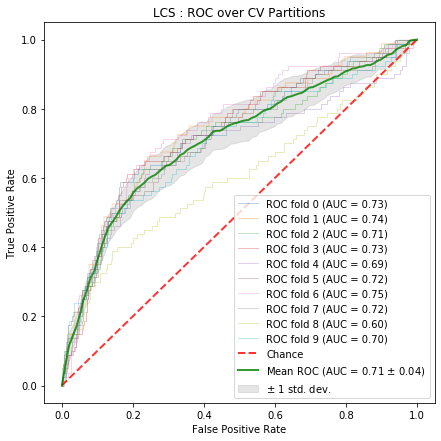

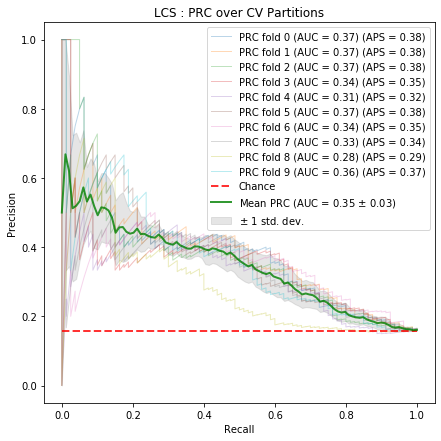

Avg. Model Balanced Accuracy = 0.6668098810104623 (std. dev. = 0.018115587895464445)
Avg. Model Accuracy = 0.7906991794753265 (std. dev. = 0.010445802340788868)
Avg. Model F1-Score = 0.42145237215443004 (std. dev. = 0.02562892626069966)
Avg. Model Recall = 0.48624999999999996 (std. dev. = 0.037687033579203326)
Avg. Model Specificity = 0.8473697620209248 (std. dev. = 0.012328977827719668)
Avg. Model Precision = 0.37255465461329146 (std. dev. = 0.02271618179657442)
Avg. Model True Positives = 38.9 (std. dev. = 3.014962686336267)
Avg. Model True Negatives = 364.2 (std. dev. = 5.344155686354955)
Avg. Model False Positives = 65.6 (std. dev. = 5.295280917949491)
Avg. Model False Negatives = 41.1 (std. dev. = 3.014962686336267)
Avg. ROC AUC = 0.7095524102835149 (std. dev. = 0.039573795983823136)
Avg. PRC AUC = 0.3463734857214786 (std. dev. = 0.02847604932396149)
Avg. PRC Precision Score = 0.35345778743182515 (std. dev. = 0.02810623265863676)
LCS Run Time: 13966.640100002289


In [63]:
algorithm = 'LCS'
if algorithm in algorithmsToRun:
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec = eval_LCS(algorithm,cv_partitions,wd_path,output_folder,lcs_folder,data_name,iterations,algColor)
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))
    
    elapsed_time = time.time() - start_time
    print('LCS Run Time: '+ str(elapsed_time))
    run_time_dict[algorithm] = elapsed_time

### Load and Evaluate LCS with QRF Predictions

Running LCS_QRF
Running LCS_QRF
Running LCS_QRF
Running LCS_QRF
Running LCS_QRF
Running LCS_QRF
Running LCS_QRF
Running LCS_QRF
Running LCS_QRF
Running LCS_QRF



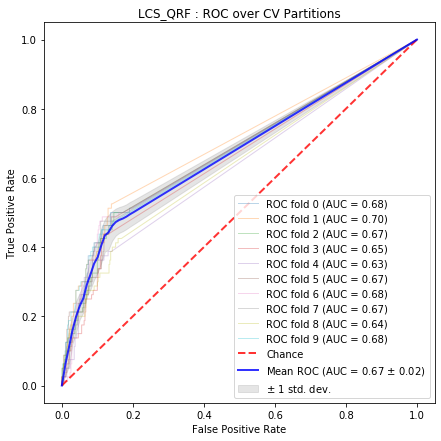

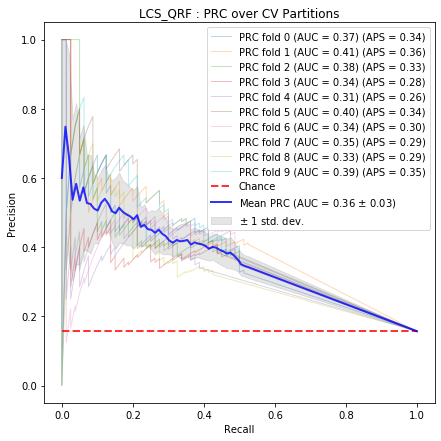

Avg. Model Balanced Accuracy = 0.5579034531360113 (std. dev. = 0.015532534958922862)
Avg. Model Accuracy = 0.8446477137023768 (std. dev. = 0.007631685960226209)
Avg. Model F1-Score = 0.21876695645071198 (std. dev. = 0.04612025767250138)
Avg. Model Recall = 0.14 (std. dev. = 0.03391164991562634)
Avg. Model Specificity = 0.9758069062720226 (std. dev. = 0.009760970652339397)
Avg. Model Precision = 0.5292605872388482 (std. dev. = 0.08618322021285812)
Avg. Model True Positives = 11.2 (std. dev. = 2.7129319932501073)
Avg. Model True Negatives = 419.4 (std. dev. = 4.029888335921977)
Avg. Model False Positives = 10.4 (std. dev. = 4.2)
Avg. Model False Negatives = 68.8 (std. dev. = 2.7129319932501077)
Avg. ROC AUC = 0.667180334200683 (std. dev. = 0.019488526194215386)
Avg. PRC AUC = 0.36130691416546645 (std. dev. = 0.03198987375041511)
Avg. PRC Precision Score = 0.31354090046585054 (std. dev. = 0.03182256105787175)


In [64]:
algorithm = 'LCS_QRF'
if algorithm in algorithmsToRun:
    algColor = algColors[algorithmsToRun.index(algorithm)]
    mean_fpr, mean_tpr, mean_auc, mean_prec, mean_pr_auc, mean_ave_prec = eval_LCS_QRF(algorithm,cv_partitions,wd_path,output_folder,lcs_folder,data_name,iterations,algColor)
    result_dict = {'algorithm':algorithm,'fpr':mean_fpr, 'tpr':mean_tpr, 'auc':mean_auc, 'prec':mean_prec, 'pr_auc':mean_pr_auc, 'ave_prec':mean_ave_prec}
    pickle.dump(result_dict, open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'wb'))

### Load and Evaluate LCS Feature Importance Estimates

In [65]:
algorithm = 'LCS'
if algorithm in algorithmsToRun:
    FI_all = []
    FI_ave = [0]*len(ordered_feature_names) #Holds only the selected feature FI results for each partition
    
    #Gather all LCS feature importance results (specificity sums)
    for i in tqdm_notebook(range(cv_partitions), desc='1st loop'):
        scoreDict = {}
        fiFile = wd_path+lcs_folder+'/'+'ExSTraCS'+'_'+data_name+'_'+str(i)+'_Train_'+str(iterations)+'_PopStats.txt'
        fileObject = open(fiFile, 'r') 
        
        counter = 0
        tempList1 = []
        tempList2 = []
        for line in fileObject:
            if counter == 9:
                tempList1 = line.strip().split('\t')
            if counter == 10:
                tempList2 = line.strip().split('\t')
            counter += 1
        fileObject.close()
        
        for j in range(len(tempList1)):
            scoreDict[tempList1[j]] = float(tempList2[j])
 
        #Format feature importance scores as list (takes into account that all features are not in each CV partition)
        tempList = []
        j = 0
        for each in ordered_feature_names:
            if each in scoreDict:
                FI_ave[j] += float(scoreDict[each])
                tempList.append(float(scoreDict[each]))
            else:
                tempList.append(0)
            j += 1
            
        FI_all.append(tempList)
    
    
    dr = pd.DataFrame(FI_all)
    filepath = output_folder+'/'+algorithm+'_FI_'+data_name+'.csv'
    dr.to_csv(filepath, header=ordered_feature_names, index=False)  
    
    #Calculate Averages
    for i in range(0,len(FI_ave)):
        FI_ave[i] = FI_ave[i]/float(cv_partitions)
        
    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)



---Feature Importances---



Names  Scores
22                sex  1244.2
18              race7  1134.1
10             bmi_50   522.8
9              bmi_20   503.2
13         gallblad_f   494.8
3          pack_years   494.7
1            cig_stop   493.1
5            bmi_curr   482.4
8           fh_cancer   388.4
6          diabetes_f   379.2
7             panc_fh   376.3
2           cig_years   353.2
19      total_Marital   268.6
15                age   242.4
12               ibup   197.5
20             center   171.0
14  liver_comorbidity   133.6
0            cig_stat   130.1
21            rndyear   102.6
11                asp    82.6

### Load and Evaluate LCS with QRF Feature Importance Estimates

In [66]:
algorithm = 'LCS_QRF'
if algorithm in algorithmsToRun:
    FI_all = []
    FI_ave = [0]*len(ordered_feature_names) #Holds only the selected feature FI results for each partition
    
    #Gather all LCS feature importance results (specificity sums)
    for i in tqdm_notebook(range(cv_partitions), desc='1st loop'):
        scoreDict = {}
        fiFile = wd_path+lcs_folder+'/'+'ExSTraCS'+'_'+data_name+'_'+str(i)+'_Train_RC_QRF_'+str(iterations)+'_PopStats.txt'
        fileObject = open(fiFile, 'r') 
        
        counter = 0
        tempList1 = []
        tempList2 = []
        for line in fileObject:
            if counter == 9:
                tempList1 = line.strip().split('\t')
            if counter == 10:
                tempList2 = line.strip().split('\t')
            counter += 1
        fileObject.close()
        
        for j in range(len(tempList1)):
            scoreDict[tempList1[j]] = float(tempList2[j])
 
        #Format feature importance scores as list (takes into account that all features are not in each CV partition)
        tempList = []
        j = 0
        for each in ordered_feature_names:
            if each in scoreDict:
                FI_ave[j] += float(scoreDict[each])
                tempList.append(float(scoreDict[each]))
            else:
                tempList.append(0)
            j += 1
            
        FI_all.append(tempList)
    
    
    dr = pd.DataFrame(FI_all)
    filepath = output_folder+'/'+algorithm+'_FI_'+data_name+'.csv'
    dr.to_csv(filepath, header=ordered_feature_names, index=False)  
    
    #Calculate Averages
    for i in range(0,len(FI_ave)):
        FI_ave[i] = FI_ave[i]/float(cv_partitions)
        
    #Sort averages (decreasing order and print top 'n' and plot top 'n'
    names_scores = {'Names':ordered_feature_names, 'Scores':FI_ave} 
    ns = pd.DataFrame(names_scores)
    ns = ns.sort_values(by='Scores',ascending = False)

    #Select top 'n' to report and plot
    print("\n---Feature Importances---\n")
    ns.head(topResults)



---Feature Importances---



Names  Scores
22                sex   879.4
18              race7   847.2
1            cig_stop   369.3
10             bmi_50   341.6
13         gallblad_f   335.8
3          pack_years   335.6
9              bmi_20   320.8
5            bmi_curr   312.5
6          diabetes_f   257.1
7             panc_fh   242.7
8           fh_cancer   240.3
2           cig_years   231.1
19      total_Marital   187.5
15                age   146.2
20             center   135.4
12               ibup   120.6
14  liver_comorbidity    89.8
0            cig_stat    81.9
21            rndyear    65.9
11                asp    50.8

---
# Review result table (for global ROC and PRC figure building)

In [67]:
#Load pickle files of results
result_table = []

for algorithm in algorithmsToRun:
    tempDict = pickle.load(open(wd_path+model_folder+'/Results_'+algorithm+'.sav', 'rb'))
    result_table.append(tempDict)
    
result_table = pd.DataFrame.from_dict(result_table)

In [68]:
result_table
result_table.set_index('algorithm', inplace=True)

algorithm                                                fpr  \
0  logistic_regression  [0.0, 0.010101010101010102, 0.0202020202020202...   
1        decision_tree  [0.0, 0.010101010101010102, 0.0202020202020202...   
2        random_forest  [0.0, 0.010101010101010102, 0.0202020202020202...   
3          naive_bayes  [0.0, 0.010101010101010102, 0.0202020202020202...   
4                  XGB  [0.0, 0.010101010101010102, 0.0202020202020202...   
5                  LGB  [0.0, 0.010101010101010102, 0.0202020202020202...   
6                  SVM  [0.0, 0.010101010101010102, 0.0202020202020202...   
7                  ANN  [0.0, 0.010101010101010102, 0.0202020202020202...   
8                  LCS  [0.0, 0.010101010101010102, 0.0202020202020202...   
9              LCS_QRF  [0.0, 0.010101010101010102, 0.0202020202020202...   

                                                 tpr       auc  \
0  [0.0, 0.07749999999999999, 0.13374999999999998...  0.721111   
1  [0.0, 0.04869092635759302, 0.09010227076514955...  0.702384   
2  [0.0, 0.06499999999999999, 0.10625, 0.15375, 0...  0.714634   
3  [0.0, 0.06875, 0.10625, 0.155, 0.16875, 0.2112...  0.700240   
4  [0.0, 0.08375, 0.11749999999999998, 0.17124999...  0.714064   
5  [0.0, 0.07250000000000001, 0.11460858585858584...  0.721503   
6  [0.0, 0.05, 0.0825, 0.13625, 0.166250000000000...  0.711061   
7  [0.0, 0.07250000000000001, 0.09375, 0.12875, 0...  0.629457   
8  [0.0, 0.06, 0.11499999999999999, 0.1425, 0.168...  0.709583   
9  [0.0, 0.06124999999999999, 0.11125, 0.16125, 0...  0.667212   

                                                prec    pr_auc  ave_prec  
0  [1.0, 1.0, 0.8016955266955268, 0.7446127946127...  0.374349  0.379463  
1  [0.8, 0.6134270478768087, 0.5309634284597637, ...  0.342940  0.322007  
2  [0.7, 0.7942760942760942, 0.7026046176046177, ...  0.354309  0.360611  
3  [1.0, 0.9771043771043771, 0.9542087542087543, ...  0.357150  0.359304  
4  [0.9, 0.9404040404040405, 0.8013468013468014, ...  0.372264  0.377264  
5  [0.7, 0.8010101010101011, 0.7304040404040404, ...  0.360345  0.365608  
6  [0.6, 0.7279461279461279, 0.6701803751803752, ...  0.336379  0.343186  
7  [0.9, 0.9, 0.8410774410774412, 0.7534343434343...  0.294405  0.299472  
8  [0.5, 0.6683501683501684, 0.6202308802308802, ...  0.346442  0.353458  
9  [0.6, 0.7481481481481481, 0.6604769921436588, ...  0.361447  0.313541

---
# ROC Plot Summarizing Analysis

([<matplotlib.axis.XTick at 0x1ed97dad988>,
 <a list of 11 Text xticklabel objects>)

Text(0.5, 0, 'False Positive Rate')

([<matplotlib.axis.YTick at 0x1ed9ca45f08>,
 <a list of 11 Text yticklabel objects>)

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Comparing Algorithms: Testing Data with CV')

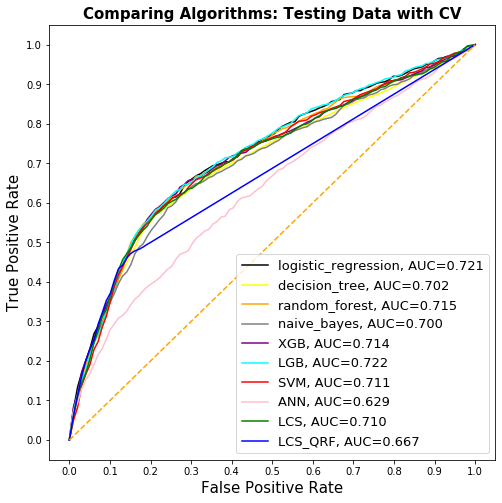

In [69]:
#Multi-algorithm ROC plot
fig = plt.figure(figsize=(8,8))
count = 0
for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], color = algColors[count],
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    count += 1
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('Comparing Algorithms: Testing Data with CV', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='best')
plt.savefig((wd_path+output_folder+'/'+'Compare_ROC_' + data_name), bbox_inches = "tight")
plt.show()


---
# PRC Plot Summarizing Analysis

([<matplotlib.axis.XTick at 0x1ed9c24c388>,
 <a list of 11 Text xticklabel objects>)

Text(0.5, 0, 'Recall')

([<matplotlib.axis.YTick at 0x1ed9c243648>,
 <a list of 11 Text yticklabel objects>)

Text(0, 0.5, 'Precision')

Text(0.5, 1.0, 'Comparing Algorithms: Testing Data with CV')

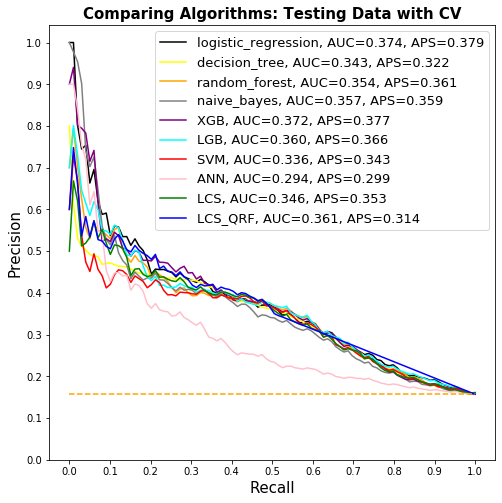

In [70]:
#Multi-algorithm PRC plot ['algorithm','fpr','tpr','auc','prec','pr_auc','ave_prec'])
#result_table.set_index('algorithm', inplace=True)

fig = plt.figure(figsize=(8,8))

count = 0
for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['prec'], color = algColors[count],
             label="{}, AUC={:.3f}, APS={:.3f}".format(i, result_table.loc[i]['pr_auc'],result_table.loc[i]['ave_prec']))
    count += 1
noskill = len(yTestList[0][yTestList[0]==1]) / len(yTestList[0]) #Fraction of cases
plt.plot([0,1], [noskill,noskill], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Recall", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("Precision", fontsize=15)

plt.title('Comparing Algorithms: Testing Data with CV', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='best')
plt.savefig((wd_path+output_folder+'/'+'Compare_PRC_' + data_name), bbox_inches = "tight")
plt.show()


---
# Summarize Algorithm Metrics 

In [71]:
td = pd.read_csv(wd_path+output_folder+'/'+algorithmsToRun[0]+'_Metrics_'+data_name+'.csv')
metrics = list(td.columns.values.tolist()) 

metric_summary = pd.DataFrame(index=metrics,columns=algorithmsToRun)
master_list = []

for algorithm in algorithmsToRun:
    #Open file
    td = pd.read_csv(wd_path+output_folder+'/'+algorithm+'_Metrics_'+data_name+'.csv')
    master_list.append(td)
    for metric in metrics:
        ave = td[metric].mean()
        sd = td[metric].std()
        metric_summary.at[metric, algorithm] = str(round(ave,4))+' ('+str(round(sd,4))+')'
    
metric_summary.to_csv(wd_path+output_folder+'/'+'Summary_Algorithm_Metrics_'+data_name+'.csv')   

In [72]:
metric_summary

logistic_regression    decision_tree    random_forest  \
Balanced Accuracy     0.6795 (0.0328)  0.6745 (0.0262)    0.6798 (0.03)   
Accuracy              0.7538 (0.0235)  0.7581 (0.0268)  0.7646 (0.0269)   
F1_Score               0.4221 (0.042)  0.4183 (0.0352)    0.4272 (0.04)   
Recall                0.5713 (0.0483)  0.5525 (0.0506)  0.5563 (0.0369)   
Specificity           0.7878 (0.0201)   0.7964 (0.033)   0.8034 (0.026)   
Precision              0.335 (0.0371)  0.3381 (0.0354)  0.3471 (0.0383)   
TP                      45.7 (3.8601)    44.2 (4.0497)    44.5 (2.9533)   
TN                     338.6 (8.7838)  342.3 (14.2443)  345.3 (11.4217)   
FP                      91.2 (8.5997)   87.5 (14.1755)    84.5 (11.078)   
FN                      34.3 (3.8601)    35.8 (4.0497)    35.5 (2.9533)   
ROC_AUC               0.7211 (0.0444)  0.7025 (0.0251)  0.7146 (0.0352)   
PRC_AUC               0.3744 (0.0245)   0.3427 (0.033)  0.3545 (0.0359)   
PRC_APS               0.3795 (0.0246)   0.322 (0.0295)  0.3606 (0.0349)   

                       naive_bayes              XGB              LGB  \
Balanced Accuracy   0.6053 (0.024)  0.6854 (0.0276)  0.6851 (0.0295)   
Accuracy           0.8217 (0.0152)   0.762 (0.0235)  0.7632 (0.0186)   
F1_Score           0.3383 (0.0474)  0.4317 (0.0363)  0.4311 (0.0376)   
Recall                0.29 (0.039)  0.5737 (0.0393)  0.5713 (0.0507)   
Specificity        0.9207 (0.0123)  0.7971 (0.0233)   0.799 (0.0166)   
Precision           0.407 (0.0641)  0.3465 (0.0347)  0.3465 (0.0319)   
TP                   23.2 (3.1198)    45.9 (3.1429)    45.7 (4.0565)   
TN                  395.7 (5.3965)  342.6 (10.2654)   343.4 (7.3515)   
FP                   34.1 (5.2589)    87.2 (9.9532)    86.4 (7.0585)   
FN                   56.8 (3.1198)    34.1 (3.1429)    34.3 (4.0565)   
ROC_AUC            0.7004 (0.0301)   0.7141 (0.032)  0.7216 (0.0335)   
PRC_AUC            0.3573 (0.0222)   0.3719 (0.033)  0.3602 (0.0277)   
PRC_APS            0.3593 (0.0235)  0.3773 (0.0328)  0.3656 (0.0273)   

                               SVM              ANN              LCS  \
Balanced Accuracy  0.6761 (0.0218)  0.5824 (0.0301)  0.6668 (0.0191)   
Accuracy            0.767 (0.0171)  0.8019 (0.0233)   0.7907 (0.011)   
F1_Score           0.4231 (0.0298)  0.2908 (0.0649)   0.4215 (0.027)   
Recall             0.5438 (0.0355)  0.2625 (0.0731)  0.4862 (0.0397)   
Specificity        0.8085 (0.0174)  0.9023 (0.0333)   0.8474 (0.013)   
Precision          0.3467 (0.0287)   0.338 (0.0813)  0.3726 (0.0239)   
TP                   43.5 (2.8382)      21.0 (5.85)     38.9 (3.178)   
TN                  347.5 (7.6048)  387.8 (14.2891)   364.2 (5.6332)   
FP                   82.3 (7.4244)   42.0 (14.3372)    65.6 (5.5817)   
FN                   36.5 (2.8382)      59.0 (5.85)     41.1 (3.178)   
ROC_AUC             0.711 (0.0319)  0.6295 (0.0399)  0.7096 (0.0417)   
PRC_AUC            0.3365 (0.0335)  0.2948 (0.0453)    0.3464 (0.03)   
PRC_APS            0.3432 (0.0324)  0.2995 (0.0441)  0.3535 (0.0296)   

                           LCS_QRF  
Balanced Accuracy  0.5579 (0.0164)  
Accuracy            0.8446 (0.008)  
F1_Score           0.2188 (0.0486)  
Recall               0.14 (0.0357)  
Specificity        0.9758 (0.0103)  
Precision          0.5293 (0.0908)  
TP                   11.2 (2.8597)  
TN                  419.4 (4.2479)  
FP                   10.4 (4.4272)  
FN                   68.8 (2.8597)  
ROC_AUC            0.6672 (0.0205)  
PRC_AUC            0.3613 (0.0337)  
PRC_APS            0.3135 (0.0335)

---
# Performance Metric Boxplots Comparing Algorithms

Text(0.5, 1.0, 'Comparing Algorithm Balanced Accuracy')

Text(0, 0.5, 'Balanced Accuracy')

Text(0.5, 0, 'ML Algorithm')

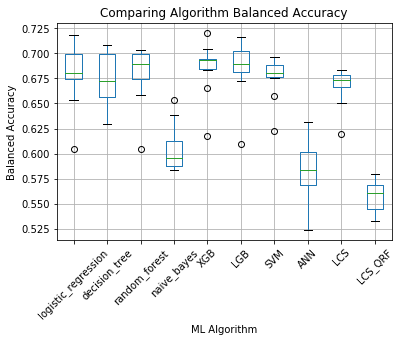

Text(0.5, 1.0, 'Comparing Algorithm Accuracy')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'ML Algorithm')

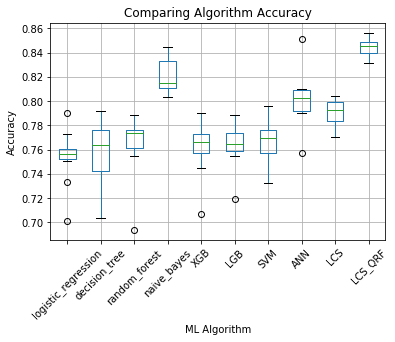

Text(0.5, 1.0, 'Comparing Algorithm F1_Score')

Text(0, 0.5, 'F1_Score')

Text(0.5, 0, 'ML Algorithm')

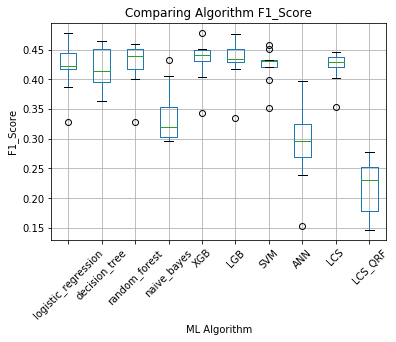

Text(0.5, 1.0, 'Comparing Algorithm Recall')

Text(0, 0.5, 'Recall')

Text(0.5, 0, 'ML Algorithm')

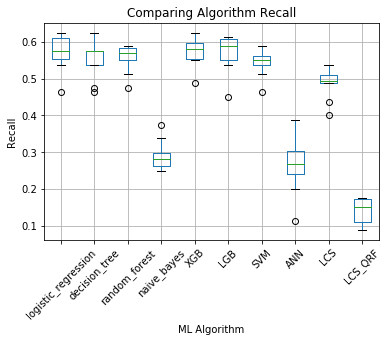

Text(0.5, 1.0, 'Comparing Algorithm Specificity')

Text(0, 0.5, 'Specificity')

Text(0.5, 0, 'ML Algorithm')

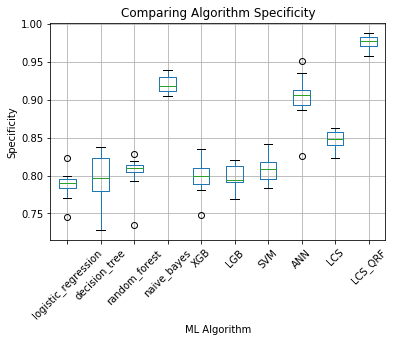

Text(0.5, 1.0, 'Comparing Algorithm Precision')

Text(0, 0.5, 'Precision')

Text(0.5, 0, 'ML Algorithm')

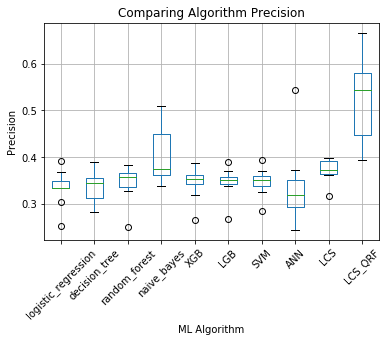

Text(0.5, 1.0, 'Comparing Algorithm TP')

Text(0, 0.5, 'TP')

Text(0.5, 0, 'ML Algorithm')

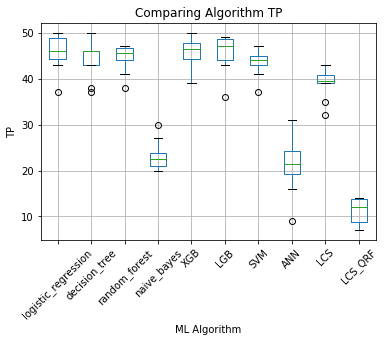

Text(0.5, 1.0, 'Comparing Algorithm TN')

Text(0, 0.5, 'TN')

Text(0.5, 0, 'ML Algorithm')

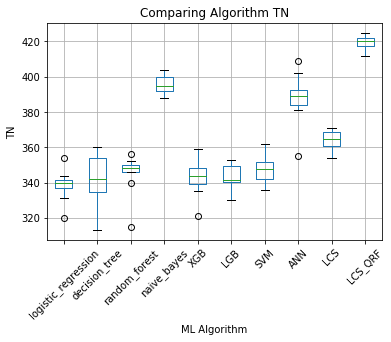

Text(0.5, 1.0, 'Comparing Algorithm FP')

Text(0, 0.5, 'FP')

Text(0.5, 0, 'ML Algorithm')

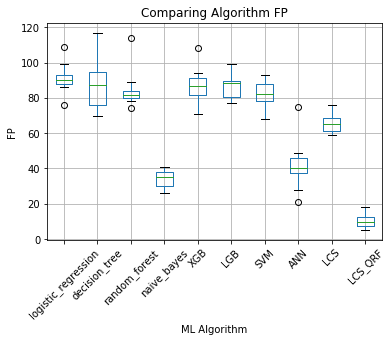

Text(0.5, 1.0, 'Comparing Algorithm FN')

Text(0, 0.5, 'FN')

Text(0.5, 0, 'ML Algorithm')

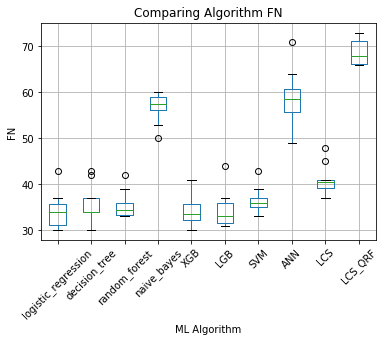

Text(0.5, 1.0, 'Comparing Algorithm ROC_AUC')

Text(0, 0.5, 'ROC_AUC')

Text(0.5, 0, 'ML Algorithm')

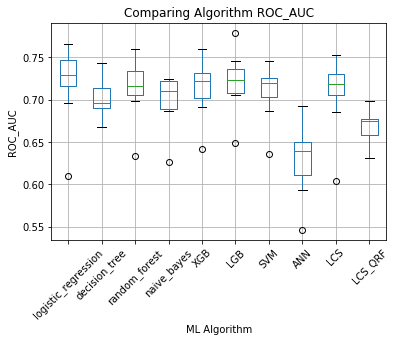

Text(0.5, 1.0, 'Comparing Algorithm PRC_AUC')

Text(0, 0.5, 'PRC_AUC')

Text(0.5, 0, 'ML Algorithm')

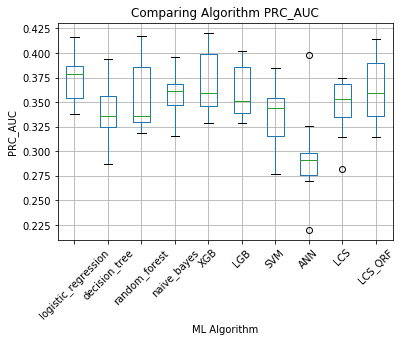

Text(0.5, 1.0, 'Comparing Algorithm PRC_APS')

Text(0, 0.5, 'PRC_APS')

Text(0.5, 0, 'ML Algorithm')

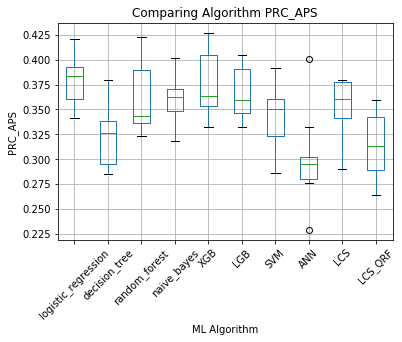

In [73]:

#For each metric
for metric in metrics:
    i = 0
    tempList = []
    for algorithm in algorithmsToRun:
        temp_td = master_list[i]
        tempList.append(temp_td[metric].tolist())
        i += 1
        
    td = pd.DataFrame(tempList)
    td = td.transpose()
    td.columns = algorithmsToRun
        
    boxplot = td.boxplot(column=algorithmsToRun,rot=45)
    plt.title('Comparing Algorithm '+ str(metric))
    plt.ylabel(str(metric))
    plt.xlabel('ML Algorithm')
    plt.savefig((wd_path+output_folder+'/'+'Compare_'+str(metric)+'_Boxplot_'+data_name), bbox_inches = "tight")
    plt.show()


---
# Statistical Comparisons
- Kruskal Wallis AOV comparing ML algorithms
- Mann-Whitney U test - Pairwise algorithm differences  

## Kruskal Wallis Test - Algorithm comparisons for each metric
- Are any algorithms performing statistically better or worse? 

## Mann-Whiney Test - Pairwise Post-Hoc Analysis 
- For any metric where kruskal wallis test was significant.

In [74]:
if len(algorithmsToRun) > 1:
    label = ['statistic','pvalue','sig']
    kruskal_summary = pd.DataFrame(index=metrics,columns=label)
    for metric in metrics:
        tempArray = []
        for i in range(len(algorithmsToRun)):
            tempArray.append(master_list[i][metric])
        result = stats.kruskal(*tempArray)
        #result = stats.kruskal(master_list[0][metric],master_list[1][metric],master_list[2][metric],master_list[3][metric],master_list[4][metric],master_list[5][metric],master_list[6][metric]) 
        kruskal_summary.at[metric, 'statistic'] = str(round(result[0],6))
        kruskal_summary.at[metric, 'pvalue'] = str(round(result[1],6))
        if result[1] < sig_cutoff:
            kruskal_summary.at[metric, 'sig'] = str('*')
        else:
            kruskal_summary.at[metric, 'sig'] = str('')

    kruskal_summary

    kruskal_summary.to_csv(wd_path+output_folder+'/'+'Summary_Algorithm_KruskalWallis_'+data_name+'.csv')   

statistic    pvalue sig
Balanced Accuracy  64.453132       0.0   *
Accuracy           68.086768       0.0   *
F1_Score            58.28693       0.0   *
Recall             74.631531       0.0   *
Specificity        77.455916       0.0   *
Precision          42.387527     3e-06   *
TP                 74.631531       0.0   *
TN                 77.355986       0.0   *
FP                 77.499832       0.0   *
FN                 74.631531       0.0   *
ROC_AUC            38.118178   1.7e-05   *
PRC_AUC             25.70305  0.002284   *
PRC_APS            39.850931     8e-06   *

In [75]:
if len(algorithmsToRun) > 1:
    algCount = len(algorithmsToRun)
    for metric in metrics:
        if kruskal_summary['sig'][metric] == '*':
            mann_stats = []
            #Balanced Accuracy
            for i in range(0,algCount-1):
                for j in range(i+1,algCount):
                    set1 = master_list[i][metric]
                    set2 = master_list[j][metric]

                    #print('Mann-WhitneyU: '+str(algorithmsToRun[i])+' vs. '+str(algorithmsToRun[j]))
                    report = stats.mannwhitneyu(set1,set2)
                    #report
                    tempstats = [algorithmsToRun[i], algorithmsToRun[j], report[0], report[1], '']
                    if report[1] < sig_cutoff:
                        tempstats[4] = '*'
                    mann_stats.append(tempstats)

            mann_stats_df = pd.DataFrame(mann_stats)
            mann_stats_df.columns = ['Algorithm 1', 'Algorithm 2', 'statistic', 'p-value', 'sig']
            filepath = wd_path+output_folder+'/'+'MannWhitney_'+str(metric)+'_'+data_name+'.csv'
            mann_stats_df.to_csv(filepath, index = False) 
            mann_stats_df

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree       40.0  0.236255    
1   logistic_regression  random_forest       48.0  0.454844    
2   logistic_regression    naive_bayes        5.0  0.000383   *
3   logistic_regression            XGB       44.0  0.338735    
4   logistic_regression            LGB       41.0  0.260183    
5   logistic_regression            SVM       47.0  0.425026    
6   logistic_regression            ANN        3.0  0.000219   *
7   logistic_regression            LCS       29.0  0.060542    
8   logistic_regression        LCS_QRF        0.0  0.000091   *
9         decision_tree  random_forest       44.5  0.352676    
10        decision_tree    naive_bayes        3.0  0.000220   *
11        decision_tree            XGB       37.0  0.172352    
12        decision_tree            LGB       37.5  0.182083    
13        decision_tree            SVM       46.0  0.395668    
14        decision_tree            ANN        1.0  0.000123   *
15        decision_tree            LCS       44.0  0.338792    
16        decision_tree        LCS_QRF        0.0  0.000091   *
17        random_forest    naive_bayes        4.0  0.000291   *
18        random_forest            XGB       45.0  0.366865    
19        random_forest            LGB       42.0  0.285375    
20        random_forest            SVM       35.0  0.136518    
21        random_forest            ANN        3.0  0.000220   *
22        random_forest            LCS       25.0  0.032011   *
23        random_forest        LCS_QRF        0.0  0.000091   *
24          naive_bayes            XGB        2.0  0.000165   *
25          naive_bayes            LGB        4.0  0.000291   *
26          naive_bayes            SVM        2.0  0.000165   *
27          naive_bayes            ANN       23.0  0.022577   *
28          naive_bayes            LCS        3.0  0.000220   *
29          naive_bayes        LCS_QRF        0.0  0.000091   *
30                  XGB            LGB       48.5  0.469860    
31                  XGB            SVM       33.0  0.106147    
32                  XGB            ANN        1.0  0.000123   *
33                  XGB            LCS       18.0  0.008629   *
34                  XGB        LCS_QRF        0.0  0.000091   *
35                  LGB            SVM       31.5  0.086728    
36                  LGB            ANN        1.0  0.000123   *
37                  LGB            LCS       18.0  0.008629   *
38                  LGB        LCS_QRF        0.0  0.000091   *
39                  SVM            ANN        1.0  0.000123   *
40                  SVM            LCS       25.5  0.034769   *
41                  SVM        LCS_QRF        0.0  0.000091   *
42                  ANN            LCS        1.0  0.000123   *
43                  ANN        LCS_QRF       20.0  0.012874   *
44                  LCS        LCS_QRF        0.0  0.000091   *

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree       41.0  0.260026    
1   logistic_regression  random_forest       29.5  0.064996    
2   logistic_regression    naive_bayes        0.0  0.000089   *
3   logistic_regression            XGB       34.5  0.128062    
4   logistic_regression            LGB       32.0  0.092441    
5   logistic_regression            SVM       31.0  0.080670    
6   logistic_regression            ANN        6.0  0.000489   *
7   logistic_regression            LCS        5.5  0.000434   *
8   logistic_regression        LCS_QRF        0.0  0.000090   *
9         decision_tree  random_forest       40.5  0.247903    
10        decision_tree    naive_bayes        0.0  0.000089   *
11        decision_tree            XGB       42.5  0.298143    
12        decision_tree            LGB       45.5  0.380705    
13        decision_tree            SVM       41.5  0.272372    
14        decision_tree            ANN        8.0  0.000843   *
15        decision_tree            LCS       10.5  0.001587   *
16        decision_tree        LCS_QRF        0.0  0.000091   *
17        random_forest    naive_bayes        0.0  0.000089   *
18        random_forest            XGB       40.5  0.247659    
19        random_forest            LGB       42.0  0.284939    
20        random_forest            SVM       43.5  0.324643    
21        random_forest            ANN        8.0  0.000843   *
22        random_forest            LCS       11.0  0.001786   *
23        random_forest        LCS_QRF        0.0  0.000091   *
24          naive_bayes            XGB        0.0  0.000089   *
25          naive_bayes            LGB        0.0  0.000089   *
26          naive_bayes            SVM        0.0  0.000089   *
27          naive_bayes            ANN       16.0  0.005467   *
28          naive_bayes            LCS        1.0  0.000121   *
29          naive_bayes        LCS_QRF       10.5  0.001559   *
30                  XGB            LGB       48.5  0.469803    
31                  XGB            SVM       44.5  0.352358    
32                  XGB            ANN        8.5  0.000943   *
33                  XGB            LCS        8.5  0.000962   *
34                  XGB        LCS_QRF        0.0  0.000091   *
35                  LGB            SVM       44.0  0.338506    
36                  LGB            ANN        8.0  0.000843   *
37                  LGB            LCS        6.0  0.000497   *
38                  LGB        LCS_QRF        0.0  0.000091   *
39                  SVM            ANN       10.0  0.001378   *
40                  SVM            LCS       12.0  0.002263   *
41                  SVM        LCS_QRF        0.0  0.000090   *
42                  ANN            LCS       27.0  0.044186   *
43                  ANN        LCS_QRF        8.0  0.000846   *
44                  LCS        LCS_QRF        0.0  0.000091   *

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree       42.0  0.285303    
1   logistic_regression  random_forest       45.0  0.366817    
2   logistic_regression    naive_bayes       10.0  0.001408   *
3   logistic_regression            XGB       39.0  0.213591    
4   logistic_regression            LGB       39.0  0.213591    
5   logistic_regression            SVM       47.0  0.425026    
6   logistic_regression            ANN        4.0  0.000290   *
7   logistic_regression            LCS       49.0  0.484919    
8   logistic_regression        LCS_QRF        0.0  0.000091   *
9         decision_tree  random_forest       41.5  0.272599    
10        decision_tree    naive_bayes       10.0  0.001414   *
11        decision_tree            XGB       40.0  0.236338    
12        decision_tree            LGB       39.5  0.224761    
13        decision_tree            SVM       46.0  0.395668    
14        decision_tree            ANN        3.0  0.000220   *
15        decision_tree            LCS       46.0  0.395668    
16        decision_tree        LCS_QRF        0.0  0.000091   *
17        random_forest    naive_bayes        8.0  0.000853   *
18        random_forest            XGB       49.0  0.484925    
19        random_forest            LGB       49.0  0.484925    
20        random_forest            SVM       38.0  0.192337    
21        random_forest            ANN        3.0  0.000220   *
22        random_forest            LCS       36.0  0.153745    
23        random_forest        LCS_QRF        0.0  0.000091   *
24          naive_bayes            XGB        8.0  0.000853   *
25          naive_bayes            LGB        7.0  0.000657   *
26          naive_bayes            SVM        8.0  0.000853   *
27          naive_bayes            ANN       24.0  0.026951   *
28          naive_bayes            LCS        8.0  0.000853   *
29          naive_bayes        LCS_QRF        0.0  0.000091   *
30                  XGB            LGB       47.5  0.439892    
31                  XGB            SVM       36.0  0.153745    
32                  XGB            ANN        1.0  0.000123   *
33                  XGB            LCS       32.0  0.092938    
34                  XGB        LCS_QRF        0.0  0.000091   *
35                  LGB            SVM       37.5  0.182083    
36                  LGB            ANN        2.0  0.000165   *
37                  LGB            LCS       35.0  0.136518    
38                  LGB        LCS_QRF        0.0  0.000091   *
39                  SVM            ANN        1.0  0.000123   *
40                  SVM            LCS       49.5  0.500000    
41                  SVM        LCS_QRF        0.0  0.000091   *
42                  ANN            LCS        1.0  0.000123   *
43                  ANN        LCS_QRF       14.0  0.003642   *
44                  LCS        LCS_QRF        0.0  0.000091   *

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree       39.5  0.223213    
1   logistic_regression  random_forest       37.5  0.180355    
2   logistic_regression    naive_bayes        0.0  0.000088   *
3   logistic_regression            XGB       50.0  0.484822    
4   logistic_regression            LGB       49.0  0.484663    
5   logistic_regression            SVM       28.0  0.050687    
6   logistic_regression            ANN        0.0  0.000089   *
7   logistic_regression            LCS        8.5  0.000936   *
8   logistic_regression        LCS_QRF        0.0  0.000087   *
9         decision_tree  random_forest       47.0  0.423680    
10        decision_tree    naive_bayes        0.0  0.000083   *
11        decision_tree            XGB       35.5  0.142488    
12        decision_tree            LGB       33.0  0.102320    
13        decision_tree            SVM       39.0  0.210678    
14        decision_tree            ANN        0.0  0.000085   *
15        decision_tree            LCS       17.0  0.006653   *
16        decision_tree        LCS_QRF        0.0  0.000083   *
17        random_forest    naive_bayes        0.0  0.000086   *
18        random_forest            XGB       35.5  0.141746    
19        random_forest            LGB       32.0  0.087651    
20        random_forest            SVM       35.0  0.133786    
21        random_forest            ANN        0.0  0.000087   *
22        random_forest            LCS       10.0  0.001337   *
23        random_forest        LCS_QRF        0.0  0.000085   *
24          naive_bayes            XGB        0.0  0.000088   *
25          naive_bayes            LGB        0.0  0.000082   *
26          naive_bayes            SVM        0.0  0.000087   *
27          naive_bayes            ANN       38.0  0.190807    
28          naive_bayes            LCS        0.0  0.000086   *
29          naive_bayes        LCS_QRF        0.0  0.000086   *
30                  XGB            LGB       48.5  0.469326    
31                  XGB            SVM       24.5  0.028442   *
32                  XGB            ANN        0.0  0.000089   *
33                  XGB            LCS        6.5  0.000542   *
34                  XGB        LCS_QRF        0.0  0.000087   *
35                  LGB            SVM       26.0  0.035853   *
36                  LGB            ANN        0.0  0.000083   *
37                  LGB            LCS        9.0  0.001002   *
38                  LGB        LCS_QRF        0.0  0.000081   *
39                  SVM            ANN        0.0  0.000089   *
40                  SVM            LCS       11.0  0.001712   *
41                  SVM        LCS_QRF        0.0  0.000087   *
42                  ANN            LCS        0.0  0.000087   *
43                  ANN        LCS_QRF        7.0  0.000636   *
44                  LCS        LCS_QRF        0.0  0.000085   *

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree       37.0  0.171350    
1   logistic_regression  random_forest       20.0  0.012735   *
2   logistic_regression    naive_bayes        0.0  0.000089   *
3   logistic_regression            XGB       37.0  0.171624    
4   logistic_regression            LGB       33.5  0.112187    
5   logistic_regression            SVM       20.0  0.012569   *
6   logistic_regression            ANN        0.0  0.000089   *
7   logistic_regression            LCS        0.5  0.000103   *
8   logistic_regression        LCS_QRF        0.0  0.000089   *
9         decision_tree  random_forest       40.0  0.236088    
10        decision_tree    naive_bayes        0.0  0.000091   *
11        decision_tree            XGB       49.5  0.500000    
12        decision_tree            LGB       47.5  0.439802    
13        decision_tree            SVM       39.5  0.224761    
14        decision_tree            ANN        3.0  0.000220   *
15        decision_tree            LCS        4.5  0.000332   *
16        decision_tree        LCS_QRF        0.0  0.000091   *
17        random_forest    naive_bayes        0.0  0.000090   *
18        random_forest            XGB       34.0  0.120307    
19        random_forest            LGB       37.5  0.181540    
20        random_forest            SVM       49.0  0.484891    
21        random_forest            ANN        1.0  0.000122   *
22        random_forest            LCS        1.0  0.000122   *
23        random_forest        LCS_QRF        0.0  0.000091   *
24          naive_bayes            XGB        0.0  0.000090   *
25          naive_bayes            LGB        0.0  0.000090   *
26          naive_bayes            SVM        0.0  0.000091   *
27          naive_bayes            ANN       25.0  0.031961   *
28          naive_bayes            LCS        0.0  0.000090   *
29          naive_bayes        LCS_QRF        0.0  0.000091   *
30                  XGB            LGB       47.5  0.439825    
31                  XGB            SVM       34.0  0.120395    
32                  XGB            ANN        1.0  0.000122   *
33                  XGB            LCS        2.0  0.000163   *
34                  XGB        LCS_QRF        0.0  0.000091   *
35                  LGB            SVM       38.0  0.191709    
36                  LGB            ANN        0.0  0.000090   *
37                  LGB            LCS        0.0  0.000090   *
38                  LGB        LCS_QRF        0.0  0.000090   *
39                  SVM            ANN        1.0  0.000123   *
40                  SVM            LCS        3.5  0.000251   *
41                  SVM        LCS_QRF        0.0  0.000091   *
42                  ANN            LCS        9.0  0.001097   *
43                  ANN        LCS_QRF        0.0  0.000091   *
44                  LCS        LCS_QRF        0.0  0.000091   *

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree       47.0  0.424942    
1   logistic_regression  random_forest       38.0  0.191979    
2   logistic_regression    naive_bayes       11.0  0.001780   *
3   logistic_regression            XGB       36.0  0.153380    
4   logistic_regression            LGB       33.0  0.105803    
5   logistic_regression            SVM       36.0  0.153380    
6   logistic_regression            ANN       41.5  0.272296    
7   logistic_regression            LCS       16.0  0.005603   *
8   logistic_regression        LCS_QRF        0.0  0.000089   *
9         decision_tree  random_forest       37.5  0.182083    
10        decision_tree    naive_bayes       17.0  0.007010   *
11        decision_tree            XGB       42.0  0.285375    
12        decision_tree            LGB       41.5  0.272599    
13        decision_tree            SVM       41.0  0.260261    
14        decision_tree            ANN       40.0  0.236338    
15        decision_tree            LCS       18.0  0.008629   *
16        decision_tree        LCS_QRF        0.0  0.000091   *
17        random_forest    naive_bayes       22.0  0.018818   *
18        random_forest            XGB       45.0  0.366865    
19        random_forest            LGB       45.0  0.366865    
20        random_forest            SVM       41.0  0.260261    
21        random_forest            ANN       30.0  0.070233    
22        random_forest            LCS       23.0  0.022577   *
23        random_forest        LCS_QRF        0.0  0.000091   *
24          naive_bayes            XGB       22.0  0.018818   *
25          naive_bayes            LGB       18.0  0.008629   *
26          naive_bayes            SVM       18.0  0.008629   *
27          naive_bayes            ANN       17.0  0.007010   *
28          naive_bayes            LCS       43.0  0.311588    
29          naive_bayes        LCS_QRF       12.0  0.002286   *
30                  XGB            LGB       49.5  0.500000    
31                  XGB            SVM       48.0  0.454861    
32                  XGB            ANN       34.0  0.120661    
33                  XGB            LCS       21.0  0.015605   *
34                  XGB        LCS_QRF        0.0  0.000091   *
35                  LGB            SVM       48.5  0.469860    
36                  LGB            ANN       34.0  0.120661    
37                  LGB            LCS       18.0  0.008629   *
38                  LGB        LCS_QRF        0.0  0.000091   *
39                  SVM            ANN       35.0  0.136518    
40                  SVM            LCS       18.5  0.009532   *
41                  SVM        LCS_QRF        0.5  0.000105   *
42                  ANN            LCS       19.0  0.010567   *
43                  ANN        LCS_QRF        5.0  0.000383   *
44                  LCS        LCS_QRF        3.0  0.000219   *

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree       39.5  0.223213    
1   logistic_regression  random_forest       37.5  0.180355    
2   logistic_regression    naive_bayes        0.0  0.000088   *
3   logistic_regression            XGB       50.0  0.484822    
4   logistic_regression            LGB       49.0  0.484663    
5   logistic_regression            SVM       28.0  0.050687    
6   logistic_regression            ANN        0.0  0.000089   *
7   logistic_regression            LCS        8.5  0.000936   *
8   logistic_regression        LCS_QRF        0.0  0.000087   *
9         decision_tree  random_forest       47.0  0.423680    
10        decision_tree    naive_bayes        0.0  0.000083   *
11        decision_tree            XGB       35.5  0.142488    
12        decision_tree            LGB       33.0  0.102320    
13        decision_tree            SVM       39.0  0.210678    
14        decision_tree            ANN        0.0  0.000085   *
15        decision_tree            LCS       17.0  0.006653   *
16        decision_tree        LCS_QRF        0.0  0.000083   *
17        random_forest    naive_bayes        0.0  0.000086   *
18        random_forest            XGB       35.5  0.141746    
19        random_forest            LGB       32.0  0.087651    
20        random_forest            SVM       35.0  0.133786    
21        random_forest            ANN        0.0  0.000087   *
22        random_forest            LCS       10.0  0.001337   *
23        random_forest        LCS_QRF        0.0  0.000085   *
24          naive_bayes            XGB        0.0  0.000088   *
25          naive_bayes            LGB        0.0  0.000082   *
26          naive_bayes            SVM        0.0  0.000087   *
27          naive_bayes            ANN       38.0  0.190807    
28          naive_bayes            LCS        0.0  0.000086   *
29          naive_bayes        LCS_QRF        0.0  0.000086   *
30                  XGB            LGB       48.5  0.469326    
31                  XGB            SVM       24.5  0.028442   *
32                  XGB            ANN        0.0  0.000089   *
33                  XGB            LCS        6.5  0.000542   *
34                  XGB        LCS_QRF        0.0  0.000087   *
35                  LGB            SVM       26.0  0.035853   *
36                  LGB            ANN        0.0  0.000083   *
37                  LGB            LCS        9.0  0.001002   *
38                  LGB        LCS_QRF        0.0  0.000081   *
39                  SVM            ANN        0.0  0.000089   *
40                  SVM            LCS       11.0  0.001712   *
41                  SVM        LCS_QRF        0.0  0.000087   *
42                  ANN            LCS        0.0  0.000087   *
43                  ANN        LCS_QRF        7.0  0.000636   *
44                  LCS        LCS_QRF        0.0  0.000085   *

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree       36.5  0.161596    
1   logistic_regression  random_forest       21.5  0.016776   *
2   logistic_regression    naive_bayes        0.0  0.000088   *
3   logistic_regression            XGB       36.5  0.162054    
4   logistic_regression            LGB       33.0  0.105026    
5   logistic_regression            SVM       20.5  0.013827   *
6   logistic_regression            ANN        0.0  0.000089   *
7   logistic_regression            LCS        0.5  0.000103   *
8   logistic_regression        LCS_QRF        0.0  0.000089   *
9         decision_tree  random_forest       40.5  0.247740    
10        decision_tree    naive_bayes        0.0  0.000090   *
11        decision_tree            XGB       50.0  0.484897    
12        decision_tree            LGB       48.0  0.454725    
13        decision_tree            SVM       39.5  0.224675    
14        decision_tree            ANN        3.0  0.000219   *
15        decision_tree            LCS        5.0  0.000377   *
16        decision_tree        LCS_QRF        0.0  0.000090   *
17        random_forest    naive_bayes        0.0  0.000090   *
18        random_forest            XGB       34.0  0.120307    
19        random_forest            LGB       38.0  0.191619    
20        random_forest            SVM       49.0  0.484879    
21        random_forest            ANN        1.0  0.000122   *
22        random_forest            LCS        1.0  0.000122   *
23        random_forest        LCS_QRF        0.0  0.000090   *
24          naive_bayes            XGB        0.0  0.000090   *
25          naive_bayes            LGB        0.0  0.000089   *
26          naive_bayes            SVM        0.0  0.000090   *
27          naive_bayes            ANN       25.0  0.031811   *
28          naive_bayes            LCS        0.0  0.000090   *
29          naive_bayes        LCS_QRF        0.0  0.000090   *
30                  XGB            LGB       47.5  0.439825    
31                  XGB            SVM       34.5  0.128062    
32                  XGB            ANN        1.0  0.000122   *
33                  XGB            LCS        2.0  0.000163   *
34                  XGB        LCS_QRF        0.0  0.000090   *
35                  LGB            SVM       38.0  0.191709    
36                  LGB            ANN        0.0  0.000090   *
37                  LGB            LCS        0.0  0.000090   *
38                  LGB        LCS_QRF        0.0  0.000090   *
39                  SVM            ANN        1.0  0.000123   *
40                  SVM            LCS        3.5  0.000251   *
41                  SVM        LCS_QRF        0.0  0.000091   *
42                  ANN            LCS        9.0  0.001097   *
43                  ANN        LCS_QRF        0.0  0.000091   *
44                  LCS        LCS_QRF        0.0  0.000090   *

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree       37.0  0.171350    
1   logistic_regression  random_forest       20.0  0.012735   *
2   logistic_regression    naive_bayes        0.0  0.000089   *
3   logistic_regression            XGB       36.5  0.162054    
4   logistic_regression            LGB       33.0  0.105026    
5   logistic_regression            SVM       20.0  0.012569   *
6   logistic_regression            ANN        0.0  0.000089   *
7   logistic_regression            LCS        0.5  0.000103   *
8   logistic_regression        LCS_QRF        0.0  0.000089   *
9         decision_tree  random_forest       40.0  0.236088    
10        decision_tree    naive_bayes        0.0  0.000091   *
11        decision_tree            XGB       49.5  0.500000    
12        decision_tree            LGB       47.5  0.439802    
13        decision_tree            SVM       39.0  0.213504    
14        decision_tree            ANN        3.0  0.000220   *
15        decision_tree            LCS        4.5  0.000332   *
16        decision_tree        LCS_QRF        0.0  0.000091   *
17        random_forest    naive_bayes        0.0  0.000090   *
18        random_forest            XGB       34.0  0.120307    
19        random_forest            LGB       36.5  0.161963    
20        random_forest            SVM       49.0  0.484879    
21        random_forest            ANN        1.0  0.000122   *
22        random_forest            LCS        1.0  0.000122   *
23        random_forest        LCS_QRF        0.0  0.000091   *
24          naive_bayes            XGB        0.0  0.000090   *
25          naive_bayes            LGB        0.0  0.000090   *
26          naive_bayes            SVM        0.0  0.000091   *
27          naive_bayes            ANN       26.5  0.040762   *
28          naive_bayes            LCS        0.0  0.000090   *
29          naive_bayes        LCS_QRF        0.0  0.000091   *
30                  XGB            LGB       47.5  0.439825    
31                  XGB            SVM       34.0  0.120395    
32                  XGB            ANN        1.0  0.000122   *
33                  XGB            LCS        2.0  0.000163   *
34                  XGB        LCS_QRF        0.0  0.000091   *
35                  LGB            SVM       37.5  0.181449    
36                  LGB            ANN        0.0  0.000090   *
37                  LGB            LCS        0.0  0.000090   *
38                  LGB        LCS_QRF        0.0  0.000090   *
39                  SVM            ANN        1.0  0.000123   *
40                  SVM            LCS        3.5  0.000251   *
41                  SVM        LCS_QRF        0.0  0.000091   *
42                  ANN            LCS        9.0  0.001097   *
43                  ANN        LCS_QRF        0.0  0.000091   *
44                  LCS        LCS_QRF        0.0  0.000091   *

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree       39.5  0.223213    
1   logistic_regression  random_forest       37.5  0.180355    
2   logistic_regression    naive_bayes        0.0  0.000088   *
3   logistic_regression            XGB       50.0  0.484822    
4   logistic_regression            LGB       49.0  0.484663    
5   logistic_regression            SVM       28.0  0.050687    
6   logistic_regression            ANN        0.0  0.000089   *
7   logistic_regression            LCS        8.5  0.000936   *
8   logistic_regression        LCS_QRF        0.0  0.000087   *
9         decision_tree  random_forest       47.0  0.423680    
10        decision_tree    naive_bayes        0.0  0.000083   *
11        decision_tree            XGB       35.5  0.142488    
12        decision_tree            LGB       33.0  0.102320    
13        decision_tree            SVM       39.0  0.210678    
14        decision_tree            ANN        0.0  0.000085   *
15        decision_tree            LCS       17.0  0.006653   *
16        decision_tree        LCS_QRF        0.0  0.000083   *
17        random_forest    naive_bayes        0.0  0.000086   *
18        random_forest            XGB       35.5  0.141746    
19        random_forest            LGB       32.0  0.087651    
20        random_forest            SVM       35.0  0.133786    
21        random_forest            ANN        0.0  0.000087   *
22        random_forest            LCS       10.0  0.001337   *
23        random_forest        LCS_QRF        0.0  0.000085   *
24          naive_bayes            XGB        0.0  0.000088   *
25          naive_bayes            LGB        0.0  0.000082   *
26          naive_bayes            SVM        0.0  0.000087   *
27          naive_bayes            ANN       38.0  0.190807    
28          naive_bayes            LCS        0.0  0.000086   *
29          naive_bayes        LCS_QRF        0.0  0.000086   *
30                  XGB            LGB       48.5  0.469326    
31                  XGB            SVM       24.5  0.028442   *
32                  XGB            ANN        0.0  0.000089   *
33                  XGB            LCS        6.5  0.000542   *
34                  XGB        LCS_QRF        0.0  0.000087   *
35                  LGB            SVM       26.0  0.035853   *
36                  LGB            ANN        0.0  0.000083   *
37                  LGB            LCS        9.0  0.001002   *
38                  LGB        LCS_QRF        0.0  0.000081   *
39                  SVM            ANN        0.0  0.000089   *
40                  SVM            LCS       11.0  0.001712   *
41                  SVM        LCS_QRF        0.0  0.000087   *
42                  ANN            LCS        0.0  0.000087   *
43                  ANN        LCS_QRF        7.0  0.000636   *
44                  LCS        LCS_QRF        0.0  0.000085   *

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree       25.0  0.032011   *
1   logistic_regression  random_forest       40.0  0.236338    
2   logistic_regression    naive_bayes       26.0  0.037831   *
3   logistic_regression            XGB       40.0  0.236338    
4   logistic_regression            LGB       43.0  0.311588    
5   logistic_regression            SVM       35.0  0.136518    
6   logistic_regression            ANN        7.0  0.000657   *
7   logistic_regression            LCS       38.0  0.192337    
8   logistic_regression        LCS_QRF       11.0  0.001805   *
9         decision_tree  random_forest       32.0  0.092938    
10        decision_tree    naive_bayes       47.0  0.425053    
11        decision_tree            XGB       35.0  0.136518    
12        decision_tree            LGB       27.0  0.044487   *
13        decision_tree            SVM       32.0  0.092938    
14        decision_tree            ANN        3.0  0.000220   *
15        decision_tree            LCS       35.0  0.136518    
16        decision_tree        LCS_QRF       15.0  0.004554   *
17        random_forest    naive_bayes       40.0  0.236338    
18        random_forest            XGB       47.0  0.425053    
19        random_forest            LGB       43.0  0.311588    
20        random_forest            SVM       50.0  0.484925    
21        random_forest            ANN        6.0  0.000504   *
22        random_forest            LCS       49.0  0.484925    
23        random_forest        LCS_QRF       10.0  0.001414   *
24          naive_bayes            XGB       31.0  0.080986    
25          naive_bayes            LGB       27.0  0.044487   *
26          naive_bayes            SVM       38.0  0.192337    
27          naive_bayes            ANN        8.0  0.000853   *
28          naive_bayes            LCS       38.0  0.192337    
29          naive_bayes        LCS_QRF       13.0  0.002898   *
30                  XGB            LGB       43.0  0.311588    
31                  XGB            SVM       46.0  0.395668    
32                  XGB            ANN        5.0  0.000384   *
33                  XGB            LCS       49.0  0.484925    
34                  XGB        LCS_QRF       10.0  0.001414   *
35                  LGB            SVM       39.0  0.213678    
36                  LGB            ANN        4.0  0.000291   *
37                  LGB            LCS       44.0  0.338792    
38                  LGB        LCS_QRF        8.0  0.000853   *
39                  SVM            ANN        7.0  0.000657   *
40                  SVM            LCS       49.0  0.484925    
41                  SVM        LCS_QRF       10.0  0.001414   *
42                  ANN            LCS        9.0  0.001101   *
43                  ANN        LCS_QRF       19.0  0.010567   *
44                  LCS        LCS_QRF       11.0  0.001805   *

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree       24.0  0.026951   *
1   logistic_regression  random_forest       30.0  0.070233    
2   logistic_regression    naive_bayes       30.0  0.070233    
3   logistic_regression            XGB       46.0  0.395668    
4   logistic_regression            LGB       35.0  0.136518    
5   logistic_regression            SVM       17.0  0.007010   *
6   logistic_regression            ANN        8.0  0.000853   *
7   logistic_regression            LCS       22.0  0.018818   *
8   logistic_regression        LCS_QRF       35.0  0.136518    
9         decision_tree  random_forest       41.0  0.260261    
10        decision_tree    naive_bayes       32.0  0.092938    
11        decision_tree            XGB       24.0  0.026951   *
12        decision_tree            LGB       28.0  0.052055    
13        decision_tree            SVM       47.0  0.425053    
14        decision_tree            ANN       17.0  0.007010   *
15        decision_tree            LCS       43.0  0.311588    
16        decision_tree        LCS_QRF       33.0  0.106147    
17        random_forest    naive_bayes       41.0  0.260261    
18        random_forest            XGB       31.0  0.080986    
19        random_forest            LGB       37.0  0.172352    
20        random_forest            SVM       41.0  0.260261    
21        random_forest            ANN       11.0  0.001805   *
22        random_forest            LCS       49.0  0.484925    
23        random_forest        LCS_QRF       43.0  0.311588    
24          naive_bayes            XGB       41.0  0.260261    
25          naive_bayes            LGB       47.0  0.425053    
26          naive_bayes            SVM       31.0  0.080986    
27          naive_bayes            ANN       11.0  0.001805   *
28          naive_bayes            LCS       42.0  0.285375    
29          naive_bayes        LCS_QRF       47.0  0.425053    
30                  XGB            LGB       39.0  0.213678    
31                  XGB            SVM       25.0  0.032011   *
32                  XGB            ANN        7.0  0.000657   *
33                  XGB            LCS       33.0  0.106147    
34                  XGB        LCS_QRF       38.0  0.192337    
35                  LGB            SVM       33.0  0.106147    
36                  LGB            ANN        8.0  0.000853   *
37                  LGB            LCS       43.0  0.311588    
38                  LGB        LCS_QRF       48.0  0.454861    
39                  SVM            ANN       19.0  0.010567   *
40                  SVM            LCS       40.0  0.236338    
41                  SVM        LCS_QRF       33.0  0.106147    
42                  ANN            LCS       17.0  0.007010   *
43                  ANN        LCS_QRF       10.0  0.001414   *
44                  LCS        LCS_QRF       37.0  0.172352

Algorithm 1    Algorithm 2  statistic   p-value sig
0   logistic_regression  decision_tree        5.0  0.000384   *
1   logistic_regression  random_forest       33.0  0.106147    
2   logistic_regression    naive_bayes       30.0  0.070233    
3   logistic_regression            XGB       45.0  0.366865    
4   logistic_regression            LGB       35.0  0.136518    
5   logistic_regression            SVM       17.0  0.007010   *
6   logistic_regression            ANN        8.0  0.000853   *
7   logistic_regression            LCS       23.0  0.022577   *
8   logistic_regression        LCS_QRF        4.0  0.000291   *
9         decision_tree  random_forest       17.0  0.007010   *
10        decision_tree    naive_bayes       17.0  0.007010   *
11        decision_tree            XGB        9.0  0.001101   *
12        decision_tree            LGB       11.0  0.001805   *
13        decision_tree            SVM       30.0  0.070233    
14        decision_tree            ANN       29.0  0.060612    
15        decision_tree            LCS       23.0  0.022577   *
16        decision_tree        LCS_QRF       47.0  0.425053    
17        random_forest    naive_bayes       46.0  0.395668    
18        random_forest            XGB       32.0  0.092938    
19        random_forest            LGB       39.0  0.213678    
20        random_forest            SVM       41.0  0.260261    
21        random_forest            ANN       10.0  0.001414   *
22        random_forest            LCS       50.0  0.484925    
23        random_forest        LCS_QRF       23.0  0.022577   *
24          naive_bayes            XGB       39.0  0.213678    
25          naive_bayes            LGB       46.0  0.395668    
26          naive_bayes            SVM       35.0  0.136518    
27          naive_bayes            ANN       11.0  0.001805   *
28          naive_bayes            LCS       48.0  0.454861    
29          naive_bayes        LCS_QRF       12.0  0.002293   *
30                  XGB            LGB       37.0  0.172352    
31                  XGB            SVM       25.0  0.032011   *
32                  XGB            ANN        6.0  0.000504   *
33                  XGB            LCS       34.0  0.120661    
34                  XGB        LCS_QRF        8.0  0.000853   *
35                  LGB            SVM       32.0  0.092938    
36                  LGB            ANN        8.0  0.000853   *
37                  LGB            LCS       44.0  0.338792    
38                  LGB        LCS_QRF       11.0  0.001805   *
39                  SVM            ANN       18.0  0.008629   *
40                  SVM            LCS       39.0  0.213678    
41                  SVM        LCS_QRF       25.0  0.032011   *
42                  ANN            LCS       16.0  0.005665   *
43                  ANN        LCS_QRF       40.0  0.236338    
44                  LCS        LCS_QRF       17.0  0.007010   *

---
# Visualize Feature Importance Results Across Algorithms

## Specify dataset specific paths/names

In [76]:
figx = 24
figy = 12
    
#Feature names to use in the final publication figures
df = pd.read_csv(wd_path+output_folder+'/'+algorithmsToRun[0]+'_FI_'+data_name+'.csv')

printfeatureNames = list(df.columns)
print(printfeatureNames)

['cig_stat', 'cig_stop', 'cig_years', 'pack_years', 'bmi_curc', 'bmi_curr', 'diabetes_f', 'panc_fh', 'fh_cancer', 'bmi_20', 'bmi_50', 'asp', 'ibup', 'gallblad_f', 'liver_comorbidity', 'age', 'agelevel', 'educat', 'race7', 'total_Marital', 'center', 'rndyear', 'sex']


## Load feature importance and balanced accuracy results
- Do this generically so that future algorithms can be added here
- Identify a feature list for each algorithm (only features with average scores over zero)
- Identify union of these feature lists - master feature list to be included in bar chart
- Have a max_features to visualize - use ranking to reduce above list as needed to top n features only.
- Add ability to load LCS or other external algorithm to these results

In [77]:
#algorithm feature importance dataframe list (used to generate FI boxplots for each algorithm)
fi_df_list = []
#algorithm feature importance averages list (used to generate composite FI barplots)
fi_ave_list = []
#algorithm focus metric averages list (used in weighted FI viz)
ave_metric_list = []
#list of pre-feature selection features as they appear in FI reports for each algorithm
all_feature_list = []

In [78]:
for each in algorithmsToRun:
    #Get relevant feature importance info
    temp_df = pd.read_csv(wd_path+output_folder+'/'+each+'_FI_'+data_name+'.csv')
    if each == algorithmsToRun[0]: #Should be same for all algorithm files (i.e. all original features in standard CV dataset order)
        all_feature_list = temp_df.columns.tolist()
    fi_df_list.append(temp_df) 
    fi_ave_list.append(temp_df.mean().tolist())
    
    #Get relevant metric info
    tmp_df = pd.read_csv(wd_path+output_folder+'/'+each+'_Metrics_'+data_name+'.csv')
    ave_metric_list.append(tmp_df[focus_metric].mean())
ave_metric_list

[0.6795253632026887,
 0.6744562123922588,
 0.6798141635496286,
 0.6053287797473844,
 0.6854248997126903,
 0.6851081137854393,
 0.6761296213476446,
 0.5823919200954085,
 0.6668098810104623,
 0.5579034531360113]

### Normalize average scores (Range 0-1)

In [79]:
#Normalize average scores so all values range between 0 and 1 (important for combining FI's)
fi_ave_norm_list = []
for each in fi_ave_list: #each algorithm   
    normList = []
    for i in range(len(each)):
        if each[i] <= 0:
            normList.append(0)
        else:
            normList.append((each[i])/(max(each)))
    fi_ave_norm_list.append(normList)


### Identify features with non-zero averages

In [80]:
# For each algorithm identify all non-zero features
alg_non_zero_FI_list = []
for each in fi_ave_list: #each algorithm
    
    temp_non_zero_list = []
    for i in range(len(each)): #each feature
        if each[i] > 0.0:
            temp_non_zero_list.append(all_feature_list[i])
    
    alg_non_zero_FI_list.append(temp_non_zero_list)

### Identify union of features with non-zero averages over all algorithms

In [81]:
#Identify a union list over all algorithms of features with non-zero FI (These are candidates for vizualization)
non_zero_union_features = alg_non_zero_FI_list[0] #grab first algorithm's list

for j in range(1,len(algorithmsToRun)):
    #print(j)
    non_zero_union_features = list(set(non_zero_union_features) | set(alg_non_zero_FI_list[j]))

#print(non_zero_union_features)

non_zero_union_indexes = []
for i in non_zero_union_features:
    non_zero_union_indexes.append(all_feature_list.index(i))
non_zero_union_indexes

[14,
 8,
 16,
 15,
 7,
 22,
 19,
 20,
 3,
 10,
 6,
 4,
 11,
 21,
 2,
 17,
 0,
 9,
 13,
 5,
 12,
 1,
 18]

### Identify list of top features over all algorithms to visualize

In [82]:
#If remaining non-zero feature list is still larger than we want to visualize, pick only top features for visualization
featuresToViz = None
if len(non_zero_union_features) > topResults:
    #Identify a top set of feature values
    scoreSumDict = {}
    i = 0
    for each in non_zero_union_features: #for each non-zero feature
        for j in range(len(algorithmsToRun)): #for each algorithm
            #grab target score from each algorithm
            score = fi_ave_norm_list[j][non_zero_union_indexes[i]]
            #multiply score by algorithm performance weight
            score = score*ave_metric_list[j]
            if not each in scoreSumDict:
                scoreSumDict[each] = score
            else:
                scoreSumDict[each] += score
        i += 1
        
    for each in scoreSumDict:
        scoreSumDict[each] = scoreSumDict[each]/ len(algorithmsToRun)
    #print(scoreSumDict)

    #Rank and select top features to visualize

    #Sort features by decreasing score
    scoreSumDict_features = sorted(scoreSumDict, key=lambda x: scoreSumDict[x], reverse=True)
    #scoreSumDict_features

    featuresToViz = scoreSumDict_features[0:topResults]
    #featuresToViz
else:
    featuresToViz = non_zero_union_features #Ranked feature name order

## Generate individual feature importance boxplots for each algorithm

Text(0.5, 1.0, 'logistic_regression')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x1ed9d8f3948>,
 <a list of 23 Text xticklabel objects>)

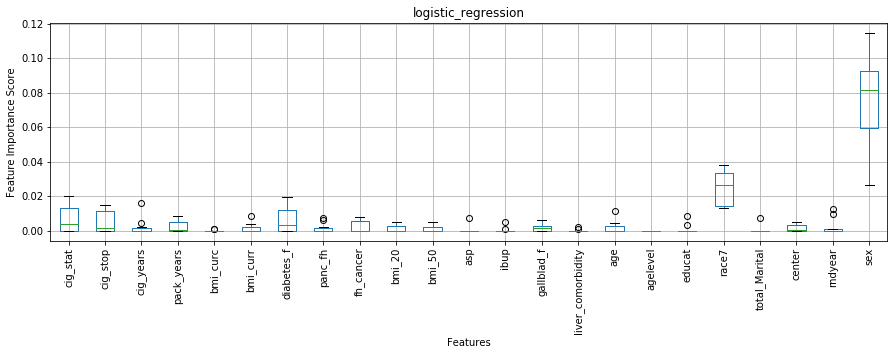

Text(0.5, 1.0, 'decision_tree')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x1ed9dc83f88>,
 <a list of 23 Text xticklabel objects>)

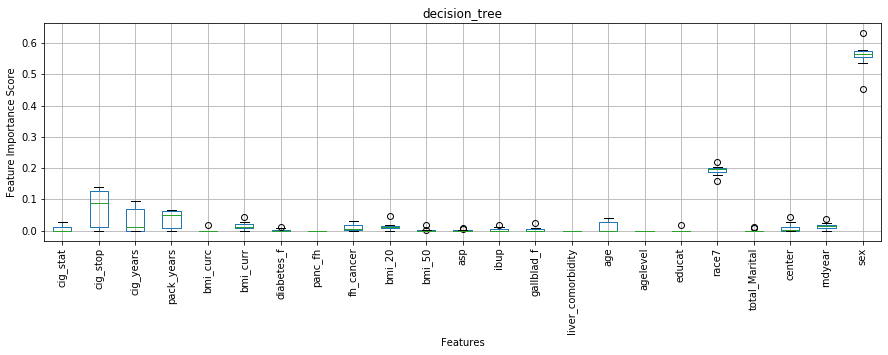

Text(0.5, 1.0, 'random_forest')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x1ed9dc67488>,
 <a list of 23 Text xticklabel objects>)

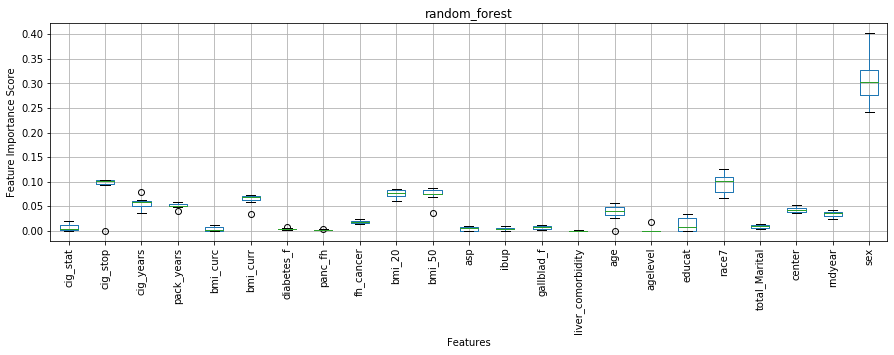

Text(0.5, 1.0, 'naive_bayes')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x1ed9821dd48>,
 <a list of 23 Text xticklabel objects>)

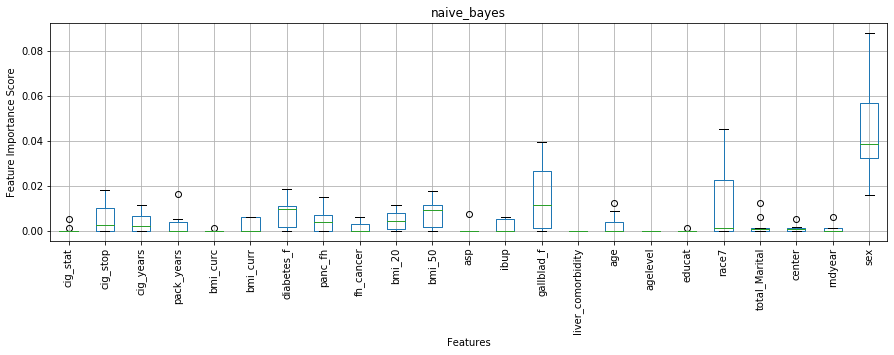

Text(0.5, 1.0, 'XGB')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x1ed97dbdac8>,
 <a list of 23 Text xticklabel objects>)

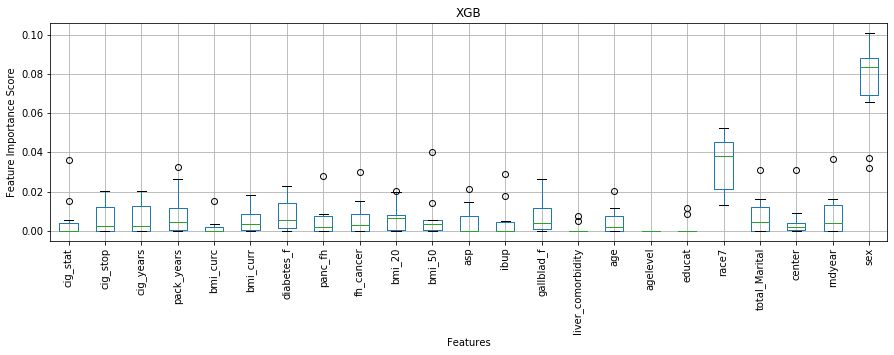

Text(0.5, 1.0, 'LGB')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x1ed981aa9c8>,
 <a list of 23 Text xticklabel objects>)

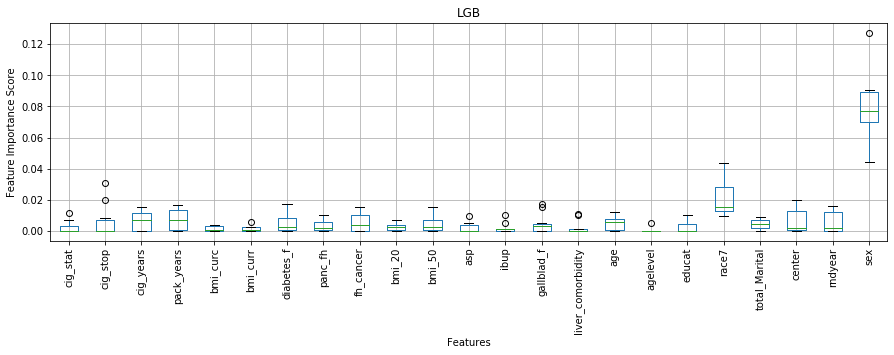

Text(0.5, 1.0, 'SVM')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x1ed9c3a23c8>,
 <a list of 23 Text xticklabel objects>)

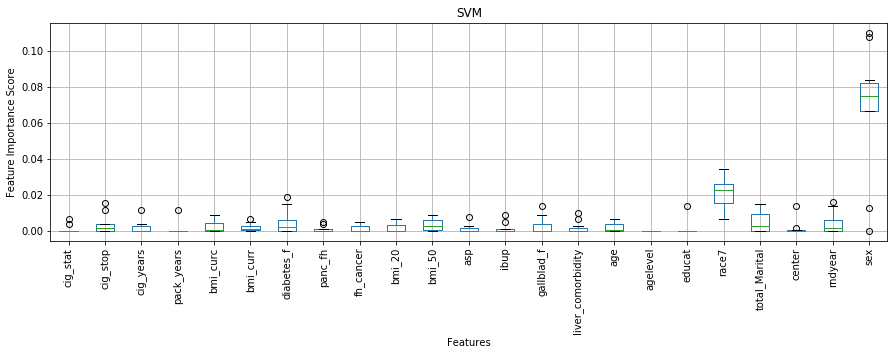

Text(0.5, 1.0, 'ANN')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x1ed9d48c848>,
 <a list of 23 Text xticklabel objects>)

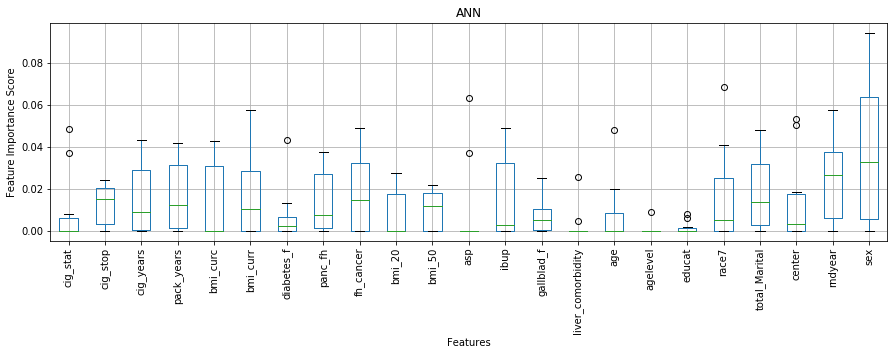

Text(0.5, 1.0, 'LCS')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x1ed9c74df48>,
 <a list of 23 Text xticklabel objects>)

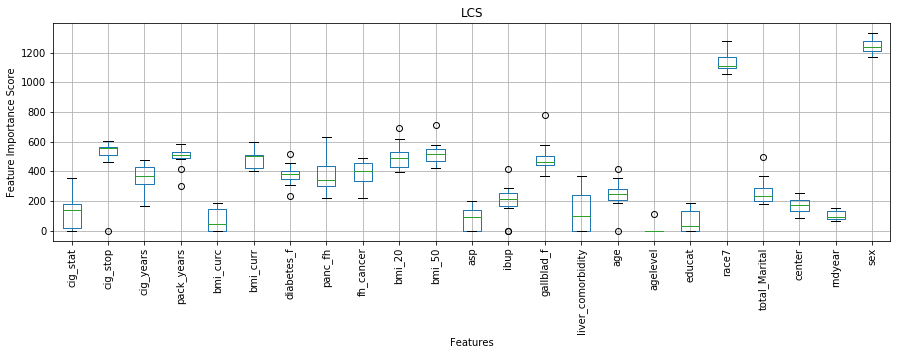

Text(0.5, 1.0, 'LCS_QRF')

Text(0, 0.5, 'Feature Importance Score')

Text(0.5, 0, 'Features')

([<matplotlib.axis.XTick at 0x1ed9d5c9488>,
 <a list of 23 Text xticklabel objects>)

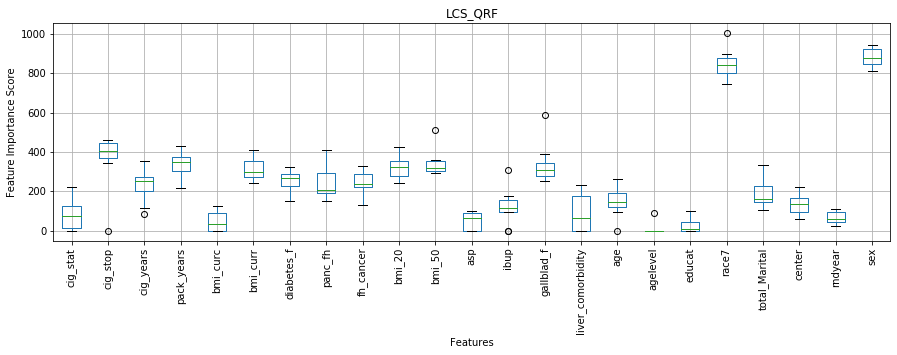

In [83]:
counter = 0
for df in fi_df_list:
    fig = plt.figure(figsize=(15,4))
    boxplot = df.boxplot(rot=90)
    plt.title(algorithmsToRun[counter])
    plt.ylabel('Feature Importance Score')
    plt.xlabel('Features')
    plt.xticks(np.arange(1,len(printfeatureNames)+1), printfeatureNames,rotation='vertical')
    plt.savefig((wd_path+output_folder+'/'+algorithmsToRun[counter]+'_boxplot_' + data_name), bbox_inches = "tight")
    plt.show()

    counter += 1

### Create Normalized dataframes with feature viz subsets

In [84]:
featuresToViz

feature_indexToViz = []
for i in featuresToViz:
    feature_indexToViz.append(all_feature_list.index(i))
feature_indexToViz

#Preserve features in original dataset order for consistency
top_fi_ave_norm_list = []
for i in range(len(algorithmsToRun)):
    tempList = []
    for j in range(len(fi_ave_norm_list[i])):
        if j in feature_indexToViz:
            tempList.append(fi_ave_norm_list[i][j])
    top_fi_ave_norm_list.append(tempList)

#Create feature name list in propper order
all_feature_listToViz = []
for j in (all_feature_list):
    if j in featuresToViz:
        all_feature_listToViz.append(j)
all_feature_listToViz

['sex',
 'race7',
 'cig_stop',
 'pack_years',
 'bmi_50',
 'bmi_curr',
 'gallblad_f',
 'bmi_20',
 'cig_years',
 'fh_cancer',
 'diabetes_f',
 'rndyear',
 'total_Marital',
 'panc_fh',
 'center',
 'age',
 'ibup',
 'cig_stat',
 'asp',
 'bmi_curc']

[22, 18, 1, 3, 10, 5, 13, 9, 2, 8, 6, 21, 19, 7, 20, 15, 12, 0, 11, 4]

['cig_stat',
 'cig_stop',
 'cig_years',
 'pack_years',
 'bmi_curc',
 'bmi_curr',
 'diabetes_f',
 'panc_fh',
 'fh_cancer',
 'bmi_20',
 'bmi_50',
 'asp',
 'ibup',
 'gallblad_f',
 'age',
 'race7',
 'total_Marital',
 'center',
 'rndyear',
 'sex']

In [85]:
def compound_FI_plot(fi_list,algorithmsToRun,algColors,all_feature_listToViz,figName):
    
    # y-axis in bold
    rc('font', weight='bold', size=16)
    
    # The position of the bars on the x-axis
    r = all_feature_listToViz
    barWidth = 0.75
    plt.figure(figsize=(figx,figy))
            
    lines = None
    if len(algorithmsToRun) == 1:
        print("Plotting with 1 algorithm.")
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        lines = (p1[0])
        
    elif len(algorithmsToRun) == 2:
        print("Plotting with 2 algorithms.")
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0])
        
    elif len(algorithmsToRun) == 3:
        print("Plotting with 3 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0])
        
    elif len(algorithmsToRun) == 4:
        print("Plotting with 4 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0],p4[0])
        
    elif len(algorithmsToRun) == 5:
        print("Plotting with 5 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        bottom5 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        p5 = plt.bar(r, fi_list[4], bottom=bottom5, color=algColors[4], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0],p4[0],p5[0])
        
    elif len(algorithmsToRun) == 6:
        print("Plotting with 6 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        bottom5 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3])]
        bottom6 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        p5 = plt.bar(r, fi_list[4], bottom=bottom5, color=algColors[4], edgecolor='white', width=barWidth)
        p6 = plt.bar(r, fi_list[5], bottom=bottom6, color=algColors[5], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0],p4[0],p5[0],p6[0])
        
    elif len(algorithmsToRun) == 7:
        print("Plotting with 7 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        bottom5 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3])]
        bottom6 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4])]
        bottom7 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        p5 = plt.bar(r, fi_list[4], bottom=bottom5, color=algColors[4], edgecolor='white', width=barWidth)
        p6 = plt.bar(r, fi_list[5], bottom=bottom6, color=algColors[5], edgecolor='white', width=barWidth)
        p7 = plt.bar(r, fi_list[6], bottom=bottom7, color=algColors[6], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0],p4[0],p5[0],p6[0],p7[0])

    elif len(algorithmsToRun) == 8:
        print("Plotting with 8 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        bottom5 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3])]
        bottom6 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4])]
        bottom7 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5])]
        bottom8 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5], fi_list[6])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        p5 = plt.bar(r, fi_list[4], bottom=bottom5, color=algColors[4], edgecolor='white', width=barWidth)
        p6 = plt.bar(r, fi_list[5], bottom=bottom6, color=algColors[5], edgecolor='white', width=barWidth)
        p7 = plt.bar(r, fi_list[6], bottom=bottom7, color=algColors[6], edgecolor='white', width=barWidth)
        p8 = plt.bar(r, fi_list[7], bottom=bottom8, color=algColors[7], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0],p4[0],p5[0],p6[0],p7[0],p8[0])
        
    elif len(algorithmsToRun) == 9:
        print("Plotting with 9 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        bottom5 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3])]
        bottom6 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4])]
        bottom7 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5])]
        bottom8 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5], fi_list[6])]
        bottom9 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5], fi_list[6], fi_list[7])]
        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        p5 = plt.bar(r, fi_list[4], bottom=bottom5, color=algColors[4], edgecolor='white', width=barWidth)
        p6 = plt.bar(r, fi_list[5], bottom=bottom6, color=algColors[5], edgecolor='white', width=barWidth)
        p7 = plt.bar(r, fi_list[6], bottom=bottom7, color=algColors[6], edgecolor='white', width=barWidth)
        p8 = plt.bar(r, fi_list[7], bottom=bottom8, color=algColors[7], edgecolor='white', width=barWidth)
        p9 = plt.bar(r, fi_list[8], bottom=bottom9, color=algColors[8], edgecolor='white', width=barWidth)
        lines = (p1[0],p2[0],p3[0],p4[0],p5[0],p6[0],p7[0],p8[0],p9[0]) 

    elif len(algorithmsToRun) == 10:
        print("Plotting with 10 algorithms.")
        bottom3 = [sum(i) for i in zip(fi_list[0], fi_list[1])]
        bottom4 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2])]
        bottom5 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3])]
        bottom6 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4])]
        bottom7 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5])]
        bottom8 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5], fi_list[6])]
        bottom9 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5], fi_list[6], fi_list[7])]
        bottom10 = [sum(i) for i in zip(fi_list[0], fi_list[1], fi_list[2], fi_list[3], fi_list[4], fi_list[5], fi_list[6], fi_list[7], fi_list[8])]

        p1 = plt.bar(r, fi_list[0], color=algColors[0], edgecolor='white', width=barWidth)
        p2 = plt.bar(r, fi_list[1], bottom=fi_list[0], color=algColors[1], edgecolor='white', width=barWidth)
        p3 = plt.bar(r, fi_list[2], bottom=bottom3, color=algColors[2], edgecolor='white', width=barWidth)
        p4 = plt.bar(r, fi_list[3], bottom=bottom4, color=algColors[3], edgecolor='white', width=barWidth)
        p5 = plt.bar(r, fi_list[4], bottom=bottom5, color=algColors[4], edgecolor='white', width=barWidth)
        p6 = plt.bar(r, fi_list[5], bottom=bottom6, color=algColors[5], edgecolor='white', width=barWidth)
        p7 = plt.bar(r, fi_list[6], bottom=bottom7, color=algColors[6], edgecolor='white', width=barWidth)
        p8 = plt.bar(r, fi_list[7], bottom=bottom8, color=algColors[7], edgecolor='white', width=barWidth)
        p9 = plt.bar(r, fi_list[8], bottom=bottom9, color=algColors[8], edgecolor='white', width=barWidth)
        p10 = plt.bar(r, fi_list[9], bottom=bottom10, color=algColors[9], edgecolor='white', width=barWidth)

        lines = (p1[0],p2[0],p3[0],p4[0],p5[0],p6[0],p7[0],p8[0],p9[0],p10[0]) 
        
    # Custom X axis
    plt.xticks(np.arange(len(all_feature_listToViz)), all_feature_listToViz,rotation='vertical')
    plt.xlabel("Feature", fontsize=20)
    plt.ylabel("Normalized Feature Importance", fontsize=20)
    plt.legend(lines, methodsKey, loc=0,fontsize=16)
    plt.savefig(wd_path+output_folder+'/Compare_FI_'+figName+'_'+data_name, bbox_inches = 'tight')
    # Show graphic
    plt.show()

## Compound Feature Importance Plot (Normalized only)

Plotting with 10 algorithms.


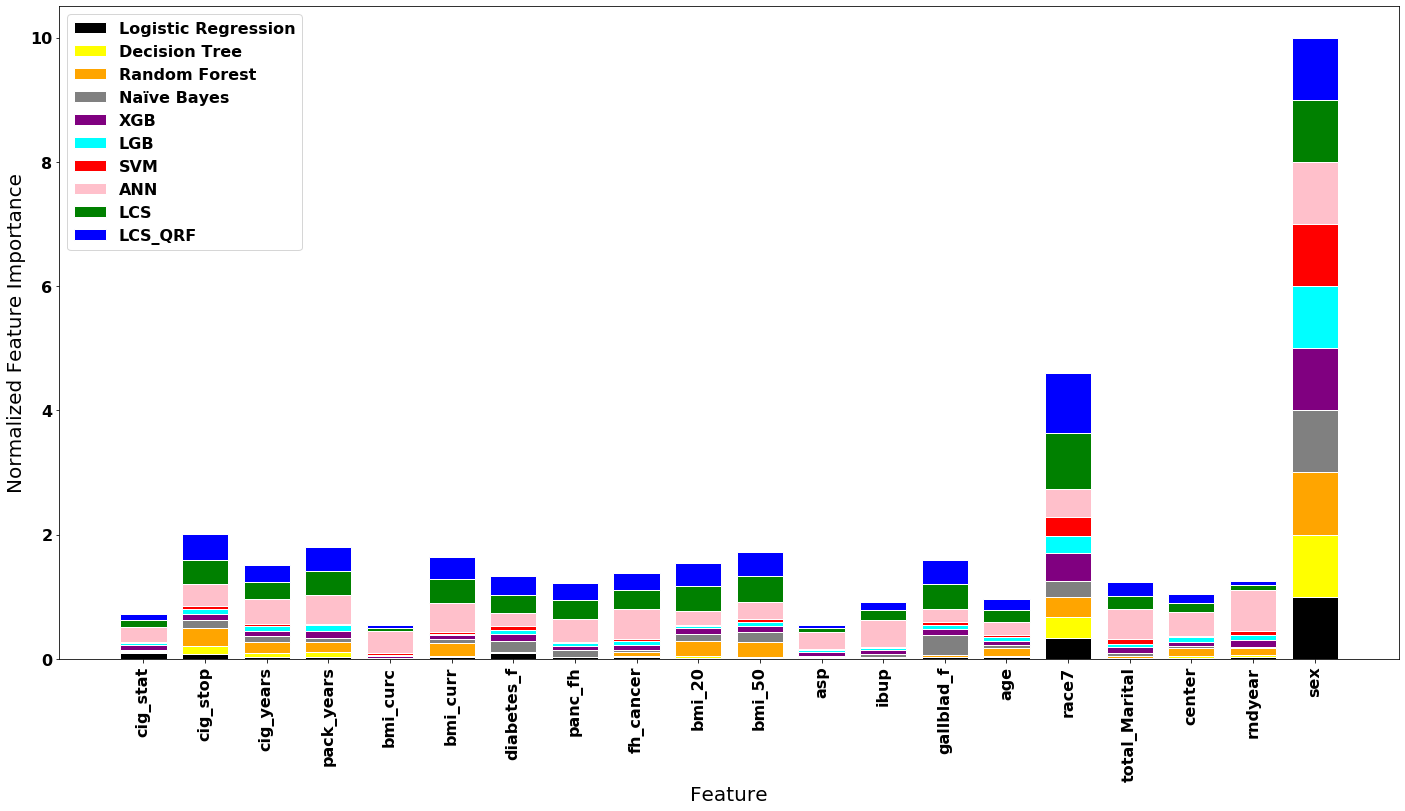

In [86]:
compound_FI_plot(top_fi_ave_norm_list,algorithmsToRun,algColors,all_feature_listToViz,'Norm')

##  Fraction Adjustment of Normalized Feature importances
- Each scores from each algorithm divided by sum of all scores

In [87]:
fracLists = []

for each in top_fi_ave_norm_list:
    fracList = []
    for i in range(len(each)):
        fracList.append((each[i]/(sum(each))))
    fracLists.append(fracList)

## Compound Feature Importance Plot (Normalized + Fraction Adjustment)

Plotting with 10 algorithms.


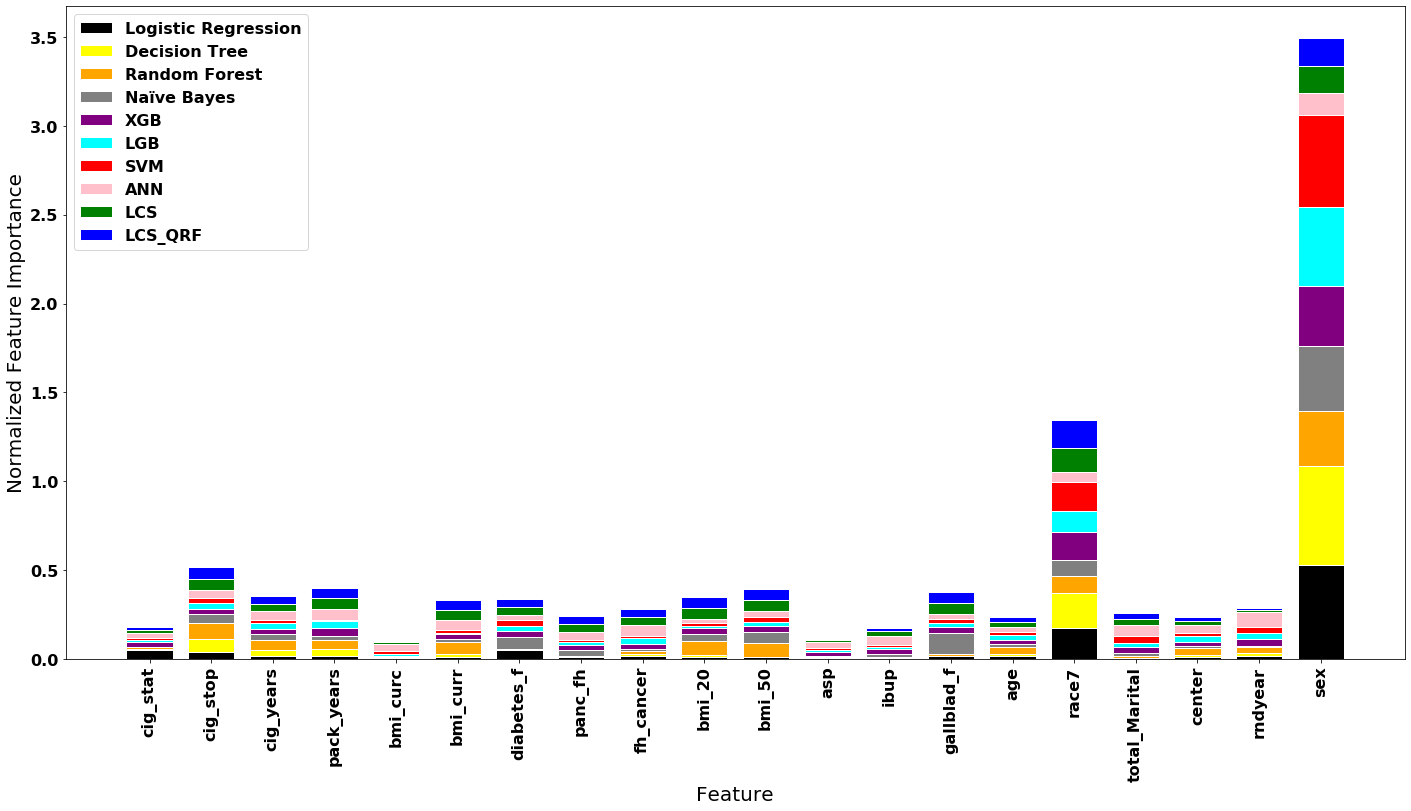

In [88]:
compound_FI_plot(fracLists,algorithmsToRun,algColors,all_feature_listToViz,'Norm_Frac')

##  Performance Weighting of Normalized Feature importances

In [89]:
#Prepare weights
weights = []

# replace all balanced accuraces <=.5 with 0
for i in range(len(ave_metric_list)):
    if ave_metric_list[i] <= .5:
        ave_metric_list[i] = 0

# normalize balanced accuracies
for i in range(len(ave_metric_list)):
    if ave_metric_list[i] == 0:
        weights.append(0)
    else:
        weights.append((ave_metric_list[i]-0.5)/0.5)
        
        
# Weight normalized feature importances
weightedLists = []

for i in range(len(top_fi_ave_norm_list)):
    weightList = np.multiply(weights[i],top_fi_ave_norm_list[i]).tolist()
    weightedLists.append(weightList)

## Compound Feature Importance Plot (Normalized + Perf. Weight Adjustment)

Plotting with 10 algorithms.


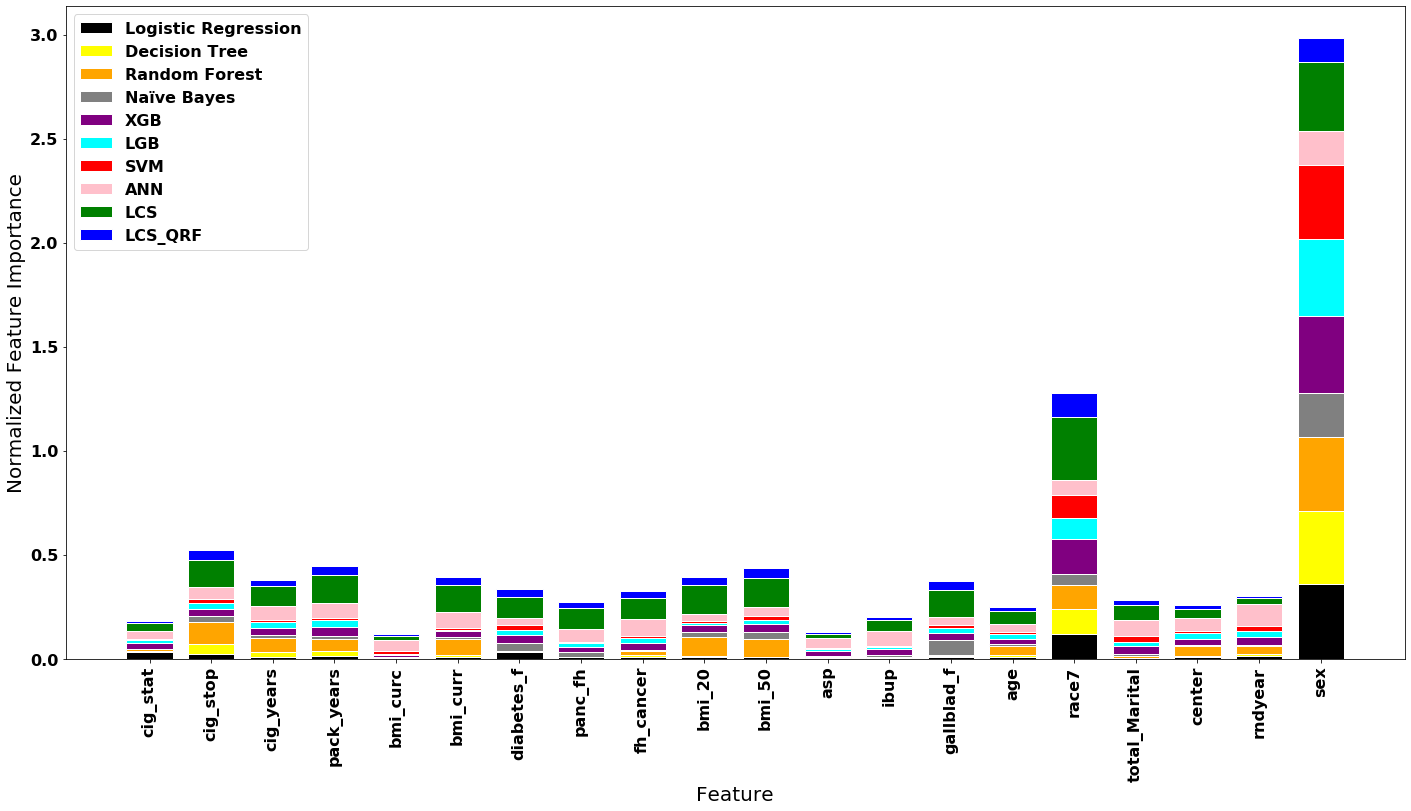

In [90]:
compound_FI_plot(weightedLists,algorithmsToRun,algColors,all_feature_listToViz,'Norm_Weight')

##  Performance Weighting of Fract. Adj. and Normalized Feature importances

In [91]:
# Weight normalized feature importances
weightedFracLists = []

for i in range(len(fracLists)):
    weightList = np.multiply(weights[i],fracLists[i]).tolist()
    weightedFracLists.append(weightList)

## Compound Feature Importance Plot (Normalized + Frac. + Perf. Weight Adjustment)

Plotting with 10 algorithms.


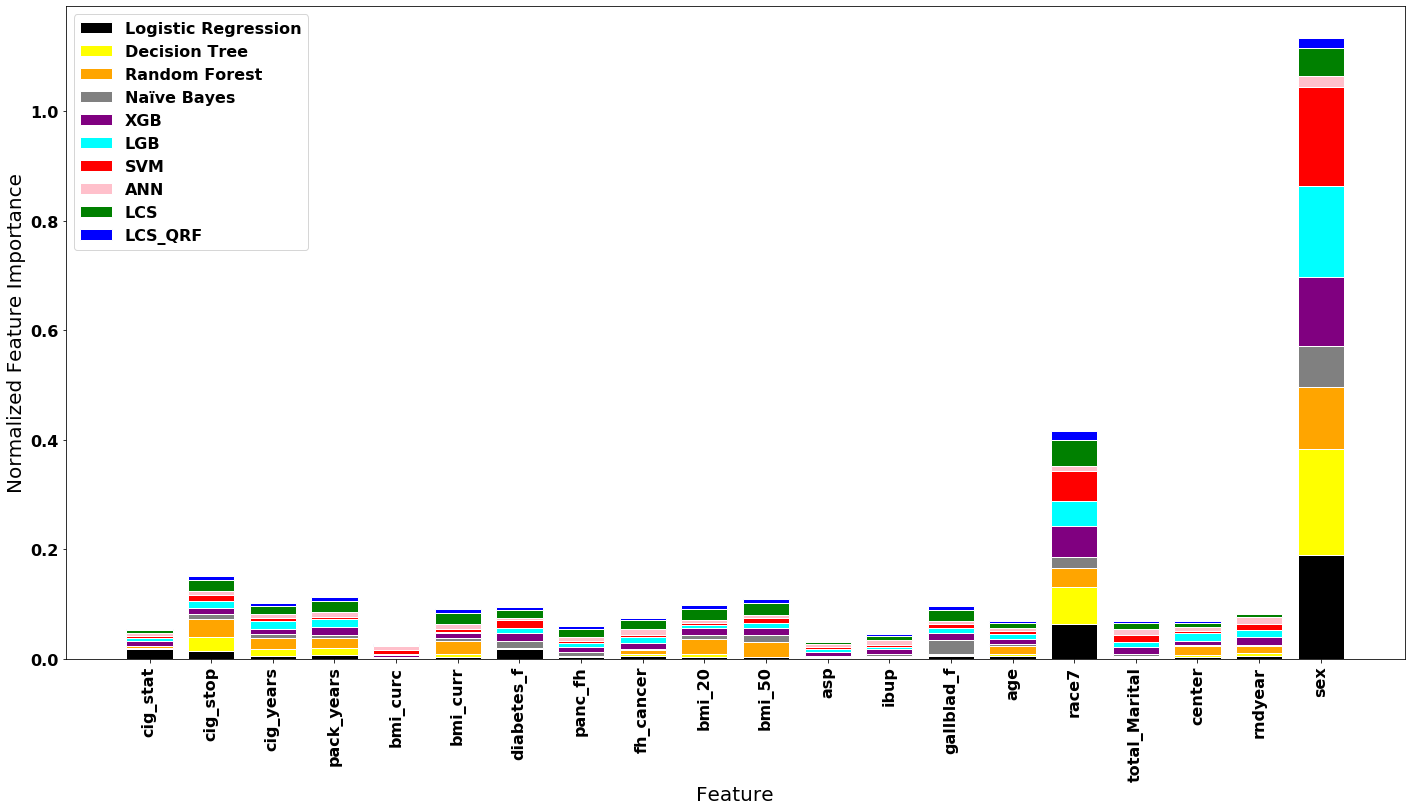

In [92]:
compound_FI_plot(weightedFracLists,algorithmsToRun,algColors,all_feature_listToViz,'Norm_Frac_Weight')

# Runtime Report

In [93]:
notebook_elapsed_time = time.time() - notebook_start_time
print('Pipeline Run Time: '+ str(notebook_elapsed_time))
run_time_dict['pipeline'] = notebook_elapsed_time
print(run_time_dict)

Pipeline Run Time: 39864.805611371994
{'mutual_information': 9.559181451797485, 'multisurf': 750.9629020690918, 'logistic_regression': 296.77040934562683, 'decision_tree': 286.4733467102051, 'random_forest': 2604.0302968025208, 'naive_bayes': 2.549142837524414, 'XGB': 2685.6573197841644, 'LGB': 1002.0901114940643, 'SVM': 14065.45315861702, 'ANN': 4140.119745969772, 'LCS': 13966.640100002289, 'pipeline': 39864.805611371994}
